In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import gym
from gym import spaces
import matplotlib.pyplot as plt
import random

In [2]:
import pandas as pd

# Use raw export link from Google Drive (replace with your file's ID)
file_id = '1P9SFnOtmradQHsaB_HUb0tgFbr5rU_fc'
url = f'https://drive.google.com/uc?export=download&id={file_id}'

df = pd.read_csv(url)


Downloading...
From: https://drive.google.com/uc?id=1P9SFnOtmradQHsaB_HUb0tgFbr5rU_fc
To: /content/all_node_combinations.csv
100%|██████████| 9.05k/9.05k [00:00<00:00, 1.79MB/s]


,Source_Node,Destination_Node,Latency_ms,Bandwidth_Mbps,Throughput_Mbps,Jitter_ms,Packet_Loss_%
0,1,2,60,882,848,3,0.41
1,1,3,65,102,27,15,1.29
2,1,4,53,871,683,21,3.64
3,1,5,28,413,306,37,1.73
4,1,6,24,965,787,24,2.72


# **SOURCE DESTINATION PAIRS**

In [3]:
test_source_node=14
test_destination_node=19

# **In this cell, we define a custom Gym environment called ShortestPathEnv that uses the uploaded dataset Graph Construction: The environment builds a directed graph from the DataFrame using nx.from_pandas_edgelist.
Edge Lookup: A dictionary (edge_lookup) maps each edge to a reward weight based on the chosen metric (default is "Latency_ms").
Action and Observation Space: The action space is defined over all unique nodes in the graph, and the observation is the current node.
Step Function: The environment checks if the chosen action (next node) is valid, applies penalties for invalid moves or self-loops, and gives a bonus reward when the destination is reached.
You can modify the reward function or extend the environment to incorporate other network metrics as needed**

In [4]:
# -------------------------------
# Cell 2: Define the Environment
# -------------------------------
class NetworkRoutingEnv(gym.Env):
    """
    Custom Gym environment for network routing using a dataset.

    The environment builds a directed graph from a DataFrame containing the columns:
      - 'Source_Node'
      - 'Destination_Node'
      - 'Latency_ms'
      - 'Bandwidth_Mbps'
      - 'Throughput_Mbps'
      - 'Jitter_ms'
      - 'Packet_Loss_%'

    Reward is defined as the negative latency (to minimize RTT). A bonus is given when
    the destination is reached.
    """
    def __init__(self, df, source, destination, metric='Latency_ms'):
        super(NetworkRoutingEnv, self).__init__()
        self.df = df
        self.source = source
        self.destination = destination
        self.metric = metric

        # Build a directed graph from the DataFrame.
        self.graph = nx.from_pandas_edgelist(
            df,
            source='Source_Node',
            target='Destination_Node',
            edge_attr=True,
            create_using=nx.DiGraph
        )
        # Sort nodes for consistency and create a lookup.
        self.nodes = sorted(list(self.graph.nodes()))
        self.num_nodes = len(self.nodes)

        # Build an edge lookup: maps (source, destination) to a dictionary of metrics.
        self.edge_lookup = {}
        for _, row in df.iterrows():
            s = row['Source_Node']
            t = row['Destination_Node']
            self.edge_lookup[(s, t)] = row.to_dict()

        # Define action and observation spaces.
        # Action space: discrete actions mapping to an index in self.nodes.
        self.action_space = spaces.Discrete(self.num_nodes)
        self.observation_space = spaces.Discrete(self.num_nodes)

        self.current_node = self.source

    def reset(self):
        self.current_node = self.source
        return self.current_node

    def step(self, action):
        # Map action index to actual node.
        next_node = self.nodes[action]
        if not self.graph.has_edge(self.current_node, next_node):
            # No edge exists: invalid move.
            reward = -100
            done = True
        elif next_node == self.current_node:
            # Self-loop.
            reward = -100
            done = False
        else:
            # Valid edge: reward is negative of the selected metric (e.g., latency).
            edge_data = self.edge_lookup.get((self.current_node, next_node))
            if edge_data is None:
                reward = -100
                done = True
            else:
                reward = -edge_data[self.metric]
                self.current_node = next_node
                if self.current_node == self.destination:
                    reward += 1000  # Bonus for reaching the destination.
                    done = True
                else:
                    done = False

        return self.current_node, reward, done, {}

    def render(self, mode='human'):
        print("Current node:", self.current_node)


# Example usage:
# Create an instance of the environment using df_normalized.
# For example, set source to node 1 and destination to node 6 (adjust based on your dataset).
#env = ShortestPathEnv(df, source_node=1, destination_node=6, metric='Latency_ms')


# **Cell 3: Q-Learning Functions

Purpose:
Implement the Q-learning algorithm:
run_qlearning: Trains an agent using an epsilon-greedy policy to learn optimal transitions.
evaluate_final_path: Uses the trained Q-table to construct the best path in a greedy manner. It also aggregates network metrics along the path:
Total Latency: Sum of latencies along the edges.
Bottleneck Bandwidth: Minimum bandwidth encountered.
Bottleneck Throughput: Minimum throughput encountered.
Average Jitter: Mean jitter along the path.
Average Packet Loss: Mean packet loss along the path.**

In [5]:
def run_qlearning(env, alpha=0.05, gamma=0.99, eps_decay=0.85,
                  num_episodes=50000, min_epsilon=0.01, verbose=False):
    """
    Standard Q-learning algorithm adapted for NetworkRoutingEnv.
    Returns the learned Q-table.
    """
    # Q-table shape: (number of nodes, number of actions)
    q_table = np.zeros((env.num_nodes, env.num_nodes))
    epsilon = 0.950

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            state_idx = env.nodes.index(state)
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                valid_actions = [a for a in range(env.num_nodes) if env.nodes[a] != state]
                action = random.choice(valid_actions)
            else:
                # Greedy with respect to Q-table
                action = np.argmax(q_table[state_idx, :])
                if env.nodes[action] == state:
                    # Avoid self-loop by temporarily penalizing that action
                    q_table[state_idx, action] = -np.inf
                    action = np.argmax(q_table[state_idx, :])

            next_state, reward, done, _ = env.step(action)
            next_state_idx = env.nodes.index(next_state)
            td_target = reward + gamma * np.max(q_table[next_state_idx, :])
            td_error = td_target - q_table[state_idx, action]
            q_table[state_idx, action] += alpha * td_error

            state = next_state

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * eps_decay)
        if verbose and (episode + 1) % 5000 == 0:
            print(f"Episode {episode+1}/{num_episodes}")

    return q_table


def evaluate_final_path(env, q_table):
    """
    Constructs the best path from source to destination using a greedy policy based on q_table.
    Also computes aggregated metrics along the path:
      - Total latency (sum of Latency_ms)
      - Bottleneck bandwidth (min of Bandwidth_Mbps)
      - Bottleneck throughput (min of Throughput_Mbps)
      - Average jitter (mean of Jitter_ms)
      - Average packet loss (mean of Packet_Loss_%)
    Returns:
      (path, total_latency, best_bandwidth, best_throughput, avg_jitter, avg_packet_loss)
    """
    state = env.reset()
    done = False
    path = [state]
    visited = set()
    max_steps = env.num_nodes * 2

    while not done and len(path) < max_steps:
        state_idx = env.nodes.index(state)
        action = np.argmax(q_table[state_idx, :])
        next_node = env.nodes[action]
        if next_node == state or next_node in visited:
            # No progress or loop
            break
        visited.add(state)
        state, reward, done, _ = env.step(action)
        path.append(state)

    # Aggregate metrics along the path
    total_latency = 0
    bandwidths, throughputs, jitters, packet_losses = [], [], [], []
    for i in range(len(path) - 1):
        edge_data = env.edge_lookup.get((path[i], path[i+1]))
        if edge_data:
            total_latency += edge_data['Latency_ms']
            bandwidths.append(edge_data['Bandwidth_Mbps'])
            throughputs.append(edge_data['Throughput_Mbps'])
            jitters.append(edge_data['Jitter_ms'])
            packet_losses.append(edge_data['Packet_Loss_%'])

    best_bandwidth = min(bandwidths) if bandwidths else None
    best_throughput = min(throughputs) if throughputs else None
    avg_jitter = np.mean(jitters) if jitters else None
    avg_packet_loss = np.mean(packet_losses) if packet_losses else None

    return path, total_latency, best_bandwidth, best_throughput, avg_jitter, avg_packet_loss


# **Cell 4: Running Q-Learning and Evaluating the Path
Purpose:
Create an instance of the environment using the dataset.
Run Q-learning to generate a Q-table.
Evaluate the final path using the learned Q-table.
Print the best path along with its aggregated metrics.**

In [6]:
# -------------------------------
# Cell 4: Running Q-Learning and Evaluating the Path
# -------------------------------
# Define source and destination nodes (adjust based on your dataset)

# Create the environment instance.
env = NetworkRoutingEnv(df, source=test_source_node, destination=test_destination_node, metric='Latency_ms')

# Run Q-learning to obtain a Q-table.
q_table = run_qlearning(env, alpha=0.05, gamma=0.79, eps_decay=0.85, num_episodes=50000, min_epsilon=0.01, verbose=True)

# Evaluate the final path using the learned Q-table.
(best_path, total_latency, best_bandwidth, best_throughput, avg_jitter, avg_packet_loss) = evaluate_final_path(env, q_table)

# Print the results.
print("Best path:", best_path)
print("Total Latency (ms):", total_latency)
print("Bottleneck Bandwidth (Mbps):", best_bandwidth)
print("Bottleneck Throughput (Mbps):", best_throughput)
print("Average Jitter (ms):", avg_jitter)
print("Average Packet Loss (%):", avg_packet_loss)

Episode 5000/50000
Episode 10000/50000
Episode 15000/50000
Episode 20000/50000
Episode 25000/50000
Episode 30000/50000
Episode 35000/50000
Episode 40000/50000
Episode 45000/50000
Episode 50000/50000
Best path: [14, 18, 19]
Total Latency (ms): 57.0
Bottleneck Bandwidth (Mbps): 310.0
Bottleneck Throughput (Mbps): 235.0
Average Jitter (ms): 29.0
Average Packet Loss (%): 1.6


*REAL TIME SIMULATION FOR RL ONLY*

In [7]:
import time
import numpy as np

# -------------------------------
# Real-time Q-Learning Simulation
# -------------------------------
while True:
    # 1) Simulate real-time updates to the DataFrame.
    #    For example, randomly scale latency values by +/-10%.
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # 2) Recreate the environment with updated latencies.
    env = NetworkRoutingEnv(
        df,
        source=test_source_node,
        destination=test_destination_node,
        metric='Latency_ms'
    )

    # 3) Run Q-learning with the updated environment.
    #    (Adjust hyperparameters as desired for faster or more detailed updates.)
    q_table = run_qlearning(
        env,
        alpha=0.05,
        gamma=0.79,
        eps_decay=0.85,
        num_episodes=50000,
        min_epsilon=0.01,
        verbose=False
    )

    # 4) Evaluate the final path using the newly learned Q-table.
    (best_path,
     total_latency,
     best_bandwidth,
     best_throughput,
     avg_jitter,
     avg_packet_loss) = evaluate_final_path(env, q_table)

    # 5) Print the current best path and metrics.
    print("\n--- Real-time Q-Learning Update ---")
    print("Best path:", best_path)
    print("Total Latency (ms):", total_latency)
    print("Bottleneck Bandwidth (Mbps):", best_bandwidth)
    print("Bottleneck Throughput (Mbps):", best_throughput)
    print("Average Jitter (ms):", avg_jitter)
    print("Average Packet Loss (%):", avg_packet_loss)

    # 6) Wait for a few seconds before the next simulation update.
    #    Adjust the sleep interval as needed.
    time.sleep(1)



--- Real-time Q-Learning Update ---
Best path: [14, 7, 19]
Total Latency (ms): 107.11221181930289
Bottleneck Bandwidth (Mbps): 209.0
Bottleneck Throughput (Mbps): 101.0
Average Jitter (ms): 18.5
Average Packet Loss (%): 2.335

--- Real-time Q-Learning Update ---
Best path: [14, 19]
Total Latency (ms): 59.12015263681792
Bottleneck Bandwidth (Mbps): 597.0
Bottleneck Throughput (Mbps): 493.0
Average Jitter (ms): 46.0
Average Packet Loss (%): 3.87

--- Real-time Q-Learning Update ---
Best path: [14, 7, 19]
Total Latency (ms): 103.11865708002303
Bottleneck Bandwidth (Mbps): 209.0
Bottleneck Throughput (Mbps): 101.0
Average Jitter (ms): 18.5
Average Packet Loss (%): 2.335

--- Real-time Q-Learning Update ---
Best path: [14, 19]
Total Latency (ms): 66.83287107672349
Bottleneck Bandwidth (Mbps): 597.0
Bottleneck Throughput (Mbps): 493.0
Average Jitter (ms): 46.0
Average Packet Loss (%): 3.87


KeyboardInterrupt: 

#**Graylag Goose Optimization Functions:

compute_path_cost: Computes the total latency (cost) for a path, penalizing invalid paths heavily.
generate_random_path: Generates a random candidate path between a source and destination.
get_best_goose: Selects the best candidate (lowest latency) from a population.
goose_movement_path: Updates a candidate path using a crossover-like approach with the leader's path and includes random mutation.
run_pure_ggo: The main routine that iteratively refines a population of candidate paths and returns the best path, its cost, and the cost history.
compute_path_metrics: Aggregates detailed network metrics (latency, bandwidth, throughput, jitter, packet loss) along a given path.**

In [ ]:
# -------------------------------
# 2. Graylag Goose Optimization Functions (Improved for Dataset)
# -------------------------------
def compute_path_cost(path, adjacency_matrix, dest, node_to_index):
    """
    Compute total latency (cost) for a given path.
    Returns a high penalty (1e9) if:
      - The path does not end in dest.
      - A node is revisited.
      - Any required edge is missing.
    """
    total = 0
    visited = set()
    if not path or path[-1] != dest:
        return 1e9
    for i in range(len(path) - 1):
        s, d = path[i], path[i+1]
        if s in visited:
            return 1e9
        visited.add(s)
        i_s = node_to_index[s]
        i_d = node_to_index[d]
        if adjacency_matrix[i_s, i_d] == 0 and s != d:
            return 1e9
        total += adjacency_matrix[i_s, i_d]
    return total

def generate_random_path(source, destination, adjacency_matrix, node_to_index, nodes, max_len=5):
    """
    Generate a random path from source to destination.
    The path is limited to at most max_len hops. If the destination isn't reached,
    it is appended at the end.
    """
    p = [source]
    curr = source
    for _ in range(max_len):
        if curr == destination:
            break
        curr_idx = node_to_index[curr]
        next_hops = [nodes[j] for j in range(adjacency_matrix.shape[1])
                     if adjacency_matrix[curr_idx, j] != 0 and nodes[j] != curr]
        if not next_hops:
            break
        nxt = random.choice(next_hops)
        p.append(nxt)
        curr = nxt
    if p[-1] != destination:
        p.append(destination)
    return p

def get_best_goose(pop, adjacency_matrix, gg_dst, node_to_index):
    bestp = None
    bestc = float('inf')
    for goose in pop:
        c = compute_path_cost(goose, adjacency_matrix, gg_dst, node_to_index)
        if c < bestc:
            bestc = c
            bestp = goose
    return bestp, bestc

def goose_movement_path(cur_path, leader_path, adjacency_matrix, gg_dst, node_to_index, nodes):
    newp = cur_path[:]
    len_lead = len(leader_path)
    len_cur = len(cur_path)
    swap_cnt = random.randint(1, max(1, min(len_lead, len_cur)//2))
    for _ in range(swap_cnt):
        idx_c = random.randint(1, len_cur-2) if len_cur > 2 else 1
        idx_l = random.randint(1, len_lead-2) if len_lead > 2 else 1
        newp[idx_c] = leader_path[idx_l]

    # Mutation with a small chance.
    if random.random() < 0.3 and len(newp) > 2:
        idx_mut = random.randint(1, len(newp)-2)
        prv = newp[idx_mut-1]
        i_prv = node_to_index[prv]
        nxt_h = [nodes[j] for j in range(adjacency_matrix.shape[1])
                 if adjacency_matrix[i_prv, j] != 0 and nodes[j] != prv]
        if nxt_h:
            newp[idx_mut] = random.choice(nxt_h)

    # Ensure last node is destination.
    if newp[-1] != gg_dst:
        newp[-1] = gg_dst
    return newp

def Run_pure_ggo9(adjacency_matrix, node_to_index, nodes, gg_src, gg_dst,
                 pop_size=200, max_iter=1000, max_len=5, verbose=True):
    """
    Runs the Graylag Goose Optimization to find a low-latency path from gg_src to gg_dst.
    Returns:
      - best_path: the best candidate path (list of nodes).
      - best_cost: the total latency of best_path.
      - cost_history: list of best cost at each iteration.
    """
    pop = []
    for _ in range(pop_size):
        pop.append(generate_random_path(gg_src, gg_dst, adjacency_matrix, node_to_index, nodes, max_len))
    best_path, best_cost = get_best_goose(pop, adjacency_matrix, gg_dst, node_to_index)
    cost_history = [best_cost]

    for it in range(max_iter):
        leader, leader_cost = get_best_goose(pop, adjacency_matrix, gg_dst, node_to_index)
        new_pop = []
        for goose in pop:
            if goose == leader:
                new_pop.append(goose)
            else:
                updated = goose_movement_path(goose, leader, adjacency_matrix, gg_dst, node_to_index, nodes)
                new_pop.append(updated)
        pop = new_pop
        cbest, ccost = get_best_goose(pop, adjacency_matrix, gg_dst, node_to_index)
        if ccost < best_cost:
            best_path, best_cost = cbest, ccost
        cost_history.append(best_cost)
        if verbose and (it+1) % 10 == 0:
            print(f"Iteration {it+1}/{max_iter}, Best Latency = {best_cost}")
    return best_path, best_cost, cost_history

def compute_path_metrics(path, edge_lookup, gg_dst):
    """
    Compute aggregated metrics along the given path:
      - Total Latency: Sum of Latency_ms.
      - Bottleneck Bandwidth: Minimum Bandwidth_Mbps.
      - Bottleneck Throughput: Minimum Throughput_Mbps.
      - Average Jitter: Mean Jitter_ms.
      - Average Packet Loss: Mean Packet_Loss_%.
    Returns a tuple of metrics.
    """
    if not path or path[-1] != gg_dst:
        return None
    total_latency = 0
    bandwidths = []
    throughputs = []
    jitters = []
    packet_losses = []
    for i in range(len(path)-1):
        edge = (path[i], path[i+1])
        if edge in edge_lookup:
            data = edge_lookup[edge]
            total_latency += data['Latency_ms']
            bandwidths.append(data['Bandwidth_Mbps'])
            throughputs.append(data['Throughput_Mbps'])
            jitters.append(data['Jitter_ms'])
            packet_losses.append(data['Packet_Loss_%'])
    best_bandwidth = min(bandwidths) if bandwidths else None
    best_throughput = min(throughputs) if throughputs else None
    avg_jitter = np.mean(jitters) if jitters else None
    avg_packet_loss = np.mean(packet_losses) if packet_losses else None
    return total_latency, best_bandwidth, best_throughput, avg_jitter, avg_packet_loss

In [ ]:
import numpy as np
import pandas as pd

def build_adjacency_matrix(df, metric='Latency_ms'):
    """
    Build an adjacency matrix (for the selected metric, e.g., latency) from the DataFrame,
    along with auxiliary structures:
      - node_to_index: Mapping from original node IDs to matrix indices.
      - nodes: Sorted list of nodes.
      - edge_lookup: Mapping from (source, destination) to the complete set of performance metrics.
    """
    nodes = sorted(set(df['Source_Node']).union(set(df['Destination_Node'])))
    node_to_index = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)

    # Initialize the matrix with zeros.
    A = np.zeros((n, n))

    # Build the edge_lookup dictionary.
    edge_lookup = {}
    for _, row in df.iterrows():
        s = row['Source_Node']
        d = row['Destination_Node']
        i = node_to_index[s]
        j = node_to_index[d]
        A[i, j] = row[metric]
        edge_lookup[(s, d)] = row.to_dict()
    return A, node_to_index, nodes, edge_lookup


# **Hyperparameter Search for Graylag Goose Optimization**

In this cell, we outline the general idea of performing a hyperparameter search (grid search) for GGO:

1. **Define Parameter Ranges**: For instance, list a few possible values for:
   - `pop_size` (number of geese in the population)
   - `max_iter` (how many iterations to run)
   - `max_len` (max hops in a random path)
   - Mutation probability (if you want to tune that too)
   - Any other important parameters

2. **Loop Over All Combinations**: For each combination of parameters:
   - Call `run_pure_ggo(...)` with those settings.
   - Capture the **best path** and **best cost**.
   - Keep track of the combination that yields the **lowest cost**.

3. **Store/Report Results**: Print or save the best hyperparameter set (or top-`k` sets) along with the corresponding best cost.  

You can then choose the best set of hyperparameters to use in your final runs or real-time scenario.


In [ ]:
import numpy as np
import random

def hyperparam_search_for_ggo(
    adjacency_matrix,
    node_to_index,
    nodes,
    edge_lookup,
    source,
    destination,
    # Parameter grids to search:
    pop_sizes=[50, 100, 200],
    max_iters=[500, 1000],
    max_lens=[5, 7],
    verbose=True
):
    """
    Performs a simple grid search over specified parameter ranges for GGO.
    Returns:
      best_config: dict of best hyperparams
      best_cost:   the best cost found
      best_path:   the best path associated with that cost
      results_log: list of (config, best_cost_for_config)
    """

    best_cost = 1e9
    best_path = None
    best_config = None
    results_log = []

    # Loop over all combinations
    for pop_size in pop_sizes:
        for max_iter in max_iters:
            for max_len in max_lens:
                # Run GGO with this combination
                if verbose:
                    print(f"\n>>> Trying pop_size={pop_size}, max_iter={max_iter}, max_len={max_len}")

                path_ggo, cost_ggo, cost_history = run_pure_ggo(
                    adjacency_matrix=adjacency_matrix,
                    node_to_index=node_to_index,
                    nodes=nodes,
                    gg_src=source,
                    gg_dst=destination,
                    pop_size=pop_size,
                    max_iter=max_iter,
                    max_len=max_len,
                    verbose=False  # Turn off internal printing to avoid clutter
                )

                # Check if this is the best so far
                if cost_ggo < best_cost:
                    best_cost = cost_ggo
                    best_path = path_ggo
                    best_config = {
                        "pop_size": pop_size,
                        "max_iter": max_iter,
                        "max_len": max_len
                    }

                # Log the result for reference
                results_log.append(({
                    "pop_size": pop_size,
                    "max_iter": max_iter,
                    "max_len": max_len
                }, cost_ggo))

                if verbose:
                    print(f"    -> Best cost for this config = {cost_ggo}")

    # Optionally compute path metrics if you like
    final_metrics = compute_path_metrics(best_path, edge_lookup, destination)

    if verbose:
        print("\n=== Hyperparameter Search Complete ===")
        print(f"Overall Best Config: {best_config}")
        print(f"Best Cost: {best_cost}")
        if final_metrics:
            print("Metrics:", final_metrics)
        else:
            print("No valid metrics for best path.")

    return best_config, best_cost, best_path, results_log


In [ ]:
# Example usage:
best_config, best_cost, best_path, log = hyperparam_search_for_ggo(
    adjacency_matrix=A,
    node_to_index=node_to_index,
    nodes=nodes,
    edge_lookup=edge_lookup,
    source=test_source_node,            # or your actual source
    destination=test_destination_node,       # or your actual destination
    pop_sizes=[50, 100, 200],
    max_iters=[500, 1000],
    max_lens=[5, 7],
    verbose=True
)





>>> Trying pop_size=50, max_iter=500, max_len=5
    -> Best cost for this config = 39.06214034631627

>>> Trying pop_size=50, max_iter=500, max_len=7
    -> Best cost for this config = 39.06214034631627

>>> Trying pop_size=50, max_iter=1000, max_len=5
    -> Best cost for this config = 39.06214034631627

>>> Trying pop_size=50, max_iter=1000, max_len=7
    -> Best cost for this config = 39.06214034631627

>>> Trying pop_size=100, max_iter=500, max_len=5
    -> Best cost for this config = 39.06214034631627

>>> Trying pop_size=100, max_iter=500, max_len=7
    -> Best cost for this config = 39.06214034631627

>>> Trying pop_size=100, max_iter=1000, max_len=5
    -> Best cost for this config = 39.06214034631627

>>> Trying pop_size=100, max_iter=1000, max_len=7
    -> Best cost for this config = 39.06214034631627

>>> Trying pop_size=200, max_iter=500, max_len=5
    -> Best cost for this config = 39.06214034631627

>>> Trying pop_size=200, max_iter=500, max_len=7
    -> Best cost for th

In [ ]:
print("The best configuration found is:", best_config)

# You can also access individual fields of 'best_config', e.g.:
pop_size_used = best_config["pop_size"]
mutation_prob_used = best_config["p_mutation"]
print("Best pop_size =", pop_size_used)
print("Best mutation probability =", mutation_prob_used)

# Expanded Graylag Goose Optimization

We modify the GGO to allow tuning of:
- `p_mutation`: Probability of mutation per iteration.
- `swap_min` & `swap_max`: Control how many "swap" operations occur between a goose path and the leader path.

### Functions

1. **`goose_movement_path_expanded`**:
   - Replaces `goose_movement_path`, adding the extra parameters.
   - Swaps a random segment of the current goose with the leader’s nodes, then optionally mutates a random node.

2. **`run_pure_ggo_expanded`**:
   - Replaces `run_pure_ggo`, referencing the new movement function.
   - Takes new hyperparameters: `p_mutation`, `swap_min`, `swap_max`.

3. **`hyperparam_search_for_ggo_expanded`**:
   - Performs a simple grid search over combinations of `pop_size`, `max_iter`, `max_len`, `p_mutation`, `swap_min`, and `swap_max`.
   - Returns the best configuration found, best cost, best path, and a log of all combinations tried.

We keep `compute_path_cost`, `generate_random_path`, `get_best_goose`, and `compute_path_metrics` largely the same, although you can rename them if desired.


In [ ]:
# import numpy as np
# import random

# def compute_path_cost(path, adjacency_matrix, dest, node_to_index):
#     """
#     Compute total latency (cost) for a given path.
#     Returns a high penalty (1e9) if:
#       - The path does not end in dest.
#       - A node is revisited.
#       - Any required edge is missing.
#     """
#     total = 0
#     visited = set()
#     if not path or path[-1] != dest:
#         return 1e9
#     for i in range(len(path) - 1):
#         s, d = path[i], path[i+1]
#         if s in visited:
#             return 1e9
#         visited.add(s)
#         i_s = node_to_index[s]
#         i_d = node_to_index[d]
#         if adjacency_matrix[i_s, i_d] == 0 and s != d:
#             return 1e9
#         total += adjacency_matrix[i_s, i_d]
#     return total

# def generate_random_path(source, destination, adjacency_matrix, node_to_index, nodes, max_len=5):
#     """
#     Generate a random path from source to destination.
#     Limited to at most max_len hops. If the destination isn't reached,
#     append it at the end.
#     """
#     p = [source]
#     curr = source
#     for _ in range(max_len):
#         if curr == destination:
#             break
#         curr_idx = node_to_index[curr]
#         next_hops = [nodes[j] for j in range(adjacency_matrix.shape[1])
#                      if adjacency_matrix[curr_idx, j] != 0 and nodes[j] != curr]
#         if not next_hops:
#             break
#         nxt = random.choice(next_hops)
#         p.append(nxt)
#         curr = nxt
#     if p[-1] != destination:
#         p.append(destination)
#     return p

# def get_best_goose(pop, adjacency_matrix, gg_dst, node_to_index):
#     """
#     Return the best goose (lowest cost) and its cost from the population.
#     """
#     bestp = None
#     bestc = float('inf')
#     for goose in pop:
#         c = compute_path_cost(goose, adjacency_matrix, gg_dst, node_to_index)
#         if c < bestc:
#             bestc = c
#             bestp = goose
#     return bestp, bestc

# def goose_movement_path_expanded(
#     cur_path, leader_path, adjacency_matrix, gg_dst, node_to_index, nodes,
#     p_mutation=0.3,
#     swap_min=1,
#     swap_max=2
# ):
#     """
#     Updated goose movement:
#       - swap_min, swap_max: how many times we "swap" a node between cur_path and leader_path.
#       - p_mutation: Probability of doing a random mutation on one node.

#     1) Swap random positions from leader_path into cur_path.
#     2) Possibly mutate one node in cur_path with probability p_mutation.
#     3) Ensure the last node is always the destination.
#     """
#     newp = cur_path[:]
#     len_lead = len(leader_path)
#     len_cur = len(cur_path)

#     if len_lead < 2 or len_cur < 2:
#         # minimal path, no major changes
#         return newp

#     # Decide how many swaps to do
#     num_swaps = random.randint(swap_min, swap_max)
#     for _ in range(num_swaps):
#         idx_c = random.randint(1, len_cur-2) if len_cur > 2 else 1
#         idx_l = random.randint(1, len_lead-2) if len_lead > 2 else 1
#         newp[idx_c] = leader_path[idx_l]

#     # Mutation with probability p_mutation
#     if random.random() < p_mutation and len(newp) > 2:
#         idx_mut = random.randint(1, len(newp)-2)
#         prv = newp[idx_mut-1]
#         i_prv = node_to_index[prv]
#         nxt_h = [nodes[j] for j in range(adjacency_matrix.shape[1])
#                  if adjacency_matrix[i_prv, j] != 0 and nodes[j] != prv]
#         if nxt_h:
#             newp[idx_mut] = random.choice(nxt_h)

#     # Ensure the last node is destination
#     if newp[-1] != gg_dst:
#         newp[-1] = gg_dst

#     return newp

# def run_pure_ggo(
#     adjacency_matrix, node_to_index, nodes,
#     gg_src, gg_dst,
#     pop_size=50,
#     max_iter=500,
#     max_len=5,
#     p_mutation=0.1,
#     swap_min=1,
#     swap_max=2,
#     verbose=True


# ):
#     """
#     Expanded Graylag Goose Optimization that uses goose_movement_path_expanded with:
#       - p_mutation: Probability of mutation
#       - swap_min, swap_max: Range for number of swaps from leader path

#     Returns best_path, best_cost, cost_history
#     """
#     # 1) Initialize population
#     pop = []
#     for _ in range(pop_size):
#         pop.append(generate_random_path(gg_src, gg_dst, adjacency_matrix, node_to_index, nodes, max_len))

#     # 2) Find initial best goose
#     best_path, best_cost = get_best_goose(pop, adjacency_matrix, gg_dst, node_to_index)
#     cost_history = [best_cost]

#     # 3) Main GGO loop
#     for it in range(max_iter):
#         # Find current leader
#         leader, leader_cost = get_best_goose(pop, adjacency_matrix, gg_dst, node_to_index)
#         new_pop = []
#         for goose in pop:
#             if goose == leader:
#                 # Leader remains the same
#                 new_pop.append(goose)
#             else:
#                 # Updated goose movement with new parameters
#                 updated = goose_movement_path_expanded(
#                     cur_path=goose,
#                     leader_path=leader,
#                     adjacency_matrix=adjacency_matrix,
#                     gg_dst=gg_dst,
#                     node_to_index=node_to_index,
#                     nodes=nodes,
#                     p_mutation=p_mutation,
#                     swap_min=swap_min,
#                     swap_max=swap_max
#                 )
#                 new_pop.append(updated)

#         pop = new_pop

#         # Get best goose in the new population
#         cbest, ccost = get_best_goose(pop, adjacency_matrix, gg_dst, node_to_index)
#         if ccost < best_cost:
#             best_path, best_cost = cbest, ccost

#         cost_history.append(best_cost)

#         # Optional verbose output
#         if verbose and (it+1) % 10 == 0:
#             print(f"Iteration {it+1}/{max_iter}, Best Latency = {best_cost}")

#     return best_path, best_cost, cost_history

# def compute_path_metrics(path, edge_lookup, gg_dst):
#     """
#     Compute aggregated metrics along the given path:
#       - Total Latency
#       - Bottleneck Bandwidth
#       - Bottleneck Throughput
#       - Average Jitter
#       - Average Packet Loss
#     Returns tuple or None if path invalid.
#     """
#     if not path or path[-1] != gg_dst:
#         return None

#     total_latency = 0
#     bandwidths = []
#     throughputs = []
#     jitters = []
#     packet_losses = []
#     for i in range(len(path)-1):
#         edge = (path[i], path[i+1])
#         if edge in edge_lookup:
#             data = edge_lookup[edge]
#             total_latency += data['Latency_ms']
#             bandwidths.append(data['Bandwidth_Mbps'])
#             throughputs.append(data['Throughput_Mbps'])
#             jitters.append(data['Jitter_ms'])
#             packet_losses.append(data['Packet_Loss_%'])

#     best_bandwidth = min(bandwidths) if bandwidths else None
#     best_throughput = min(throughputs) if throughputs else None
#     avg_jitter = np.mean(jitters) if jitters else None
#     avg_packet_loss = np.mean(packet_losses) if packet_losses else None

#     return (total_latency, best_bandwidth, best_throughput, avg_jitter, avg_packet_loss)


# **ADVANCED HYPERPARAMETER SEARCH**

In [ ]:
# def hyperparam_search_for_ggo_expanded(
#     adjacency_matrix,
#     node_to_index,
#     nodes,
#     edge_lookup,
#     source,
#     destination,
#     # Parameter grids to search:
#     pop_sizes=[50, 100,300,500],
#     max_iters=[500, 1000,10000],
#     max_lens=[5, 7],
#     mutation_probs=[0.1, 0.3,0.5,0.7],
#     swap_min_values=[1, 2,3,4],
#     swap_max_values=[2, 4],
#     verbose=True
# ):
#     """
#     Performs a simple grid search over expanded parameter ranges for GGO.
#     Includes:
#       - pop_size, max_iter, max_len
#       - p_mutation, swap_min, swap_max

#     Returns:
#       best_config: dict of best hyperparams
#       best_cost:   the best cost found
#       best_path:   the best path associated with that cost
#       results_log: list of (config, best_cost_for_config)
#     """

#     best_cost = 1e9
#     best_path = None
#     best_config = None
#     results_log = []

#     # We'll iterate over each combination
#     for pop_size in pop_sizes:
#         for max_iter in max_iters:
#             for max_len in max_lens:
#                 for p_mutation in mutation_probs:
#                     for swap_min in swap_min_values:
#                         for swap_max in swap_max_values:
#                             # Ensure swap_min <= swap_max for logical consistency
#                             if swap_min > swap_max:
#                                 continue

#                             if verbose:
#                                 print(f"\n>>> Trying pop_size={pop_size}, max_iter={max_iter}, max_len={max_len}, "
#                                       f"p_mutation={p_mutation}, swap_min={swap_min}, swap_max={swap_max}")

#                             # Run GGO with these parameters
#                             path_ggo, cost_ggo, cost_history = run_pure_ggo_expanded(
#                                 adjacency_matrix=adjacency_matrix,
#                                 node_to_index=node_to_index,
#                                 nodes=nodes,
#                                 gg_src=source,
#                                 gg_dst=destination,
#                                 pop_size=pop_size,
#                                 max_iter=max_iter,
#                                 max_len=max_len,
#                                 p_mutation=p_mutation,
#                                 swap_min=swap_min,
#                                 swap_max=swap_max,
#                                 verbose=False
#                             )

#                             # Check if this combination is better
#                             if cost_ggo < best_cost:
#                                 best_cost = cost_ggo
#                                 best_path = path_ggo
#                                 best_config = {
#                                     "pop_size": pop_size,
#                                     "max_iter": max_iter,
#                                     "max_len": max_len,
#                                     "p_mutation": p_mutation,
#                                     "swap_min": swap_min,
#                                     "swap_max": swap_max
#                                 }

#                             # Log the result
#                             results_log.append(({
#                                 "pop_size": pop_size,
#                                 "max_iter": max_iter,
#                                 "max_len": max_len,
#                                 "p_mutation": p_mutation,
#                                 "swap_min": swap_min,
#                                 "swap_max": swap_max
#                             }, cost_ggo))

#                             if verbose:
#                                 print(f"    -> Best cost for this config = {cost_ggo}")

#     # Optionally compute path metrics if you like
#     final_metrics = compute_path_metrics(best_path, edge_lookup, destination)

#     if verbose:
#         print("\n=== Expanded Hyperparameter Search Complete ===")
#         print(f"Overall Best Config: {best_config}")
#         print(f"Best Cost: {best_cost}")
#         if final_metrics:
#             print("Metrics:", final_metrics)
#         else:
#             print("No valid metrics for best path.")

#     return best_config, best_cost, best_path, results_log


USING THE ADVANCED SEARCH

In [ ]:
# # Let's assume you already have:
# # A, node_to_index, nodes, edge_lookup from build_adjacency_matrix(...)
# # source_node, destination_node for your routing problem

# # Example call:
# best_cfg, best_cst, best_pth, log = hyperparam_search_for_ggo_expanded(
#     adjacency_matrix=A,
#     node_to_index=node_to_index,
#     nodes=nodes,
#     edge_lookup=edge_lookup,
#     source=test_source_node,
#     destination=test_destination_node,
#     pop_sizes=[50, 100,300,500],
#     max_iters=[500, 1000,10000],
#     max_lens=[5, 7],
#     mutation_probs=[0.1, 0.3,0.5,0.7],
#     swap_min_values=[1, 2,3,4],
#     swap_max_values=[2, 4],
#     verbose=True
# )



>>> Trying pop_size=50, max_iter=500, max_len=5, p_mutation=0.1, swap_min=1, swap_max=2
    -> Best cost for this config = 39.06214034631627

>>> Trying pop_size=50, max_iter=500, max_len=5, p_mutation=0.1, swap_min=1, swap_max=4
    -> Best cost for this config = 39.06214034631627

>>> Trying pop_size=50, max_iter=500, max_len=5, p_mutation=0.1, swap_min=2, swap_max=2
    -> Best cost for this config = 39.06214034631627

>>> Trying pop_size=50, max_iter=500, max_len=5, p_mutation=0.1, swap_min=2, swap_max=4
    -> Best cost for this config = 39.06214034631627

>>> Trying pop_size=50, max_iter=500, max_len=5, p_mutation=0.1, swap_min=3, swap_max=4
    -> Best cost for this config = 39.06214034631627

>>> Trying pop_size=50, max_iter=500, max_len=5, p_mutation=0.1, swap_min=4, swap_max=4
    -> Best cost for this config = 39.06214034631627

>>> Trying pop_size=50, max_iter=500, max_len=5, p_mutation=0.3, swap_min=1, swap_max=2
    -> Best cost for this config = 47.418576625220986

>>> 

KeyboardInterrupt: 

In [ ]:
print("\n=== Best Hyperparameter Configuration ===")
for param, value in best_cfg.items():
    print(f"{param}: {value}")




=== Best Hyperparameter Configuration ===
pop_size: 50
max_iter: 500
max_len: 5
p_mutation: 0.1
swap_min: 1
swap_max: 2


# **Real time simulatiom**

*Pure GGO*

In [ ]:
import time
import numpy as np

while True:
    # Simulate realtime updates: e.g., adjust latency values randomly
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # Rebuild the adjacency matrix and supporting structures from the updated DataFrame.
    A, node_to_index, nodes, edge_lookup = build_adjacency_matrix(df, metric='Latency_ms')

    # Run the Graylag Goose Optimization with the updated data.
    best_path, best_cost, cost_history = run_pure_ggo(A, node_to_index, nodes, test_source_node, test_destination_node,
                                                      pop_size=20, max_iter=50, max_len=3, verbose=False)
    metrics = compute_path_metrics(best_path, edge_lookup, test_destination_node)

    print("\nBest Path:", best_path)
    if metrics:
        print("Total Latency (ms):", metrics[0])
        print("Bottleneck Bandwidth (Mbps):", metrics[1])
        print("Bottleneck Throughput (Mbps):", metrics[2])
        print("Average Jitter (ms):", metrics[3])
        print("Average Packet Loss (%):", metrics[4])
    else:
        print("Metrics could not be computed for the best path.")

    # Wait for 10 seconds before simulating the next update.
    time.sleep(1)



Best Path: [14, 19]
Total Latency (ms): 53.3763292103513
Bottleneck Bandwidth (Mbps): 597.0
Bottleneck Throughput (Mbps): 493.0
Average Jitter (ms): 46.0
Average Packet Loss (%): 3.87

Best Path: [14, 18, 12, 19, 19]
Total Latency (ms): 26.220018323168198
Bottleneck Bandwidth (Mbps): 310.0
Bottleneck Throughput (Mbps): 235.0
Average Jitter (ms): 34.333333333333336
Average Packet Loss (%): 2.69

Best Path: [14, 19]
Total Latency (ms): 55.5293473409451
Bottleneck Bandwidth (Mbps): 597.0
Bottleneck Throughput (Mbps): 493.0
Average Jitter (ms): 46.0
Average Packet Loss (%): 3.87

Best Path: [14, 18, 19]
Total Latency (ms): 56.0849078550778
Bottleneck Bandwidth (Mbps): 310.0
Bottleneck Throughput (Mbps): 235.0
Average Jitter (ms): 29.0
Average Packet Loss (%): 1.6

Best Path: [14, 20, 12, 19, 19]
Total Latency (ms): 58.882576856683215
Bottleneck Bandwidth (Mbps): 35.0
Bottleneck Throughput (Mbps): 15.0
Average Jitter (ms): 33.666666666666664
Average Packet Loss (%): 3.3299999999999996

Bes

KeyboardInterrupt: 

**SIMULATION PURE GGO AND PURE RL**

# **Real-Time Latency Comparison: GGO vs. Q-Learning**
This section of the notebook demonstrates a real-time simulation where two different network routing optimization methods are compared:

**Graylag Goose Optimization (GGO)**– A population-based metaheuristic that searches for low-latency paths.

**Q-Learning**– A reinforcement learning algorithm that learns the best path through exploration and exploitation.
The simulation dynamically updates network latency values to mimic changing network conditions, runs both algorithms on the updated data, and visualizes their performance (in terms of total latency) over successive iterations.

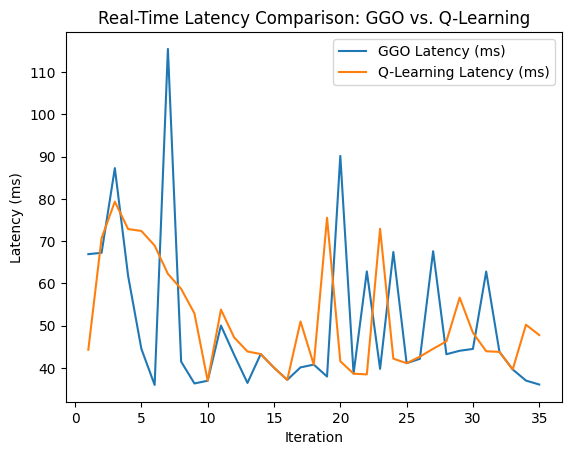

KeyboardInterrupt: 

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Keep track of iteration count and latencies from each method
iteration_list = []
latencies_ggo = []
latencies_q = []

# Initialize iteration counter
iteration = 0

while True:
    # -------------------------------------------------------------------------
    # 1) Simulate real-time updates to the DataFrame
    #    e.g., randomly scale latency values by +/-10%.
    # -------------------------------------------------------------------------
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # -------------------------------------------------------------------------
    # 2) GRAYLAG GOOSE OPTIMIZATION
    #    Rebuild adjacency matrix & run GGO to get best path & latency
    # -------------------------------------------------------------------------
    A, node_to_index, nodes, edge_lookup = build_adjacency_matrix(df, metric='Latency_ms')
    best_path_ggo, best_cost_ggo, cost_history = run_pure_ggo(
        A, node_to_index, nodes,
        test_source_node,
        test_destination_node,
        pop_size=20,
        max_iter=50,
        max_len=5,
        verbose=False
    )
    metrics_ggo = compute_path_metrics(best_path_ggo, edge_lookup, test_destination_node)

    if metrics_ggo:
        total_latency_ggo = metrics_ggo[0]  # total latency
    else:
        total_latency_ggo = None

    # -------------------------------------------------------------------------
    # 3) Q-LEARNING
    #    Create a fresh environment & run Q-learning to get best path & latency
    # -------------------------------------------------------------------------
    env = NetworkRoutingEnv(
        df,
        source=test_source_node,
        destination=test_destination_node,
        metric='Latency_ms'
    )
    q_table = run_qlearning(
        env,
        alpha=0.05,
        gamma=0.79,
        eps_decay=0.85,
        num_episodes=50000,
        min_epsilon=0.01,
        verbose=False
    )
    (best_path_q,
     total_latency_q,
     best_bandwidth_q,
     best_throughput_q,
     avg_jitter_q,
     avg_packet_loss_q) = evaluate_final_path(env, q_table)

    # -------------------------------------------------------------------------
    # 4) Print current iteration’s results (both methods)
    # -------------------------------------------------------------------------
    iteration += 1
    print(f"\n--- Iteration {iteration} ---")

    print("\n[ GGO ]")
    print("Best Path:", best_path_ggo)
    if total_latency_ggo is not None:
        print("Total Latency (ms):", total_latency_ggo)
    else:
        print("Metrics could not be computed for the best GGO path.")

    print("\n[ Q-Learning ]")
    print("Best Path:", best_path_q)
    print("Total Latency (ms):", total_latency_q)

    # -------------------------------------------------------------------------
    # 5) Store latencies for plotting
    # -------------------------------------------------------------------------
    iteration_list.append(iteration)
    latencies_ggo.append(total_latency_ggo if total_latency_ggo else np.nan)
    latencies_q.append(total_latency_q if total_latency_q else np.nan)

    # -------------------------------------------------------------------------
    # 6) Update chart in real-time
    # -------------------------------------------------------------------------
    clear_output(wait=True)  # Clears Jupyter output to update the same cell
    plt.figure()

    plt.plot(iteration_list, latencies_ggo, label='GGO Latency (ms)')
    plt.plot(iteration_list, latencies_q, label='Q-Learning Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: GGO vs. Q-Learning")
    plt.legend()
    plt.show()

    # -------------------------------------------------------------------------
    # 7) Wait before the next simulation update
    #    Adjust the interval as needed
    # -------------------------------------------------------------------------
    time.sleep(1)


# **Real-Time Path Optimization Using Graylag Goose Optimization**
This section demonstrates a real-time simulation for network routing optimization using Graylag Goose Optimization (GGO). The code dynamically adjusts network latency values to simulate changing network conditions and then finds an optimal routing path based on the current state of the network.

**Overview Objective:**

Continuously update the network latency values, run the GGO algorithm on the updated data, and track the best path (with the lowest latency) over a fixed duration.

Key Steps:

**Simulate Network Changes:**

The code randomly scales the latency values (Latency_ms) of the network links to simulate real-time updates.

**Rebuild Network Structures:**
After each update, the adjacency matrix and supporting data structures are rebuilt to reflect the new network state.
**Run GGO Algorithm:**

The GGO algorithm is executed to compute the best routing path and associated metrics (total latency, bottleneck bandwidth, throughput, jitter, and packet loss) based on the current network state.
Track the Overall Best Path:
The simulation compares the current best path with the overall best found during the simulation period and updates the overall best if a lower latency path is discovered.
Timed Simulation:
The simulation runs for a predefined duration (e.g., 10 seconds), updating and printing the best path every second.

In [ ]:
import time
import numpy as np

# Set the overall best metrics to start with.
overall_best_cost = float('inf')
overall_best_path = None
overall_best_metrics = None

# Define the simulation duration (in seconds)
duration = 10
start_time = time.time()

while time.time() - start_time < duration:
    # Simulate realtime updates: adjust latency values randomly.
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # Rebuild the adjacency matrix and supporting structures from the updated DataFrame.
    A, node_to_index, nodes, edge_lookup = build_adjacency_matrix(df, metric='Latency_ms')

    # Run the Graylag Goose Optimization with the updated data.
    best_path, best_cost, cost_history = run_pure_ggo(
        A, node_to_index, nodes, test_source_node, test_destination_node,
        pop_size=20, max_iter=50, max_len=5, verbose=False
    )

    # Compute aggregated metrics along the best path.
    metrics = compute_path_metrics(best_path, edge_lookup, test_destination_node)

    print("\nBest Path:", best_path)
    if metrics:
        print("Total Latency (ms):", metrics[0])
        print("Bottleneck Bandwidth (Mbps):", metrics[1])
        print("Bottleneck Throughput (Mbps):", metrics[2])
        print("Average Jitter (ms):", metrics[3])
        print("Average Packet Loss (%):", metrics[4])
    else:
        print("Metrics could not be computed for the best path.")

    # Update overall best if the current best has lower latency.
    if metrics and metrics[0] < overall_best_cost:
        overall_best_cost = metrics[0]
        overall_best_path = best_path
        overall_best_metrics = metrics

    # Wait for 1 second before the next update.
    time.sleep(1)

# After 5 seconds, print the overall best path and its metrics.
print("\nOverall Best Path:")
print("Best Path:", overall_best_path)
if overall_best_metrics:
    print("Total Latency (ms):", overall_best_metrics[0])
    print("Bottleneck Bandwidth (Mbps):", overall_best_metrics[1])
    print("Bottleneck Throughput (Mbps):", overall_best_metrics[2])
    print("Average Jitter (ms):", overall_best_metrics[3])
    print("Average Packet Loss (%):", overall_best_metrics[4])
else:
    print("No valid path found.")



Best Path: [17, 6]
Total Latency (ms): 35.40325852490511
Bottleneck Bandwidth (Mbps): 846.0
Bottleneck Throughput (Mbps): 660.0
Average Jitter (ms): 30.0
Average Packet Loss (%): 0.14

Best Path: [17, 18, 6]
Total Latency (ms): 55.59795538276471
Bottleneck Bandwidth (Mbps): 309.0
Bottleneck Throughput (Mbps): 181.0
Average Jitter (ms): 28.5
Average Packet Loss (%): 1.48

Best Path: [17, 6]
Total Latency (ms): 36.437489382802625
Bottleneck Bandwidth (Mbps): 846.0
Bottleneck Throughput (Mbps): 660.0
Average Jitter (ms): 30.0
Average Packet Loss (%): 0.14

Best Path: [17, 6, 6]
Total Latency (ms): 33.596832821750475
Bottleneck Bandwidth (Mbps): 846.0
Bottleneck Throughput (Mbps): 660.0
Average Jitter (ms): 30.0
Average Packet Loss (%): 0.14

Best Path: [17, 6]
Total Latency (ms): 36.189475619125645
Bottleneck Bandwidth (Mbps): 846.0
Bottleneck Throughput (Mbps): 660.0
Average Jitter (ms): 30.0
Average Packet Loss (%): 0.14

Best Path: [17, 6]
Total Latency (ms): 39.44010340327795
Bottlen

KeyboardInterrupt: 

# **Hybrid Q-Learning & Graylag Goose Optimization**

This notebook demonstrates a hybrid approach for network routing in which we combine:

A Q-Learning algorithm for reinforcement learning, and
A Graylag Goose Optimization (GGO) algorithm seeded with the path discovered by Q-Learning.
Our objective is to find low-latency paths from a specified source node to a destination node. We measure not only latency but also other metrics like bandwidth, throughput, jitter, and packet loss.

Overview
run_Qlearning(env, ...)

Learns a Q-table mapping each node’s state to the best action (i.e., next hop).
Returns the Q-table after training.
evaluate_final_path(env, q_table)

Uses the final Q-table to construct a path from the source to the destination.
Aggregates metrics (latency, bandwidth, throughput, jitter, packet loss).
run_pure_ggo(...) and run_ggo_with_rl_seed(...)

Implements Graylag Goose Optimization to find a good path using a population-based metaheuristic.
run_ggo_with_rl_seed specifically seeds the GGO population with the path found by Q-Learning to help GGO start in a promising region of the search space.
merged_approach_with_ggo_seed(...)

Ties everything together:
Runs Q-Learning on the environment.
Builds an adjacency matrix from the dataset.
Runs GGO seeded with the Q-Learning path.
Compares the results from both algorithms.

In [ ]:
import numpy as np
import random
import time

# ====================================================================
# 1. Q-learning code
# ====================================================================
env = NetworkRoutingEnv(df, source=test_source_node, destination=test_destination_node, metric='Latency_ms')
def run_Qlearning(env, alpha=0.05, gamma=0.99, eps_decay=0.85,
                  num_episodes=20000, min_epsilon=0.01, verbose=False):
    """
    Standard Q-learning algorithm adapted for NetworkRoutingEnv.
    Returns the learned Q-table.
    """
    # Q-table shape: (number_of_nodes, number_of_actions)
    q_table = np.zeros((env.num_nodes, env.num_nodes))
    epsilon = 0.95

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            state_idx = env.nodes.index(state)

            # Epsilon-greedy action selection
            if random.random() < epsilon:
                valid_actions = [a for a in range(env.num_nodes) if env.nodes[a] != state]
                action = random.choice(valid_actions)
            else:
                # Greedy with respect to Q-table
                action = np.argmax(q_table[state_idx, :])
                # Avoid self-loop if the action points to the same node
                if env.nodes[action] == state:
                    q_table[state_idx, action] = -np.inf
                    action = np.argmax(q_table[state_idx, :])

            next_state, reward, done, _ = env.step(action)
            next_state_idx = env.nodes.index(next_state)

            # Update rule
            td_target = reward + gamma * np.max(q_table[next_state_idx, :])
            td_error = td_target - q_table[state_idx, action]
            q_table[state_idx, action] += alpha * td_error

            state = next_state

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * eps_decay)

        if verbose and (episode + 1) % 5000 == 0:
            print(f"Episode {episode+1}/{num_episodes}")

    return q_table


def evaluate_final_path(env, q_table):
    """
    Constructs the best path from source to destination using a greedy policy based on q_table.
    Also computes aggregated metrics along the path:
      - Total latency (sum of Latency_ms)
      - Bottleneck bandwidth (min of Bandwidth_Mbps)
      - Bottleneck throughput (min of Throughput_Mbps)
      - Average jitter (mean of Jitter_ms)
      - Average packet loss (mean of Packet_Loss_%)

    Returns a tuple:
      (path, total_latency, best_bandwidth, best_throughput, avg_jitter, avg_packet_loss)
    """
    state = env.reset()  # reset environment
    done = False
    path = [state]
    visited = set()
    max_steps = env.num_nodes * 2

    while not done and len(path) < max_steps:
        state_idx = env.nodes.index(state)
        action = np.argmax(q_table[state_idx, :])
        next_node = env.nodes[action]

        # Break if we get stuck in a loop or revisit
        if next_node == state or next_node in visited:
            break

        visited.add(state)
        state, reward, done, _ = env.step(action)
        path.append(state)

    # Compute aggregated metrics along the path
    total_latency = 0
    bandwidths, throughputs, jitters, packet_losses = [], [], [], []
    for i in range(len(path) - 1):
        edge_data = env.edge_lookup.get((path[i], path[i+1]))
        if edge_data:
            total_latency += edge_data['Latency_ms']
            bandwidths.append(edge_data['Bandwidth_Mbps'])
            throughputs.append(edge_data['Throughput_Mbps'])
            jitters.append(edge_data['Jitter_ms'])
            packet_losses.append(edge_data['Packet_Loss_%'])

    best_bandwidth = min(bandwidths) if bandwidths else None
    best_throughput = min(throughputs) if throughputs else None
    avg_jitter = np.mean(jitters) if jitters else None
    avg_packet_loss = np.mean(packet_losses) if packet_losses else None

    return path, total_latency, best_bandwidth, best_throughput, avg_jitter, avg_packet_loss


# ====================================================================
# 2. Graylag Goose Optimization (GGO) code
# ====================================================================
def compute_path_cost(path, adjacency_matrix, dest, node_to_index):
    """
    Compute the total latency (cost) for a given path.
    Returns a high penalty (1e9) if:
      - The path does not end in 'dest'.
      - A node is revisited.
      - Any required edge is missing.
    """
    total = 0
    visited = set()
    if not path or path[-1] != dest:
        return 1e9

    for i in range(len(path) - 1):
        s, d = path[i], path[i+1]
        if s in visited:
            return 1e9
        visited.add(s)

        i_s = node_to_index[s]
        i_d = node_to_index[d]
        if adjacency_matrix[i_s, i_d] == 0 and s != d:
            return 1e9  # no edge in adjacency => invalid
        total += adjacency_matrix[i_s, i_d]

    return total


def generate_random_path(source, destination, adjacency_matrix, node_to_index, nodes, max_len=5):
    """
    Generate a random path from source to destination,
    limited to at most max_len "hops". If the path doesn't
    reach the destination, append it at the end.
    """
    path = [source]
    curr = source
    for _ in range(max_len):
        if curr == destination:
            break
        curr_idx = node_to_index[curr]
        # Find possible next hops (non-zero adjacency & not looping to same node)
        next_hops = [
            nodes[j]
            for j in range(adjacency_matrix.shape[1])
            if adjacency_matrix[curr_idx, j] != 0 and nodes[j] != curr
        ]
        if not next_hops:
            break
        nxt = random.choice(next_hops)
        path.append(nxt)
        curr = nxt

    # Ensure destination is at the end
    if path[-1] != destination:
        path.append(destination)
    return path


def get_best_goose(population, adjacency_matrix, gg_dst, node_to_index):
    """
    Among a list of candidate paths ("population"),
    find and return (best_path, best_cost).
    """
    best_path = None
    best_cost = float('inf')
    for goose in population:
        cost = compute_path_cost(goose, adjacency_matrix, gg_dst, node_to_index)
        if cost < best_cost:
            best_cost = cost
            best_path = goose
    return best_path, best_cost


def goose_movement_path(cur_path, leader_path, adjacency_matrix, gg_dst, node_to_index, nodes):
    """
    Move a 'goose' (current path) closer to the 'leader' (leader_path) by:
      - Randomly swapping a few positions with the leader's path.
      - Potentially mutating one node in the path.
      - Ensuring the last node is always destination.
    """
    newp = cur_path[:]
    len_lead = len(leader_path)
    len_cur = len(cur_path)

    # Randomly pick how many positions we swap
    swap_cnt = random.randint(1, max(1, min(len_lead, len_cur)//2))

    for _ in range(swap_cnt):
        if len_cur > 2:
            idx_c = random.randint(1, len_cur-2)
        else:
            idx_c = 1

        if len_lead > 2:
            idx_l = random.randint(1, len_lead-2)
        else:
            idx_l = 1

        newp[idx_c] = leader_path[idx_l]

    # Random small-chance mutation
    if random.random() < 0.3 and len(newp) > 2:
        idx_mut = random.randint(1, len(newp)-2)
        prv = newp[idx_mut-1]
        i_prv = node_to_index[prv]
        # Next-hops from 'prv'
        nxt_hops = [
            nodes[j]
            for j in range(adjacency_matrix.shape[1])
            if adjacency_matrix[i_prv, j] != 0 and nodes[j] != prv
        ]
        if nxt_hops:
            newp[idx_mut] = random.choice(nxt_hops)

    # Always ensure the path ends at the destination
    if newp[-1] != gg_dst:
        newp[-1] = gg_dst

    return newp


def run_pure_ggo(adjacency_matrix, node_to_index, nodes, gg_src, gg_dst,
                 pop_size=200, max_iter=1000, max_len=5, verbose=True):
    """
    Runs the Graylag Goose Optimization to find a low-latency path.
    Returns (best_path, best_cost, cost_history).
    """
    # 1) Initialize population (all random)
    population = []
    for _ in range(pop_size):
        population.append(generate_random_path(gg_src, gg_dst, adjacency_matrix, node_to_index, nodes, max_len))

    # 2) Evaluate initial population
    best_path, best_cost = get_best_goose(population, adjacency_matrix, gg_dst, node_to_index)
    cost_history = [best_cost]

    # 3) Main GGO loop
    for it in range(max_iter):
        leader, leader_cost = get_best_goose(population, adjacency_matrix, gg_dst, node_to_index)
        new_population = []
        for goose in population:
            if goose == leader:
                # Leader remains unchanged
                new_population.append(goose)
            else:
                # Move goose closer to leader
                updated = goose_movement_path(goose, leader, adjacency_matrix, gg_dst, node_to_index, nodes)
                new_population.append(updated)

        population = new_population

        # Evaluate best goose in new population
        candidate_best_path, candidate_best_cost = get_best_goose(population, adjacency_matrix, gg_dst, node_to_index)
        if candidate_best_cost < best_cost:
            best_path, best_cost = candidate_best_path, candidate_best_cost

        cost_history.append(best_cost)

        if verbose and (it + 1) % 10 == 0:
            print(f"Iteration {it+1}/{max_iter}, Best Latency = {best_cost}")

    return best_path, best_cost, cost_history


def compute_path_metrics(path, edge_lookup, gg_dst):
    """
    Given a path, compute aggregated metrics along that path:
      - total latency
      - bottleneck bandwidth
      - bottleneck throughput
      - average jitter
      - average packet loss
    Returns a tuple (latency, bw, throughput, jitter, packet_loss).
    """
    if not path or path[-1] != gg_dst:
        return None

    total_latency = 0
    bandwidths, throughputs, jitters, packet_losses = [], [], [], []

    for i in range(len(path) - 1):
        edge = (path[i], path[i + 1])
        if edge in edge_lookup:
            data = edge_lookup[edge]
            total_latency += data['Latency_ms']
            bandwidths.append(data['Bandwidth_Mbps'])
            throughputs.append(data['Throughput_Mbps'])
            jitters.append(data['Jitter_ms'])
            packet_losses.append(data['Packet_Loss_%'])

    best_bandwidth = min(bandwidths) if bandwidths else None
    best_throughput = min(throughputs) if throughputs else None
    avg_jitter = np.mean(jitters) if jitters else None
    avg_packet_loss = np.mean(packet_losses) if packet_losses else None

    return total_latency, best_bandwidth, best_throughput, avg_jitter, avg_packet_loss


# ====================================================================
# 3. GGO with RL Path Seeding
# ====================================================================
def run_ggo_with_rl_seed(adjacency_matrix, node_to_index, nodes, gg_src, gg_dst,
                         rl_path, pop_size=200, max_iter=1000, max_len=5, verbose=True):
    """
    Similar to run_pure_ggo, but we "seed" the population with the Q-learning path.
    That is, the RL path is included in the initial population, so GGO can refine it.
    """
    population = []
    # 1) Insert the RL-based path as the first goose
    population.append(rl_path)

    # 2) Fill the rest of the population with random paths
    for _ in range(pop_size - 1):
        population.append(generate_random_path(gg_src, gg_dst, adjacency_matrix, node_to_index, nodes, max_len))

    best_path, best_cost = get_best_goose(population, adjacency_matrix, gg_dst, node_to_index)
    cost_history = [best_cost]

    for it in range(max_iter):
        leader, leader_cost = get_best_goose(population, adjacency_matrix, gg_dst, node_to_index)
        new_population = []
        for goose in population:
            if goose == leader:
                # Keep the leader as is
                new_population.append(goose)
            else:
                updated = goose_movement_path(goose, leader, adjacency_matrix, gg_dst, node_to_index, nodes)
                new_population.append(updated)

        population = new_population

        candidate_best_path, candidate_best_cost = get_best_goose(population, adjacency_matrix, gg_dst, node_to_index)
        if candidate_best_cost < best_cost:
            best_path, best_cost = candidate_best_path, candidate_best_cost

        cost_history.append(best_cost)

        if verbose and (it + 1) % 10 == 0:
            print(f"Iteration {it+1}/{max_iter}, Best Latency = {best_cost}")

    return best_path, best_cost, cost_history


# ====================================================================
# 4. Merge everything into a demonstration
# ====================================================================
def merged_approach_with_ggo_seed(df, env, source, destination,
                                  pop_size=20, max_iter=50, max_len=5):
    """
    1) Run Q-learning to get an RL path.
    2) Build adjacency matrix from df.
    3) Run GGO *seeded* with that RL path.
    4) Compare results.
    """
    print("=== Running Q-Learning ===")
    q_table = run_Qlearning(env, alpha=0.05, gamma=0.99, eps_decay=0.85,
                            num_episodes=5000, min_epsilon=0.01, verbose=False)
    q_path, q_latency, q_bw, q_thr, q_jit, q_pl = evaluate_final_path(env, q_table)

    print("\n[Q-Learning Results]")
    print("Q-Learning Path:", q_path)
    print(f"Total Latency = {q_latency}, Bottleneck BW = {q_bw}, Throughput = {q_thr}, "
          f"Avg Jitter = {q_jit}, Avg Pkt Loss = {q_pl}")

    # Build adjacency matrix & supporting structures
    A, node_to_index, nodes, edge_lookup = build_adjacency_matrix(df, metric='Latency_ms')

    # We must ensure the RL path is suitable for GGO's adjacency checks.
    # If the RL path has any invalid edges, GGO can still skip them with a high penalty.
    # For seeding, we'll just pass the RL path as-is.

    print("\n=== Running GGO with RL-Path Seeding ===")
    best_path_seeded, best_cost_seeded, cost_hist_seeded = run_ggo_with_rl_seed(
        adjacency_matrix=A,
        node_to_index=node_to_index,
        nodes=nodes,
        gg_src=source,
        gg_dst=destination,
        rl_path=q_path,            # <--- The RL path is seeded here
        pop_size=pop_size,
        max_iter=max_iter,
        max_len=max_len,
        verbose=False
    )
    # Evaluate metrics of GGO-seeded path
    ggo_metrics = compute_path_metrics(best_path_seeded, edge_lookup, destination)

    print("\n[GGO (Seeded) Results]")
    print("GGO Best Path:", best_path_seeded)
    if ggo_metrics:
        lat_ggo, bw_ggo, thr_ggo, jit_ggo, pl_ggo = ggo_metrics
        print(f"Total Latency = {lat_ggo}, Bottleneck BW = {bw_ggo}, "
              f"Throughput = {thr_ggo}, Avg Jitter = {jit_ggo}, Packet Loss = {pl_ggo}")
    else:
        print("No valid path found by seeded GGO or metrics could not be computed.")

    # Compare final latencies
    if ggo_metrics and ggo_metrics[0] < q_latency:
        print("\n[GGO (seeded) found a better path than Q-Learning!]")
    else:
        print("\n[Q-Learning path was better or GGO path invalid.]")

    return {
        "q_path": q_path,
        "q_metrics": (q_latency, q_bw, q_thr, q_jit, q_pl),
        "ggo_path": best_path_seeded,
        "ggo_metrics": ggo_metrics
    }





In [ ]:
results = merged_approach_with_ggo_seed(
        df=df,
        env=env,
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,     # example
        max_iter=50,     # example
        max_len=5        # example
    )


    # 4) Print the results in a readable way
print("\n===== FINAL RESULTS =====\n")

print("Q-Learning Path:")
print("   ", results["q_path"])

q_latency, q_bw, q_thr, q_jit, q_pl = results["q_metrics"]
print(f"Q-Learning Metrics:")
print(f"   Total Latency = {q_latency}")
print(f"   Bottleneck BW (Mbps) = {q_bw}")
print(f"   Bottleneck Throughput (Mbps) = {q_thr}")
print(f"   Avg Jitter (ms) = {q_jit}")
print(f"   Avg Packet Loss (%) = {q_pl}")

print("\nGGO (Seeded) Path:")
print("   ", results["ggo_path"])
if results["ggo_metrics"]:
        lat_ggo, bw_ggo, thr_ggo, jit_ggo, pl_ggo = results["ggo_metrics"]
        print(f"GGO (Seeded) Metrics:")
        print(f"   Total Latency = {lat_ggo}")
        print(f"   Bottleneck BW (Mbps) = {bw_ggo}")
        print(f"   Bottleneck Throughput (Mbps) = {thr_ggo}")
        print(f"   Avg Jitter (ms) = {jit_ggo}")
        print(f"   Avg Packet Loss (%) = {pl_ggo}")
else:
        print("   No valid path found by GGO or metrics could not be computed.")

=== Running Q-Learning ===

[Q-Learning Results]
Q-Learning Path: [17, 6]
Total Latency = 47.418576625220986, Bottleneck BW = 846.0, Throughput = 660.0, Avg Jitter = 30.0, Avg Pkt Loss = 0.14

=== Running GGO with RL-Path Seeding ===

[GGO (Seeded) Results]
GGO Best Path: [17, 6]
Total Latency = 47.418576625220986, Bottleneck BW = 846.0, Throughput = 660.0, Avg Jitter = 30.0, Packet Loss = 0.14

[Q-Learning path was better or GGO path invalid.]

===== FINAL RESULTS =====

Q-Learning Path:
    [17, 6]
Q-Learning Metrics:
   Total Latency = 47.418576625220986
   Bottleneck BW (Mbps) = 846.0
   Bottleneck Throughput (Mbps) = 660.0
   Avg Jitter (ms) = 30.0
   Avg Packet Loss (%) = 0.14

GGO (Seeded) Path:
    [17, 6]
GGO (Seeded) Metrics:
   Total Latency = 47.418576625220986
   Bottleneck BW (Mbps) = 846.0
   Bottleneck Throughput (Mbps) = 660.0
   Avg Jitter (ms) = 30.0
   Avg Packet Loss (%) = 0.14


# Real-Time Latency Comparison: Q-Learning vs. GGO(Seeded)

Below is a Python script that:
1. Updates a DataFrame's latency values in real-time.
2. Runs both Q-Learning and GGO(Seeded) to determine the best path.
3. Extracts latency metrics from each method.
4. Plots the latencies of both methods over time.

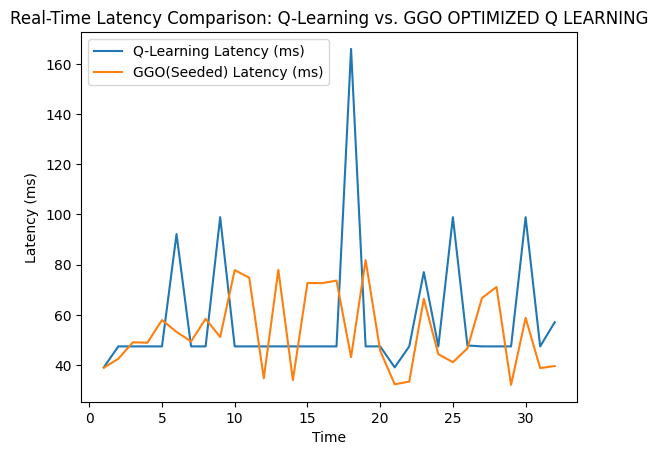

KeyboardInterrupt: 

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Lists to store iteration counts and latencies
iteration_list = []
latencies_q = []
latencies_ggo = []

iteration = 0

# Start the real-time simulation loop
while True:
    # 1) Simulate real-time updates to the DataFrame
    #    e.g., randomly scale Latency by +/-10%
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # 2) Call the merged approach that runs Q-Learning and GGO(Seeded) internally
    #    This function is assumed to return a dictionary with keys:
    #      "q_path", "q_metrics" -> (q_latency, q_bw, q_thr, q_jit, q_pl)
    #      "ggo_path", "ggo_metrics" -> (lat_ggo, bw_ggo, thr_ggo, jit_ggo, pl_ggo)
    results = merged_approach_with_ggo_seed(
        df=df,
        env=env,  # existing environment or environment builder (as needed)
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,   # example
        max_iter=50,   # example
        max_len=5      # example
    )

    # 3) Extract the metrics for Q-Learning
    q_latency, q_bw, q_thr, q_jit, q_pl = results["q_metrics"]

    # 4) Extract the metrics for GGO(Seeded)
    if results["ggo_metrics"] is not None:
        lat_ggo, bw_ggo, thr_ggo, jit_ggo, pl_ggo = results["ggo_metrics"]
    else:
        lat_ggo = None  # No valid path or metrics from GGO

    # 5) Print the results for this iteration
    iteration += 1
    print(f"\n===== Iteration {iteration} =====\n")
    print("Q-Learning Path:")
    print("   ", results["q_path"])
    print("Q-Learning Metrics:")
    print(f"   Total Latency = {q_latency}")
    print(f"   Bottleneck BW (Mbps) = {q_bw}")
    print(f"   Bottleneck Throughput (Mbps) = {q_thr}")
    print(f"   Avg Jitter (ms) = {q_jit}")
    print(f"   Avg Packet Loss (%) = {q_pl}")

    print("\nGGO (Seeded) Path:")
    print("   ", results["ggo_path"])
    if lat_ggo is not None:
        print("GGO (Seeded) Metrics:")
        print(f"   Total Latency = {lat_ggo}")
        print(f"   Bottleneck BW (Mbps) = {bw_ggo}")
        print(f"   Bottleneck Throughput (Mbps) = {thr_ggo}")
        print(f"   Avg Jitter (ms) = {jit_ggo}")
        print(f"   Avg Packet Loss (%) = {pl_ggo}")
    else:
        print("   No valid path found or metrics could not be computed.")

    # 6) Store latencies for real-time plotting
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_ggo.append(lat_ggo if lat_ggo else np.nan)

    # 7) Update a real-time chart for latency comparison
    clear_output(wait=True)  # For Jupyter: clears the cell output so the plot can refresh
    plt.figure()
    plt.plot(iteration_list, latencies_q, label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_ggo, label='GGO(Seeded) Latency (ms)')
    plt.xlabel("Time")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: Q-Learning vs. GGO OPTIMIZED Q LEARNING")
    plt.legend()
    plt.show()

    # 8) Wait before the next iteration (adjust as needed)
    time.sleep(1)


# **COMPARISSON WITH OTHER METAHEURISTIC ALGORITHMS**

# 1 Grey Wolf Optimizer (GWO)

*1.1 Pure GWO*

In [ ]:
def run_pure_gwo(adjacency_matrix, node_to_index, nodes, gwo_src, gwo_dst,
                 pop_size=20, max_iter=50, max_len=5, verbose=True):
    """
    Discrete Grey Wolf Optimizer to find a low-latency path.
    Returns (best_path, best_cost, cost_history).
    """

    # 1) Initialize population with random paths
    population = [
        generate_random_path(gwo_src, gwo_dst, adjacency_matrix, node_to_index, nodes, max_len)
        for _ in range(pop_size)
    ]

    # 2) Evaluate population
    costs = [compute_path_cost(p, adjacency_matrix, gwo_dst, node_to_index) for p in population]

    # 3) Identify alpha, beta, delta (best three)
    def update_leaders(pop, costs):
        sorted_indices = sorted(range(len(pop)), key=lambda i: costs[i])
        alpha_idx = sorted_indices[0]
        beta_idx = sorted_indices[1] if len(sorted_indices) > 1 else alpha_idx
        delta_idx = sorted_indices[2] if len(sorted_indices) > 2 else beta_idx
        return alpha_idx, beta_idx, delta_idx

    alpha_idx, beta_idx, delta_idx = update_leaders(population, costs)
    best_path = population[alpha_idx]
    best_cost = costs[alpha_idx]
    cost_history = [best_cost]

    # 4) Main loop
    for iteration in range(max_iter):
        # The a parameter decreases linearly from 2 -> 0
        a = 2 - 2 * (iteration / float(max_iter))

        for i in range(pop_size):
            if i in (alpha_idx, beta_idx, delta_idx):
                # Leaders remain as is (or we could skip)
                continue

            # Perform discrete 'hunt' steps: each wolf is updated w.r.t alpha, beta, delta
            new_path = population[i][:]  # copy
            for j in range(1, len(new_path) - 1):
                # compute random coefs
                r1 = random.random()
                r2 = random.random()
                A1 = 2 * a * r1 - a
                C1 = 2 * r2

                r3 = random.random()
                r4 = random.random()
                A2 = 2 * a * r3 - a
                C2 = 2 * r4

                r5 = random.random()
                r6 = random.random()
                A3 = 2 * a * r5 - a
                C3 = 2 * r6

                # discrete approach: pick from alpha/beta/delta positions if A < 1
                # fallback is keep current

                # alpha influence
                alpha_pos = population[alpha_idx][j] if j < len(population[alpha_idx]) else new_path[j]
                if abs(A1) < 1 and random.random() < 0.33:
                    new_path[j] = alpha_pos

                # beta influence
                beta_pos = population[beta_idx][j] if j < len(population[beta_idx]) else new_path[j]
                if abs(A2) < 1 and random.random() < 0.33:
                    new_path[j] = beta_pos

                # delta influence
                delta_pos = population[delta_idx][j] if j < len(population[delta_idx]) else new_path[j]
                if abs(A3) < 1 and random.random() < 0.33:
                    new_path[j] = delta_pos

            # small chance random mutation
            if random.random() < 0.3:
                idx_mut = random.randint(1, len(new_path) - 2)
                prv = new_path[idx_mut - 1]
                i_prv = node_to_index[prv]
                possible_hops = [
                    nodes[k]
                    for k in range(adjacency_matrix.shape[1])
                    if adjacency_matrix[i_prv, k] != 0 and nodes[k] != prv
                ]
                if possible_hops:
                    new_path[idx_mut] = random.choice(possible_hops)

            # ensure last is destination
            new_path[-1] = gwo_dst

            new_cost = compute_path_cost(new_path, adjacency_matrix, gwo_dst, node_to_index)
            if new_cost < costs[i]:
                population[i] = new_path
                costs[i] = new_cost

        # update alpha, beta, delta
        alpha_idx, beta_idx, delta_idx = update_leaders(population, costs)
        if costs[alpha_idx] < best_cost:
            best_path = population[alpha_idx]
            best_cost = costs[alpha_idx]

        cost_history.append(best_cost)

        if verbose and (iteration + 1) % 10 == 0:
            print(f"GWO Iteration {iteration+1}/{max_iter}, Best Cost = {best_cost}")

    return best_path, best_cost, cost_history


*1.2 GWO With RL Seeding*

In [ ]:
def run_gwo_with_rl_seed(adjacency_matrix, node_to_index, nodes, gwo_src, gwo_dst,
                         rl_path, pop_size=20, max_iter=50, max_len=5, verbose=True):
    """
    Same as run_pure_gwo, but we insert the RL path as the first solution.
    """
    # 1) Initialize population
    population = [rl_path]  # seed with RL path
    for _ in range(pop_size - 1):
        population.append(generate_random_path(gwo_src, gwo_dst, adjacency_matrix, node_to_index, nodes, max_len))

    # 2) Evaluate
    costs = [compute_path_cost(p, adjacency_matrix, gwo_dst, node_to_index) for p in population]

    # helper to find alpha,beta,delta
    def update_leaders(pop, cs):
        idx = sorted(range(len(pop)), key=lambda i: cs[i])
        alpha_i = idx[0]
        beta_i = idx[1] if len(idx) > 1 else alpha_i
        delta_i = idx[2] if len(idx) > 2 else beta_i
        return alpha_i, beta_i, delta_i

    alpha_idx, beta_idx, delta_idx = update_leaders(population, costs)
    best_path = population[alpha_idx]
    best_cost = costs[alpha_idx]
    cost_history = [best_cost]

    # main loop
    for iteration in range(max_iter):
        a = 2 - 2 * (iteration / float(max_iter))
        for i in range(pop_size):
            if i in (alpha_idx, beta_idx, delta_idx):
                continue

            new_path = population[i][:]
            for j in range(1, len(new_path) - 1):
                r1, r2, r3, r4, r5, r6 = [random.random() for _ in range(6)]
                A1 = 2 * a * r1 - a
                A2 = 2 * a * r3 - a
                A3 = 2 * a * r5 - a

                if abs(A1) < 1 and random.random() < 0.33:
                    if j < len(population[alpha_idx]):
                        new_path[j] = population[alpha_idx][j]
                if abs(A2) < 1 and random.random() < 0.33:
                    if j < len(population[beta_idx]):
                        new_path[j] = population[beta_idx][j]
                if abs(A3) < 1 and random.random() < 0.33:
                    if j < len(population[delta_idx]):
                        new_path[j] = population[delta_idx][j]

            # mutation

            # mutation
            if len(new_path) > 2 and random.random() < 0.3:
              idx_mut = random.randint(1, len(new_path) - 2)
              prv = new_path[idx_mut - 1]
              i_prv = node_to_index[prv]
              possible_hops = [
                  nodes[k]
                  for k in range(adjacency_matrix.shape[1])
                  if adjacency_matrix[i_prv, k] != 0 and nodes[k] != prv
             ]
              if possible_hops:
                  new_path[idx_mut] = random.choice(possible_hops)


            new_path[-1] = gwo_dst
            new_cost = compute_path_cost(new_path, adjacency_matrix, gwo_dst, node_to_index)
            if new_cost < costs[i]:
                population[i] = new_path
                costs[i] = new_cost

        alpha_idx, beta_idx, delta_idx = update_leaders(population, costs)
        if costs[alpha_idx] < best_cost:
            best_path = population[alpha_idx]
            best_cost = costs[alpha_idx]

        cost_history.append(best_cost)
        if verbose and (iteration + 1) % 10 == 0:
            print(f"GWO (seed) Iter {iteration+1}/{max_iter}, Best = {best_cost}")

    return best_path, best_cost, cost_history


*1.3 Merged Approach With GWO*

In [ ]:
def merged_approach_with_gwo_seed(df, env, source, destination,
                                  pop_size=20, max_iter=50, max_len=5):
    """
    1) Run Q-learning to get an RL path.
    2) Build adjacency matrix.
    3) Run GWO seeded with RL path.
    4) Compare results.
    """
    print("=== Running Q-Learning ===")
    q_table = run_Qlearning(env, alpha=0.05, gamma=0.99, eps_decay=0.85,
                            num_episodes=5000, min_epsilon=0.01, verbose=False)
    q_path, q_latency, q_bw, q_thr, q_jit, q_pl = evaluate_final_path(env, q_table)

    print("\n[Q-Learning Results]")
    print("Q-Learning Path:", q_path)
    print(f"Total Latency = {q_latency}, BW = {q_bw}, Thru = {q_thr}, Jitter = {q_jit}, Loss = {q_pl}")

    A, node_to_index, nodes, edge_lookup = build_adjacency_matrix(df, metric='Latency_ms')

    print("\n=== Running GWO (Seeded) ===")
    gwo_path, gwo_cost, gwo_hist = run_gwo_with_rl_seed(
        A, node_to_index, nodes, source, destination,
        rl_path=q_path,
        pop_size=pop_size,
        max_iter=max_iter,
        max_len=max_len,
        verbose=False
    )
    gwo_metrics = compute_path_metrics(gwo_path, edge_lookup, destination)
    print("\n[GWO (Seeded) Results]")
    print("GWO Best Path:", gwo_path)
    if gwo_metrics:
        lat_gwo, bw_gwo, thr_gwo, jit_gwo, pl_gwo = gwo_metrics
        print(f"Total Latency = {lat_gwo}, BW = {bw_gwo}, Thru = {thr_gwo}, Jitter = {jit_gwo}, Loss = {pl_gwo}")
    else:
        print("No valid path found by GWO or metrics invalid.")

    if gwo_metrics and gwo_metrics[0] < q_latency:
        print("\n[GWO (seeded) found a better path than Q-Learning!]")
    else:
        print("\n[Q-Learning path was better or GWO path invalid.]")

    return {
        "q_path": q_path,
        "q_metrics": (q_latency, q_bw, q_thr, q_jit, q_pl),
        "gwo_path": gwo_path,
        "gwo_metrics": gwo_metrics
    }


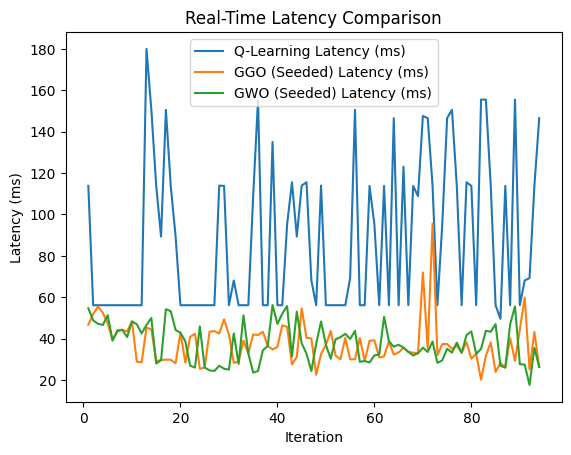

=== Running Q-Learning ===

[Q-Learning Results]
Q-Learning Path: [14, 20, 19]
Total Latency = 98.75998119836441, Bottleneck BW = 22.0, Throughput = -77.0, Avg Jitter = 23.5, Avg Pkt Loss = 1.805

=== Running GGO with RL-Path Seeding ===

[GGO (Seeded) Results]
GGO Best Path: [14, 20, 19]
Total Latency = 58.53800246937874, Bottleneck BW = 22.0, Throughput = -77.0, Avg Jitter = 23.5, Packet Loss = 1.805

[GGO (seeded) found a better path than Q-Learning!]
=== Running Q-Learning ===


KeyboardInterrupt: 

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Lists to store iteration counts and latency values from each method
iteration_list = []
latencies_q = []      # Q-Learning latency
latencies_ggo = []    # GGO (Seeded) latency
latencies_gwo = []    # GWO (Seeded) latency

iteration = 0

# Start the real-time simulation loop
while True:
    # -------------------------------------------------------------------------
    # 1) Simulate real-time updates to the DataFrame
    #    For example, randomly scale latency values by +/-10%
    # -------------------------------------------------------------------------
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # -------------------------------------------------------------------------
    # 2) Run the merged approach with GGO seeding
    # -------------------------------------------------------------------------
    results_ggo = merged_approach_with_ggo_seed(
        df=df,
        env=env,  # Existing environment or a builder function
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,   # Example parameter
        max_iter=50,   # Example parameter
        max_len=5      # Example parameter
    )

    # -------------------------------------------------------------------------
    # 3) Run the merged approach with GWO seeding
    # -------------------------------------------------------------------------
    results_gwo = merged_approach_with_gwo_seed(
        df=df,
        env=env,  # Existing environment or a builder function
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,   # Example parameter
        max_iter=50,   # Example parameter
        max_len=8      # Example parameter
    )

    # -------------------------------------------------------------------------
    # 4) Extract latency metrics from both merged approaches
    # -------------------------------------------------------------------------
    # Q-Learning latency (from either result; they both run Q-Learning)
    q_latency = results_ggo["q_metrics"][0]

    # GGO (Seeded) latency
    ggo_metrics = results_ggo["ggo_metrics"]
    ggo_latency = ggo_metrics[0] if ggo_metrics is not None else np.nan

    # GWO (Seeded) latency
    gwo_metrics = results_gwo["gwo_metrics"]
    gwo_latency = gwo_metrics[0] if gwo_metrics is not None else np.nan

    # -------------------------------------------------------------------------
    # 5) Print the current iteration's results
    # -------------------------------------------------------------------------
    iteration += 1
    print(f"\n===== Iteration {iteration} =====\n")
    print("Q-Learning Path:")
    print("   ", results_ggo["q_path"])
    print("Q-Learning Metrics:")
    print(f"   Total Latency = {q_latency}")

    print("\nGGO (Seeded) Path:")
    print("   ", results_ggo["ggo_path"])
    if ggo_latency is not None:
        print("GGO (Seeded) Metrics:")
        print(f"   Total Latency = {ggo_latency}")
    else:
        print("   No valid GGO path found or metrics could not be computed.")

    print("\nGWO (Seeded) Path:")
    print("   ", results_gwo["gwo_path"])
    if gwo_latency is not None:
        print("GWO (Seeded) Metrics:")
        print(f"   Total Latency = {gwo_latency}")
    else:
        print("   No valid GWO path found or metrics could not be computed.")

    # -------------------------------------------------------------------------
    # 6) Store latencies for real-time plotting
    # -------------------------------------------------------------------------
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_ggo.append(ggo_latency if ggo_latency else np.nan)
    latencies_gwo.append(gwo_latency if gwo_latency else np.nan)

    # -------------------------------------------------------------------------
    # 7) Update the real-time latency chart
    # -------------------------------------------------------------------------
    clear_output(wait=True)  # Clears previous output in Jupyter to refresh the plot
    plt.figure()
    plt.plot(iteration_list, latencies_q, label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_ggo, label='GGO (Seeded) Latency (ms)')
    plt.plot(iteration_list, latencies_gwo, label='GWO (Seeded) Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison")
    plt.legend()
    plt.show()

    # -------------------------------------------------------------------------
    # 8) Wait before the next iteration (adjust interval as needed)
    # -------------------------------------------------------------------------
    time.sleep(1)

# **2 Genetic Algorithm (GA)**

*2.1 Pure GA*

In [ ]:

def crossover_paths(path1, path2):
    """
    Simple single-point crossover for demonstration.
    Assume same length for simplicity.
    If different lengths, you'd handle carefully or unify length via max_len.
    """
    min_len = min(len(path1), len(path2))
    if min_len < 2:
        return path1[:], path2[:]
    cx_point = random.randint(1, min_len - 1)
    child1 = path1[:cx_point] + path2[cx_point:]
    child2 = path2[:cx_point] + path1[cx_point:]
    return child1, child2

def mutate_path(path, adjacency_matrix, node_to_index, nodes, mutation_rate=0.3):
    newp = path[:]
    if random.random() < mutation_rate and len(newp) > 2:
        idx_mut = random.randint(1, len(newp) - 2)
        prv = newp[idx_mut - 1]
        i_prv = node_to_index[prv]
        possible = [
            nodes[k]
            for k in range(adjacency_matrix.shape[1])
            if adjacency_matrix[i_prv, k] != 0 and nodes[k] != prv
        ]
        if possible:
            newp[idx_mut] = random.choice(possible)
    return newp

def run_pure_ga(adjacency_matrix, node_to_index, nodes, ga_src, ga_dst,
                pop_size=20, max_iter=50, max_len=5, crossover_rate=0.7,
                mutation_rate=0.3, verbose=True):
    """
    Simple Genetic Algorithm for path finding.
    """

    # 1) Initialize population
    population = [
        generate_random_path(ga_src, ga_dst, adjacency_matrix, node_to_index, nodes, max_len)
        for _ in range(pop_size)
    ]
    # Evaluate
    costs = [compute_path_cost(p, adjacency_matrix, ga_dst, node_to_index) for p in population]

    # track best
    best_idx = np.argmin(costs)
    best_path = population[best_idx]
    best_cost = costs[best_idx]
    cost_history = [best_cost]

    # 2) GA loop
    for iteration in range(max_iter):
        new_population = []

        # selection + crossover
        while len(new_population) < pop_size:
            # simple tournament selection
            i1, i2 = random.sample(range(pop_size), 2)
            p1 = population[i1] if costs[i1] < costs[i2] else population[i2]

            j1, j2 = random.sample(range(pop_size), 2)
            p2 = population[j1] if costs[j1] < costs[j2] else population[j2]

            if random.random() < crossover_rate:
                c1, c2 = crossover_paths(p1, p2)
            else:
                c1, c2 = p1[:], p2[:]

            # mutate
            c1 = mutate_path(c1, adjacency_matrix, node_to_index, nodes, mutation_rate)
            c2 = mutate_path(c2, adjacency_matrix, node_to_index, nodes, mutation_rate)

            # ensure last node is ga_dst
            c1[-1] = ga_dst
            c2[-1] = ga_dst

            new_population.append(c1)
            if len(new_population) < pop_size:
                new_population.append(c2)

        population = new_population
        costs = [compute_path_cost(p, adjacency_matrix, ga_dst, node_to_index) for p in population]

        # update best
        current_best_idx = np.argmin(costs)
        if costs[current_best_idx] < best_cost:
            best_cost = costs[current_best_idx]
            best_path = population[current_best_idx]

        cost_history.append(best_cost)
        if verbose and (iteration + 1) % 10 == 0:
            print(f"GA Iteration {iteration+1}/{max_iter}, Best Cost = {best_cost}")

    return best_path, best_cost, cost_history


*2.2 GA With RL Seeding*

In [ ]:
def run_ga_with_rl_seed(adjacency_matrix, node_to_index, nodes, ga_src, ga_dst,
                        rl_path, pop_size=20, max_iter=50, max_len=5,
                        crossover_rate=0.7, mutation_rate=0.3, verbose=True):
    """
    GA, but seed initial population with RL path.
    """
    population = [rl_path]
    for _ in range(pop_size - 1):
        population.append(generate_random_path(ga_src, ga_dst, adjacency_matrix, node_to_index, nodes, max_len))

    costs = [compute_path_cost(p, adjacency_matrix, ga_dst, node_to_index) for p in population]
    best_idx = np.argmin(costs)
    best_path = population[best_idx]
    best_cost = costs[best_idx]
    cost_history = [best_cost]

    for iteration in range(max_iter):
        new_population = []
        while len(new_population) < pop_size:
            i1, i2 = random.sample(range(pop_size), 2)
            p1 = population[i1] if costs[i1] < costs[i2] else population[i2]

            j1, j2 = random.sample(range(pop_size), 2)
            p2 = population[j1] if costs[j1] < costs[j2] else population[j2]

            if random.random() < crossover_rate:
                c1, c2 = crossover_paths(p1, p2)
            else:
                c1, c2 = p1[:], p2[:]

            c1 = mutate_path(c1, adjacency_matrix, node_to_index, nodes, mutation_rate)
            c2 = mutate_path(c2, adjacency_matrix, node_to_index, nodes, mutation_rate)
            c1[-1] = ga_dst
            c2[-1] = ga_dst

            new_population.append(c1)
            if len(new_population) < pop_size:
                new_population.append(c2)

        population = new_population
        costs = [compute_path_cost(p, adjacency_matrix, ga_dst, node_to_index) for p in population]
        current_best_idx = np.argmin(costs)
        if costs[current_best_idx] < best_cost:
            best_cost = costs[current_best_idx]
            best_path = population[current_best_idx]

        cost_history.append(best_cost)
        if verbose and (iteration + 1) % 10 == 0:
            print(f"GA (seed) Iter {iteration+1}/{max_iter}, Best = {best_cost}")

    return best_path, best_cost, cost_history


*2.3 Merged Approach With GA. GA Optimized RL*

In [ ]:
def merged_approach_with_ga_seed(df, env, source, destination,
                                 pop_size=20, max_iter=50, max_len=5):
    print("=== Running Q-Learning ===")
    q_table = run_Qlearning(env, alpha=0.05, gamma=0.99, eps_decay=0.85,
                            num_episodes=5000, min_epsilon=0.01, verbose=False)
    q_path, q_latency, q_bw, q_thr, q_jit, q_pl = evaluate_final_path(env, q_table)

    print("\n[Q-Learning Results]")
    print("Path:", q_path)
    print(f"Latency={q_latency}, BW={q_bw}, Thr={q_thr}, Jit={q_jit}, Loss={q_pl}")

    A, node_to_index, nodes, edge_lookup = build_adjacency_matrix(df, metric='Latency_ms')

    print("\n=== Running GA (Seeded) ===")
    ga_path, ga_cost, ga_hist = run_ga_with_rl_seed(
        A, node_to_index, nodes, source, destination,
        rl_path=q_path,
        pop_size=pop_size,
        max_iter=max_iter,
        max_len=max_len,
        verbose=False
    )
    ga_metrics = compute_path_metrics(ga_path, edge_lookup, destination)
    print("\n[GA (Seeded) Results]")
    print("GA Best Path:", ga_path)
    if ga_metrics:
        lat_ga, bw_ga, thr_ga, jit_ga, pl_ga = ga_metrics
        print(f"Latency={lat_ga}, BW={bw_ga}, Thr={thr_ga}, Jit={jit_ga}, Loss={pl_ga}")
    else:
        print("No valid path found by GA or metrics invalid.")

    if ga_metrics and ga_metrics[0] < q_latency:
        print("\n[GA found a better path than Q-Learning!]")
    else:
        print("\n[Q-Learning was better or GA invalid.]")

    return {
        "q_path": q_path,
        "q_metrics": (q_latency, q_bw, q_thr, q_jit, q_pl),
        "ga_path": ga_path,
        "ga_metrics": ga_metrics
    }


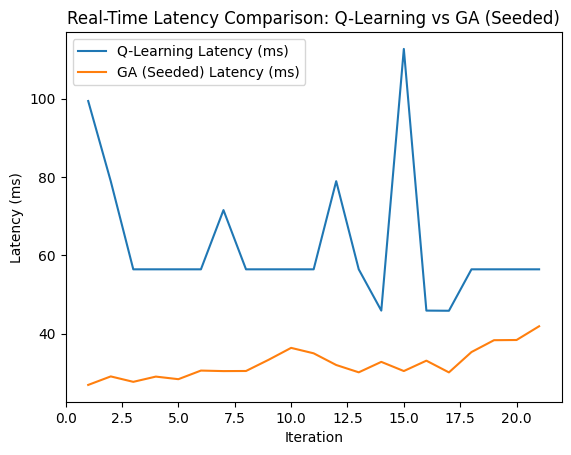

KeyboardInterrupt: 

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Lists to store iteration counts and latency values from each method
iteration_list = []
latencies_q = []   # Q-Learning latency (baseline)
latencies_ga = []  # GA (Seeded) latency

iteration = 0

while True:
    # -------------------------------------------------------------------------
    # 1) Simulate real-time updates to the DataFrame
    #    For example, randomly scale latency values by +/-10%
    # -------------------------------------------------------------------------
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # -------------------------------------------------------------------------
    # 2) Run the merged approach with GA seeding
    # -------------------------------------------------------------------------
    results_ga = merged_approach_with_ga_seed(
        df=df,
        env=env,  # Existing environment or a builder function
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,   # Example parameter
        max_iter=50,   # Example parameter
        max_len=5      # Example parameter
    )

    # -------------------------------------------------------------------------
    # 3) Extract latency metrics from the GA seeded approach
    # -------------------------------------------------------------------------
    # Q-Learning latency is used as baseline (both GA and Q-Learning are run)
    q_latency = results_ga["q_metrics"][0]

    # GA (Seeded) latency is computed from the GA method
    ga_metrics = results_ga["ga_metrics"]
    ga_latency = ga_metrics[0] if ga_metrics is not None else np.nan

    # -------------------------------------------------------------------------
    # 4) Print the current iteration's results
    # -------------------------------------------------------------------------
    iteration += 1
    print(f"\n===== Iteration {iteration} =====\n")
    print("Q-Learning Path:")
    print("   ", results_ga["q_path"])
    print("Q-Learning Metrics:")
    print(f"   Total Latency = {q_latency}")

    print("\nGA (Seeded) Path:")
    print("   ", results_ga["ga_path"])
    if ga_latency is not None:
        print("GA (Seeded) Metrics:")
        print(f"   Total Latency = {ga_latency}")
    else:
        print("   No valid GA path found or metrics could not be computed.")

    # -------------------------------------------------------------------------
    # 5) Store latencies for real-time plotting
    # -------------------------------------------------------------------------
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_ga.append(ga_latency if ga_latency else np.nan)

    # -------------------------------------------------------------------------
    # 6) Update the real-time latency chart
    # -------------------------------------------------------------------------
    clear_output(wait=True)  # Clears previous output to refresh the plot
    plt.figure()
    plt.plot(iteration_list, latencies_q, label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_ga, label='GA (Seeded) Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: Q-Learning vs GA (Seeded)")
    plt.legend()
    plt.show()

    # -------------------------------------------------------------------------
    # 7) Wait before the next iteration (adjust interval as needed)
    # -------------------------------------------------------------------------
    time.sleep(1)


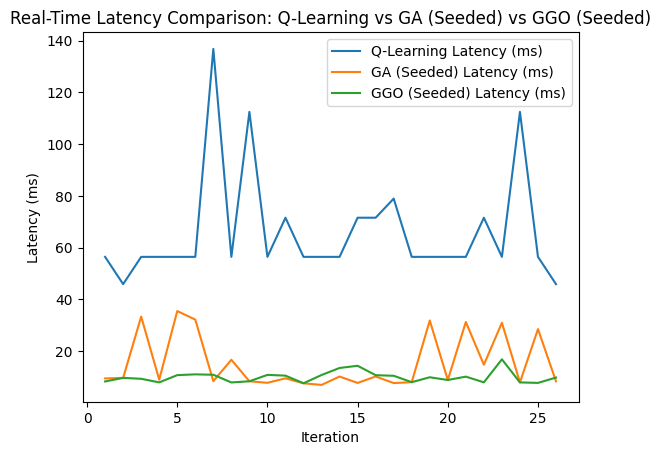

KeyboardInterrupt: 

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Lists to store iteration counts and latency values from each method
iteration_list = []
latencies_q = []    # Q-Learning latency (baseline)
latencies_ga = []   # GA (Seeded) latency
latencies_ggo = []  # GGO (Seeded) latency

iteration = 0

while True:
    # -------------------------------------------------------------------------
    # 1) Simulate real-time updates to the DataFrame
    #    Randomly scale latency values by +/-10%
    # -------------------------------------------------------------------------
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # -------------------------------------------------------------------------
    # 2) Run the merged approach with GA seeding
    # -------------------------------------------------------------------------
    results_ga = merged_approach_with_ga_seed(
        df=df,
        env=env,              # Existing environment or a builder function
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,          # Example parameter
        max_iter=50,          # Example parameter
        max_len=5             # Example parameter
    )

    # -------------------------------------------------------------------------
    # 3) Run the merged approach with GGO seeding
    # -------------------------------------------------------------------------
    results_ggo = merged_approach_with_ggo_seed(
        df=df,
        env=env,
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,          # Example parameter
        max_iter=50,          # Example parameter
        max_len=3            # Example parameter
    )

    # -------------------------------------------------------------------------
    # 4) Extract latency metrics from both approaches
    # -------------------------------------------------------------------------
    # The Q-Learning latency is used as a baseline and should be similar between both
    q_latency = results_ga["q_metrics"][0]

    ga_metrics = results_ga["ga_metrics"]
    ga_latency = ga_metrics[0] if ga_metrics is not None else np.nan

    ggo_metrics = results_ggo["ggo_metrics"]
    ggo_latency = ggo_metrics[0] if ggo_metrics is not None else np.nan

    # -------------------------------------------------------------------------
    # 5) Print the current iteration's results
    # -------------------------------------------------------------------------
    iteration += 1
    print(f"\n===== Iteration {iteration} =====\n")
    print("Q-Learning Path:")
    print("   ", results_ga["q_path"])
    print("Q-Learning Metrics:")
    print(f"   Total Latency = {q_latency}")

    print("\nGA (Seeded) Path:")
    print("   ", results_ga["ga_path"])
    if ga_latency is not None:
        print("GA (Seeded) Metrics:")
        print(f"   Total Latency = {ga_latency}")
    else:
        print("   No valid GA path found or metrics could not be computed.")

    print("\nGGO (Seeded) Path:")
    print("   ", results_ggo["ggo_path"])
    if ggo_latency is not None:
        print("GGO (Seeded) Metrics:")
        print(f"   Total Latency = {ggo_latency}")
    else:
        print("   No valid GGO path found or metrics could not be computed.")

    # -------------------------------------------------------------------------
    # 6) Store latencies for real-time plotting
    # -------------------------------------------------------------------------
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_ga.append(ga_latency if ga_latency else np.nan)
    latencies_ggo.append(ggo_latency if ggo_latency else np.nan)

    # -------------------------------------------------------------------------
    # 7) Update the real-time latency chart
    # -------------------------------------------------------------------------
    clear_output(wait=True)  # Clears previous output in Jupyter Notebook
    plt.figure()
    plt.plot(iteration_list, latencies_q, label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_ga, label='GA (Seeded) Latency (ms)')
    plt.plot(iteration_list, latencies_ggo, label='GGO (Seeded) Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: Q-Learning vs GA (Seeded) vs GGO (Seeded)")
    plt.legend()
    plt.show()

    # -------------------------------------------------------------------------
    # 8) Wait before the next iteration (adjust interval as needed)
    # -------------------------------------------------------------------------
    time.sleep(1)


# **3 Ant Colony Optimization (ACO)**

*3.1*

In [ ]:
# ============================================================
# 3. Ant Colony Optimization (ACO) Implementation
# ============================================================
def run_aco_with_rl_seed(
    adjacency_matrix, node_to_index, nodes, aco_src, aco_dst,
    rl_path, edge_lookup,
    pop_size=20, max_iter=50, max_len=5,
    alpha=1.0,       # pheromone importance
    beta=2.0,        # heuristic importance
    rho=0.1,         # evaporation rate
    Q=1.0,           # pheromone deposit factor
    initial_boost=10.0,  # extra pheromone boost for RL path
    verbose=True
):
    """
    Discrete Ant Colony Optimization, seeded with the RL path.

    1) We maintain a pheromone matrix tau.
    2) We give an extra "initial_boost" to edges in the RL path.
    3) Each iteration, we let 'pop_size' ants build paths from aco_src to aco_dst,
       guided by pheromone and a heuristic (1 / latency).
    4) We update (evaporate and deposit) pheromone based on the best ant in each iteration.
    5) We track and return the overall best path discovered.

    Returns: (best_path, best_cost, cost_history)
    """

    num_nodes = len(nodes)

    # --- (A) Initialize pheromone matrix ---
    tau = np.ones((num_nodes, num_nodes))  # pheromone
    # For edges in the RL path, add an extra boost of pheromone
    for i in range(len(rl_path) - 1):
        s, d = rl_path[i], rl_path[i+1]
        i_s = node_to_index[s]
        i_d = node_to_index[d]
        tau[i_s, i_d] += initial_boost

    # --- (B) Heuristic function: 1 / latency
    def get_eta(s, d):
        # latency = edge_lookup[(s,d)]['Latency_ms'], guard with small epsilon
        edge_data = edge_lookup.get((s, d))
        if not edge_data:
            return 0
        return 1.0 / (edge_data['Latency_ms'] + 1e-9)

    # --- (C) Keep track of global best path/cost
    best_cost = float('inf')
    best_path = None
    cost_history = []

    # --- (D) Main ACO loop ---
    for iteration in range(max_iter):
        iteration_ants_paths = []
        iteration_ants_costs = []

        # For each ant
        for ant_i in range(pop_size):
            path = [aco_src]
            # Build a path until we reach aco_dst or max_len
            while len(path) < max_len:
                current_node = path[-1]
                if current_node == aco_dst:
                    break
                i_c = node_to_index[current_node]

                # compute probabilities to move to each neighbor
                neighbors = []
                probs = []
                for nxt_idx in range(num_nodes):
                    if nxt_idx == i_c:
                        continue
                    if adjacency_matrix[i_c, nxt_idx] > 0:
                        # There's an edge
                        nxt_node = nodes[nxt_idx]
                        # tau^alpha * (eta)^beta
                        ph = tau[i_c, nxt_idx] ** alpha
                        et = get_eta(current_node, nxt_node) ** beta
                        neighbors.append(nxt_node)
                        probs.append(ph * et)

                if not neighbors:
                    # no neighbors => stuck
                    break

                sum_probs = sum(probs)
                if sum_probs == 0:
                    # degenerate => stuck
                    break

                # roulette wheel
                pick = random.random() * sum_probs
                cum = 0
                chosen = neighbors[-1]  # fallback
                for n, p in zip(neighbors, probs):
                    cum += p
                    if cum >= pick:
                        chosen = n
                        break

                path.append(chosen)

            # Ensure final node is destination
            if path[-1] != aco_dst:
                path.append(aco_dst)

            # Evaluate cost
            cost = compute_path_cost(path, adjacency_matrix, aco_dst, node_to_index)
            iteration_ants_paths.append(path)
            iteration_ants_costs.append(cost)

            # Check global best
            if cost < best_cost:
                best_cost = cost
                best_path = path

        # --- Evaporate pheromone ---
        tau = (1 - rho) * tau

        # --- Deposit pheromone on the best ant of this iteration (elitist update) ---
        iteration_best_cost = min(iteration_ants_costs)
        iteration_best_path = iteration_ants_paths[np.argmin(iteration_ants_costs)]
        if iteration_best_cost < float('inf'):
            deposit = Q / iteration_best_cost
            for i in range(len(iteration_best_path) - 1):
                s, d = iteration_best_path[i], iteration_best_path[i+1]
                i_s = node_to_index[s]
                i_d = node_to_index[d]
                tau[i_s, i_d] += deposit

        cost_history.append(best_cost)

        if verbose and (iteration + 1) % 10 == 0:
            print(f"ACO Iteration {iteration+1}/{max_iter}, Best Cost = {best_cost}")

    return best_path, best_cost, cost_history

*3.2 Q-Learning + ACO (Seeding with RL)*

In [ ]:
# ============================================================
# 4. Merged Approach: Q-Learning + ACO (Seeding with RL)
# ============================================================
def merged_approach_with_aco_seed(df, env, source, destination,
                                  pop_size=20, max_iter=50, max_len=5):
    """
    1) Run Q-learning to get an RL path.
    2) Build adjacency matrix from df.
    3) Run ACO *seeded* with that RL path.
    4) Compare results.
    """
    print("=== Running Q-Learning ===")
    q_table = run_Qlearning(env, alpha=0.05, gamma=0.99, eps_decay=0.85,
                            num_episodes=5000, min_epsilon=0.01, verbose=False)
    q_path, q_latency, q_bw, q_thr, q_jit, q_pl = evaluate_final_path(env, q_table)

    print("\n[Q-Learning Results]")
    print("Q-Learning Path:", q_path)
    print(f"Total Latency = {q_latency}, Bottleneck BW = {q_bw}, Throughput = {q_thr}, "
          f"Avg Jitter = {q_jit}, Avg Packet Loss = {q_pl}")

    # Build adjacency matrix & supporting structures
    # (Assuming you have a build_adjacency_matrix(df, metric='Latency_ms') function)
    A, node_to_index, nodes, edge_lookup = build_adjacency_matrix(df, metric='Latency_ms')

    print("\n=== Running ACO with RL-Path Seeding ===")
    best_path_seeded, best_cost_seeded, cost_hist_seeded = run_aco_with_rl_seed(
        adjacency_matrix=A,
        node_to_index=node_to_index,
        nodes=nodes,
        aco_src=source,
        aco_dst=destination,
        rl_path=q_path,
        edge_lookup=edge_lookup,
        pop_size=pop_size,
        max_iter=max_iter,
        max_len=max_len,
        verbose=False  # set True if you want iteration logs
    )

    # Evaluate metrics of the ACO-seeded path
    aco_metrics = compute_path_metrics(best_path_seeded, edge_lookup, destination)

    print("\n[ACO (Seeded) Results]")
    print("ACO Best Path:", best_path_seeded)
    if aco_metrics:
        lat_aco, bw_aco, thr_aco, jit_aco, pl_aco = aco_metrics
        print(f"Total Latency = {lat_aco}, Bottleneck BW = {bw_aco}, "
              f"Throughput = {thr_aco}, Avg Jitter = {jit_aco}, Packet Loss = {pl_aco}")
    else:
        print("No valid path found by seeded ACO or metrics could not be computed.")

    # Compare final latencies
    if aco_metrics and aco_metrics[0] < q_latency:
        print("\n[ACO (seeded) found a better path than Q-Learning!]")
    else:
        print("\n[Q-Learning path was better or ACO path invalid.]")

    return {
        "q_path": q_path,
        "q_metrics": (q_latency, q_bw, q_thr, q_jit, q_pl),
        "aco_path": best_path_seeded,
        "aco_metrics": aco_metrics
    }

**Latencies based on Pure Reinforcement learning VS  Ant Colony Optimized Reinforcement learning**

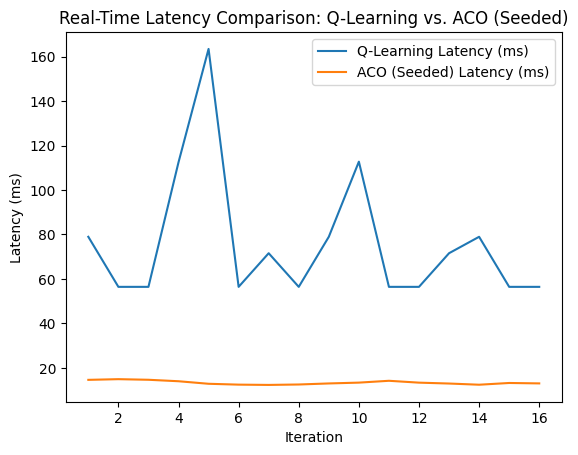

=== Running Q-Learning ===

[Q-Learning Results]
Q-Learning Path: [17, 1, 6]
Total Latency = 71.55904208425262, Bottleneck BW = 577.0, Throughput = 430.0, Avg Jitter = 12.5, Avg Packet Loss = 2.225

=== Running ACO with RL-Path Seeding ===


KeyboardInterrupt: 

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Lists to store iteration counts and latencies
iteration_list = []
latencies_q = []    # Q-Learning latency (baseline)
latencies_aco = []  # ACO (Seeded) latency

iteration = 0

while True:
    # 1) Simulate real-time updates to the DataFrame:
    #    e.g., randomly scale Latency by +/-10%
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # 2) Call the merged approach that runs Q-Learning and ACO (Seeded) internally
    results = merged_approach_with_aco_seed(
        df=df,
        env=env,  # Existing environment or builder function
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,   # Example parameter
        max_iter=50,   # Example parameter
        max_len=5      # Example parameter
    )

    # 3) Extract the metrics for Q-Learning
    q_latency, q_bw, q_thr, q_jit, q_pl = results["q_metrics"]

    # 4) Extract the metrics for ACO (Seeded)
    if results["aco_metrics"] is not None:
        lat_aco, bw_aco, thr_aco, jit_aco, pl_aco = results["aco_metrics"]
    else:
        lat_aco = None  # No valid ACO path or metrics available

    # 5) Print the results for this iteration
    iteration += 1
    print(f"\n===== Iteration {iteration} =====\n")
    print("Q-Learning Path:")
    print("   ", results["q_path"])
    print("Q-Learning Metrics:")
    print(f"   Total Latency = {q_latency}")
    print(f"   Bottleneck BW (Mbps) = {q_bw}")
    print(f"   Bottleneck Throughput (Mbps) = {q_thr}")
    print(f"   Avg Jitter (ms) = {q_jit}")
    print(f"   Avg Packet Loss (%) = {q_pl}")

    print("\nACO (Seeded) Path:")
    print("   ", results["aco_path"])
    if lat_aco is not None:
        print("ACO (Seeded) Metrics:")
        print(f"   Total Latency = {lat_aco}")
        print(f"   Bottleneck BW (Mbps) = {bw_aco}")
        print(f"   Bottleneck Throughput (Mbps) = {thr_aco}")
        print(f"   Avg Jitter (ms) = {jit_aco}")
        print(f"   Avg Packet Loss (%) = {pl_aco}")
    else:
        print("   No valid ACO path found or metrics could not be computed.")

    # 6) Store latencies for real-time plotting
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_aco.append(lat_aco if lat_aco else np.nan)

    # 7) Update a real-time chart for latency comparison
    clear_output(wait=True)  # For Jupyter: clears previous output to refresh the plot
    plt.figure()
    plt.plot(iteration_list, latencies_q, label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_aco, label='ACO (Seeded) Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: Q-Learning vs. ACO (Seeded)")
    plt.legend()
    plt.show()

    # 8) Wait before the next iteration (adjust as needed)
    time.sleep(1)


# **4 Differential Evolution (DE)**

*4.1*

In [ ]:
#Generate a random path
def generate_random_path(source, destination, adjacency_matrix, node_to_index, nodes, max_len=5):
    """
    Generate a random path from source to destination, up to max_len hops.
    If not reaching dest, append it anyway.
    """
    p = [source]
    curr = source
    for _ in range(max_len):
        if curr == destination:
            break
        i_curr = node_to_index[curr]
        next_hops = [
            nodes[j]
            for j in range(adjacency_matrix.shape[1])
            if adjacency_matrix[i_curr, j] != 0 and nodes[j] != curr
        ]
        if not next_hops:
            break
        nxt = random.choice(next_hops)
        p.append(nxt)
        curr = nxt
    if p[-1] != destination:
        p.append(destination)
    return p

# Mutation (“Discrete”)
def discrete_de_mutation(path_r1, path_r2, path_r3, F=0.5):
    """
    Returns a mutant path by partially merging r1 with differences from r2, r3.
    For each index j, if r2[j] != r3[j], then with probability F we copy r2[j].
    Otherwise we keep r1[j].
    """
    # We'll assume r1 is the base length
    mutant = path_r1[:]
    min_len = min(len(path_r2), len(path_r3), len(path_r1))
    for j in range(1, min_len - 1):
        if path_r2[j] != path_r3[j]:
            # with prob F, incorporate from r2
            if random.random() < F:
                mutant[j] = path_r2[j]
    return mutant
#Crossover
def discrete_de_crossover(original, mutant, CR=0.9):
    """
    Binomial crossover: produce a trial path from original & mutant.
    For each position j, with prob CR take mutant[j], else original[j].
    Then ensure the last node matches the original's destination.
    """
    length = min(len(original), len(mutant))
    trial = original[:]
    for j in range(1, length - 1):
        if random.random() < CR:
            trial[j] = mutant[j]
    # ensure the final node is the same as original's final node
    trial[-1] = original[-1]
    return trial

#run_de_with_rl_seed
def run_de_with_rl_seed(
    adjacency_matrix, node_to_index, nodes,
    de_src, de_dst, rl_path,
    pop_size=20, max_iter=50, max_len=5,
    F=0.5, CR=0.9, verbose=True
):
    """
    Discrete Differential Evolution with RL Path Seeding.
    Steps:
      1) Initialize population; the first is the RL path, the rest random.
      2) For each iteration:
         - For each individual i in population:
             a) choose r1,r2,r3 distinct from i
             b) mutant = discrete_de_mutation(r1, r2, r3, F)
             c) trial = discrete_de_crossover(pop[i], mutant, CR)
             d) if cost(trial) < cost(pop[i]), pop[i] = trial
      3) Track best solution.

    Returns: (best_path, best_cost, cost_history)
    """
    # 1) Initialize
    population = [rl_path]
    for _ in range(pop_size - 1):
        population.append(generate_random_path(de_src, de_dst, adjacency_matrix, node_to_index, nodes, max_len))

    # Evaluate costs
    costs = [compute_path_cost(p, adjacency_matrix, de_dst, node_to_index) for p in population]
    best_idx = np.argmin(costs)
    best_path = population[best_idx]
    best_cost = costs[best_idx]
    cost_history = [best_cost]

    # 2) Main DE loop
    for iteration in range(max_iter):
        for i in range(pop_size):
            # pick distinct r1,r2,r3 distinct from i
            idxs = list(range(pop_size))
            idxs.remove(i)
            r1_i, r2_i, r3_i = random.sample(idxs, 3)

            # 2a) mutation
            mutant = discrete_de_mutation(
                path_r1=population[r1_i],
                path_r2=population[r2_i],
                path_r3=population[r3_i],
                F=F
            )

            # 2b) crossover
            trial = discrete_de_crossover(
                original=population[i],
                mutant=mutant,
                CR=CR
            )

            # 2c) selection
            trial_cost = compute_path_cost(trial, adjacency_matrix, de_dst, node_to_index)
            if trial_cost < costs[i]:
                population[i] = trial
                costs[i] = trial_cost
                # update best
                if trial_cost < best_cost:
                    best_cost = trial_cost
                    best_path = trial

        cost_history.append(best_cost)
        if verbose and (iteration + 1) % 10 == 0:
            print(f"DE Iter {iteration+1}/{max_iter}, Best Cost = {best_cost}")

    return best_path, best_cost, cost_history


*4.2 Merged Approach: Q-Learning + DE (Seeding)*

In [ ]:
def merged_approach_with_de_seed(df, env, source, destination,
                                 pop_size=20, max_iter=50, max_len=5,
                                 F=0.5, CR=0.9):
    """
    1) Run Q-learning to get an RL path.
    2) Build adjacency matrix from df.
    3) Run DE *seeded* with that RL path.
    4) Compare results.
    """
    print("=== Running Q-Learning ===")
    q_table = run_Qlearning(env, alpha=0.05, gamma=0.99, eps_decay=0.85,
                            num_episodes=5000, min_epsilon=0.01, verbose=False)
    q_path, q_latency, q_bw, q_thr, q_jit, q_pl = evaluate_final_path(env, q_table)

    print("\n[Q-Learning Results]")
    print("Q-Learning Path:", q_path)
    print(f"Total Latency = {q_latency}, Bottleneck BW = {q_bw}, Throughput = {q_thr}, "
          f"Avg Jitter = {q_jit}, Avg Packet Loss = {q_pl}")

    # Build adjacency matrix & supporting structures
    # We'll assume you have a function: build_adjacency_matrix(df, metric='Latency_ms')
    A, node_to_index, nodes, edge_lookup = build_adjacency_matrix(df, metric='Latency_ms')

    # DE seeded with RL path
    print("\n=== Running DE with RL-Path Seeding ===")
    de_best_path, de_best_cost, de_cost_history = run_de_with_rl_seed(
        adjacency_matrix=A,
        node_to_index=node_to_index,
        nodes=nodes,
        de_src=source,
        de_dst=destination,
        rl_path=q_path,
        pop_size=pop_size,
        max_iter=max_iter,
        max_len=max_len,
        F=F,
        CR=CR,
        verbose=False
    )

    # Evaluate the DE path
    de_metrics = compute_path_metrics(de_best_path, edge_lookup, destination)

    print("\n[DE (Seeded) Results]")
    print("DE Best Path:", de_best_path)
    if de_metrics:
        lat_de, bw_de, thr_de, jit_de, pl_de = de_metrics
        print(f"Total Latency = {lat_de}, Bottleneck BW = {bw_de}, "
              f"Throughput = {thr_de}, Avg Jitter = {jit_de}, Packet Loss = {pl_de}")
    else:
        print("No valid path found by seeded DE or metrics invalid.")

    # Compare final latencies
    if de_metrics and de_metrics[0] < q_latency:
        print("\n[DE (seeded) found a better path than Q-Learning!]")
    else:
        print("\n[Q-Learning path was better or DE path invalid.]")

    return {
        "q_path": q_path,
        "q_metrics": (q_latency, q_bw, q_thr, q_jit, q_pl),
        "de_path": de_best_path,
        "de_metrics": de_metrics
    }


*4.3 RL VS DE OPTIMIZED RL*

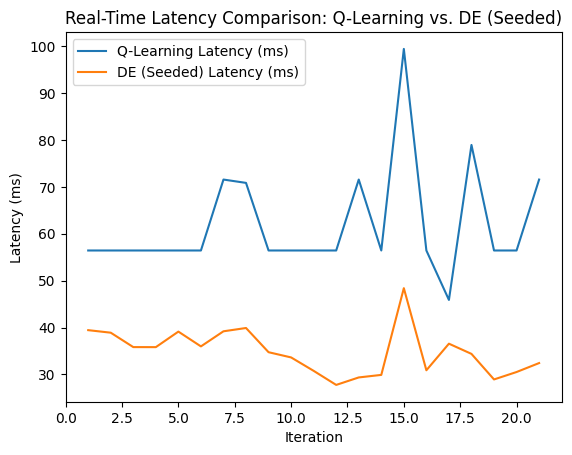

KeyboardInterrupt: 

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Lists to store iteration counts and latencies
iteration_list = []
latencies_q = []    # Q-Learning latency (baseline)
latencies_de = []   # DE (Seeded) latency

iteration = 0

while True:
    # 1) Simulate real-time updates to the DataFrame:
    #    e.g., randomly scale Latency by +/-10%
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # 2) Call the merged approach that runs Q-Learning and DE (Seeded) internally
    results = merged_approach_with_de_seed(
        df=df,
        env=env,  # Existing environment or builder function
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,   # Example parameter
        max_iter=50,   # Example parameter
        max_len=5,     # Example parameter
        F=0.5,         # Differential evolution parameter F
        CR=0.9         # Differential evolution parameter CR
    )

    # 3) Extract the metrics for Q-Learning
    q_latency, q_bw, q_thr, q_jit, q_pl = results["q_metrics"]

    # 4) Extract the metrics for DE (Seeded)
    if results["de_metrics"] is not None:
        lat_de, bw_de, thr_de, jit_de, pl_de = results["de_metrics"]
    else:
        lat_de = None  # No valid DE path or metrics available

    # 5) Print the results for this iteration
    iteration += 1
    print(f"\n===== Iteration {iteration} =====\n")
    print("Q-Learning Path:")
    print("   ", results["q_path"])
    print("Q-Learning Metrics:")
    print(f"   Total Latency = {q_latency}")
    print(f"   Bottleneck BW (Mbps) = {q_bw}")
    print(f"   Bottleneck Throughput (Mbps) = {q_thr}")
    print(f"   Avg Jitter (ms) = {q_jit}")
    print(f"   Avg Packet Loss (%) = {q_pl}")

    print("\nDE (Seeded) Path:")
    print("   ", results["de_path"])
    if lat_de is not None:
        print("DE (Seeded) Metrics:")
        print(f"   Total Latency = {lat_de}")
        print(f"   Bottleneck BW (Mbps) = {bw_de}")
        print(f"   Bottleneck Throughput (Mbps) = {thr_de}")
        print(f"   Avg Jitter (ms) = {jit_de}")
        print(f"   Avg Packet Loss (%) = {pl_de}")
    else:
        print("   No valid DE path found or metrics could not be computed.")

    # 6) Store latencies for real-time plotting
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_de.append(lat_de if lat_de else np.nan)

    # 7) Update a real-time chart for latency comparison
    clear_output(wait=True)  # For Jupyter: clears the previous output to refresh the plot
    plt.figure()
    plt.plot(iteration_list, latencies_q, label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_de, label='DE (Seeded) Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: Q-Learning vs. DE (Seeded)")
    plt.legend()
    plt.show()

    # 8) Wait before the next iteration (adjust as needed)
    time.sleep(1)


*4.5 Real-Time Latency Comparison: Q-Learning vs DE vs GGO (Seeded)*

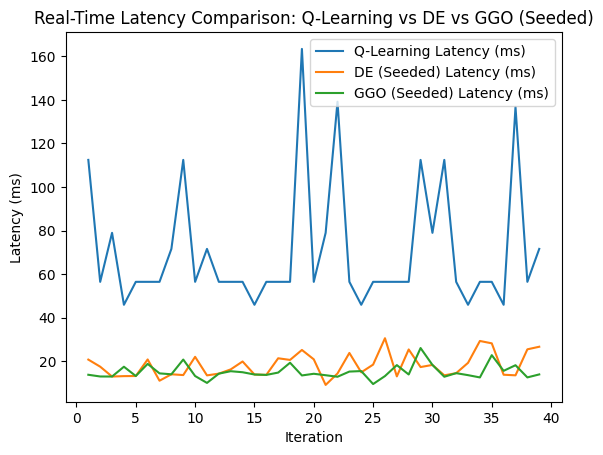

KeyboardInterrupt: 

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Lists to store iteration counts and latencies for each approach
iteration_list = []
latencies_q = []     # Q-Learning latency (baseline)
latencies_de = []    # DE (Seeded) latency
latencies_ggo = []   # GGO (Seeded) latency

iteration = 0

while True:
    # 1) Simulate real-time updates to the DataFrame:
    #    e.g., randomly scale Latency by +/-10%
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # 2) Run the merged DE (Seeded) approach
    results_de = merged_approach_with_de_seed(
        df=df,
        env=env,                    # Existing environment or builder function
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,                # Example parameter
        max_iter=50,                # Example parameter
        max_len=5,                  # Example parameter
        F=0.5,                      # DE parameter F
        CR=0.9                      # DE parameter CR
    )

    # 3) Run the merged GGO (Seeded) approach
    results_ggo = merged_approach_with_ggo_seed(
        df=df,
        env=env,
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,                # Example parameter
        max_iter=50,                # Example parameter
        max_len=3                   # Example parameter
    )

    # 4) Extract Q-Learning metrics (baseline)
    #    Both merged functions run Q-Learning internally; here we use the one from the DE function.
    q_latency, q_bw, q_thr, q_jit, q_pl = results_de["q_metrics"]

    # 5) Extract DE (Seeded) metrics
    if results_de["de_metrics"] is not None:
        lat_de, bw_de, thr_de, jit_de, pl_de = results_de["de_metrics"]
    else:
        lat_de = None

    # 6) Extract GGO (Seeded) metrics
    if results_ggo["ggo_metrics"] is not None:
        lat_ggo, bw_ggo, thr_ggo, jit_ggo, pl_ggo = results_ggo["ggo_metrics"]
    else:
        lat_ggo = None

    # 7) Print the results for this iteration
    iteration += 1
    print(f"\n===== Iteration {iteration} =====\n")

    print("Q-Learning Path:")
    print("   ", results_de["q_path"])
    print("Q-Learning Metrics:")
    print(f"   Total Latency = {q_latency}")
    print(f"   Bottleneck BW (Mbps) = {q_bw}")
    print(f"   Bottleneck Throughput (Mbps) = {q_thr}")
    print(f"   Avg Jitter (ms) = {q_jit}")
    print(f"   Avg Packet Loss (%) = {q_pl}")

    print("\nDE (Seeded) Path:")
    print("   ", results_de["de_path"])
    if lat_de is not None:
        print("DE (Seeded) Metrics:")
        print(f"   Total Latency = {lat_de}")
        print(f"   Bottleneck BW (Mbps) = {bw_de}")
        print(f"   Bottleneck Throughput (Mbps) = {thr_de}")
        print(f"   Avg Jitter (ms) = {jit_de}")
        print(f"   Avg Packet Loss (%) = {pl_de}")
    else:
        print("   No valid DE path found or metrics could not be computed.")

    print("\nGGO (Seeded) Path:")
    print("   ", results_ggo["ggo_path"])
    if lat_ggo is not None:
        print("GGO (Seeded) Metrics:")
        print(f"   Total Latency = {lat_ggo}")
        print(f"   Bottleneck BW (Mbps) = {bw_ggo}")
        print(f"   Bottleneck Throughput (Mbps) = {thr_ggo}")
        print(f"   Avg Jitter (ms) = {jit_ggo}")
        print(f"   Avg Packet Loss (%) = {pl_ggo}")
    else:
        print("   No valid GGO path found or metrics could not be computed.")

    # 8) Store latencies for real-time plotting
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_de.append(lat_de if lat_de else np.nan)
    latencies_ggo.append(lat_ggo if lat_ggo else np.nan)

    # 9) Update a real-time chart for latency comparison
    clear_output(wait=True)  # Clears previous output in Jupyter for a fresh plot
    plt.figure()
    plt.plot(iteration_list, latencies_q, label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_de, label='DE (Seeded) Latency (ms)')
    plt.plot(iteration_list, latencies_ggo, label='GGO (Seeded) Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: Q-Learning vs DE vs GGO (Seeded)")
    plt.legend()
    plt.show()

    # 10) Wait before the next iteration (adjust as needed)
    time.sleep(1)


# **5 Particle Swarm Optimization (PSO) Implementation (Discrete / Path-Based)**

# PSO (Seeded) Implementation
We define a discrete version of PSO for path optimization. One particle is initialized
to the Q-Learning path; others are random. At each iteration:
1. Evaluate cost for each particle (sum of latencies).
2. Update personal bests (pbest) and global best (gbest).
3. For each particle, stochastically "move" toward pbest and gbest by partially
   replacing segments of the path.

You can refine the "update" step for more nuanced discrete transformations.
*italicised text*

5.1

In [ ]:
def run_pso_with_rl_seed(
    adjacency_matrix, node_to_index, nodes,
    pso_src, pso_dst, rl_path,
    pop_size=20, max_iter=50, max_len=5,
    inertia=0.5, c1=1.0, c2=1.0, verbose=True
):
    """
    Discrete PSO approach seeded by Q-Learning path.
    - pop_size: number of particles
    - max_iter: number of iterations
    - max_len:  maximum path length (besides forced destination)
    - inertia, c1, c2: typical PSO hyperparameters controlling velocity update

    Each particle is a path. We'll store:
       - position[i] = current path
       - pbest[i] = best path found by that particle
       - gbest = best path overall

    The 'velocity' in discrete space is a bit conceptual. We'll define an "update"
    as partially merging from pbest and gbest with some probabilities.

    Returns: (best_path, best_cost, cost_history)
    """
    # Initialize population
    population = []
    population.append(rl_path)  # Seed with RL path
    for _ in range(pop_size - 1):
        population.append(generate_random_path(pso_src, pso_dst, adjacency_matrix, node_to_index, nodes, max_len))

    # Initialize pbest as a copy of initial population; evaluate costs
    costs = [compute_path_cost(p, adjacency_matrix, pso_dst, node_to_index) for p in population]
    pbest = population[:]
    pbest_costs = costs[:]

    # Find global best
    gbest_idx = np.argmin(costs)
    gbest = population[gbest_idx]
    gbest_cost = costs[gbest_idx]

    cost_history = [gbest_cost]

    def discrete_pso_update(current_path, pbest_path, gbest_path):
        """
        Merge current_path with pbest_path and gbest_path, using inertia, c1, c2 in a discrete manner.
        For each position j in the path (excluding first=src, last=dst):
        - with probability inertia, keep current
        - with probability c1, incorporate pbest
        - with probability c2, incorporate gbest
        This is a simplistic interpretation of velocity in discrete space.
        """
        # We assume all three paths have similar lengths for this demonstration
        length = min(len(current_path), len(pbest_path), len(gbest_path))
        new_path = current_path[:]
        for j in range(1, length - 1):  # skip the first and last node
            r1 = random.random()
            r2 = random.random()
            r3 = random.random()
            # Inertia: keep current if r1 < inertia
            # c1: incorporate pbest if r2 < c1
            # c2: incorporate gbest if r3 < c2
            # We prioritize the 'social' component last if triggered
            if r2 < c1:
                new_path[j] = pbest_path[j]
            if r3 < c2:
                new_path[j] = gbest_path[j]
            # If none triggered, we keep the original
            # (the code as written effectively does that anyway)
        # Ensure the final node is the same
        new_path[-1] = current_path[-1]  # or pso_dst
        return new_path

    # Main PSO loop
    for iteration in range(max_iter):
        for i in range(pop_size):
            # 1) Generate new path from the discrete PSO update
            new_path = discrete_pso_update(
                current_path=population[i],
                pbest_path=pbest[i],
                gbest_path=gbest
            )
            # 2) Evaluate cost
            new_cost = compute_path_cost(new_path, adjacency_matrix, pso_dst, node_to_index)
            # 3) If better than current, replace
            if new_cost < costs[i]:
                population[i] = new_path
                costs[i] = new_cost
            # 4) If better than pbest, update pbest
            if new_cost < pbest_costs[i]:
                pbest[i] = new_path
                pbest_costs[i] = new_cost
            # 5) If better than gbest, update gbest
            if new_cost < gbest_cost:
                gbest = new_path
                gbest_cost = new_cost

        cost_history.append(gbest_cost)
        if verbose and (iteration + 1) % 10 == 0:
            print(f"PSO Iter {iteration+1}/{max_iter}, Best Cost = {gbest_cost}")

    return gbest, gbest_cost, cost_history


*5.2 Merged Approach: Q-Learning + PSO (Seeded)*

# Merged Approach with PSO Seeding
We run Q-Learning first to get an RL path. Then we build the adjacency matrix from `df`
and run the PSO seeded with the RL path. Finally, we compare results.


In [ ]:
def merged_approach_with_pso_seed(df, env, source, destination,
                                  pop_size=20, max_iter=50, max_len=5,
                                  inertia=0.5, c1=1.0, c2=1.0):
    """
    1) Run Q-Learning to get an RL path.
    2) Build adjacency matrix from df.
    3) Run PSO *seeded* with that RL path.
    4) Compare results.
    """
    print("=== Running Q-Learning ===")
    q_table = run_Qlearning(env, alpha=0.05, gamma=0.99, eps_decay=0.85,
                            num_episodes=5000, min_epsilon=0.01, verbose=False)
    q_path, q_latency, q_bw, q_thr, q_jit, q_pl = evaluate_final_path(env, q_table)

    print("\n[Q-Learning Results]")
    print("Q-Learning Path:", q_path)
    print(f"Total Latency = {q_latency}, Bottleneck BW = {q_bw}, Throughput = {q_thr}, "
          f"Avg Jitter = {q_jit}, Avg Packet Loss = {q_pl}")

    # Build adjacency matrix
    A, node_to_index, nodes, edge_lookup = build_adjacency_matrix(df, metric='Latency_ms')

    # PSO seeded with RL path
    print("\n=== Running PSO with RL-Path Seeding ===")
    pso_best_path, pso_best_cost, pso_cost_history = run_pso_with_rl_seed(
        adjacency_matrix=A,
        node_to_index=node_to_index,
        nodes=nodes,
        pso_src=source,
        pso_dst=destination,
        rl_path=q_path,
        pop_size=pop_size,
        max_iter=max_iter,
        max_len=max_len,
        inertia=inertia,
        c1=c1,
        c2=c2,
        verbose=False
    )

    # Evaluate the PSO path
    pso_metrics = compute_path_metrics(pso_best_path, edge_lookup, destination)

    print("\n[PSO (Seeded) Results]")
    print("PSO Best Path:", pso_best_path)
    if pso_metrics:
        lat_pso, bw_pso, thr_pso, jit_pso, pl_pso = pso_metrics
        print(f"Total Latency = {lat_pso}, Bottleneck BW = {bw_pso}, "
              f"Throughput = {thr_pso}, Avg Jitter = {jit_pso}, Packet Loss = {pl_pso}")
    else:
        print("No valid path found by seeded PSO or metrics invalid.")

    # Compare final latencies
    if pso_metrics and pso_metrics[0] < q_latency:
        print("\n[PSO (seeded) found a better path than Q-Learning!]")
    else:
        print("\n[Q-Learning path was better or PSO path invalid.]")

    return {
        "q_path": q_path,
        "q_metrics": (q_latency, q_bw, q_thr, q_jit, q_pl),
        "pso_path": pso_best_path,
        "pso_metrics": pso_metrics
    }


5.3 Real-Time Latency Comparison: Q-Learning vs PSO vs GGO (Seeded)

# Real-Time Latency Comparison: Q-Learning vs PSO vs GGO (Seeded)
Below is an example loop that:
1. Randomly perturbs the DataFrame (e.g., ±10% on Latency).
2. Runs the merged PSO approach and GGO approach.
3. Extracts and prints the results for Q-Learning (baseline), PSO, and GGO.
4. Plots the latencies in real-time.

Note:
- We assume you already have `merged_approach_with_ggo_seed(...)` defined
  similarly for GGO (seeded by the Q-Learning path).
- Adjust `time.sleep(1)` or remove it for faster looping.
- This cell is meant for a Jupyter environment where `clear_output(wait=True)`
  refreshes the plot each iteration.


In [ ]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Lists to store iteration counts and latencies
iteration_list = []
latencies_q = []     # Q-Learning latency (baseline)
latencies_pso = []   # PSO (Seeded) latency
latencies_ggo = []   # GGO (Seeded) latency

iteration = 0

while True:
    # 1) Simulate real-time updates to the DataFrame (±10% on Latency)
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # 2) Run the merged PSO (Seeded) approach
    results_pso = merged_approach_with_pso_seed(
        df=df,
        env=env,  # Existing environment or builder function
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,   # Example parameter
        max_iter=50,   # Example parameter
        max_len=5,     # Example parameter
        inertia=0.5,
        c1=1.0,
        c2=1.0
    )

    # 3) Run the merged GGO (Seeded) approach
    #    Assuming you have a similar function: merged_approach_with_ggo_seed(...)
    results_ggo = merged_approach_with_ggo_seed(
        df=df,
        env=env,
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,   # Example parameter
        max_iter=50,   # Example parameter
        max_len=3      # Example parameter
    )

    # 4) Extract Q-Learning metrics (baseline) from PSO run
    q_latency, q_bw, q_thr, q_jit, q_pl = results_pso["q_metrics"]

    # 5) Extract PSO (Seeded) metrics
    if results_pso["pso_metrics"] is not None:
        lat_pso, bw_pso, thr_pso, jit_pso, pl_pso = results_pso["pso_metrics"]
    else:
        lat_pso = None

    # 6) Extract GGO (Seeded) metrics
    if results_ggo["ggo_metrics"] is not None:
        lat_ggo, bw_ggo, thr_ggo, jit_ggo, pl_ggo = results_ggo["ggo_metrics"]
    else:
        lat_ggo = None

    # 7) Print the results for this iteration
    iteration += 1
    print(f"\n===== Iteration {iteration} =====\n")

    print("Q-Learning Path:")
    print("   ", results_pso["q_path"])
    print("Q-Learning Metrics:")
    print(f"   Total Latency = {q_latency}")
    print(f"   Bottleneck BW (Mbps) = {q_bw}")
    print(f"   Bottleneck Throughput (Mbps) = {q_thr}")
    print(f"   Avg Jitter (ms) = {q_jit}")
    print(f"   Avg Packet Loss (%) = {q_pl}")

    print("\nPSO (Seeded) Path:")
    print("   ", results_pso["pso_path"])
    if lat_pso is not None:
        print("PSO (Seeded) Metrics:")
        print(f"   Total Latency = {lat_pso}")
        print(f"   Bottleneck BW (Mbps) = {bw_pso}")
        print(f"   Bottleneck Throughput (Mbps) = {thr_pso}")
        print(f"   Avg Jitter (ms) = {jit_pso}")
        print(f"   Avg Packet Loss (%) = {pl_pso}")
    else:
        print("   No valid PSO path found or metrics could not be computed.")

    print("\nGGO (Seeded) Path:")
    print("   ", results_ggo["ggo_path"])
    if lat_ggo is not None:
        print("GGO (Seeded) Metrics:")
        print(f"   Total Latency = {lat_ggo}")
        print(f"   Bottleneck BW (Mbps) = {bw_ggo}")
        print(f"   Bottleneck Throughput (Mbps) = {thr_ggo}")
        print(f"   Avg Jitter (ms) = {jit_ggo}")
        print(f"   Avg Packet Loss (%) = {pl_ggo}")
    else:
        print("   No valid GGO path found or metrics could not be computed.")

    # 8) Store latencies for real-time plotting
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_pso.append(lat_pso if lat_pso else np.nan)
    latencies_ggo.append(lat_ggo if lat_ggo else np.nan)

    # 9) Update a real-time chart for latency comparison
    clear_output(wait=True)
    plt.figure()
    plt.plot(iteration_list, latencies_q, label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_pso, label='PSO (Seeded) Latency (ms)')
    plt.plot(iteration_list, latencies_ggo, label='GGO (Seeded) Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: Q-Learning vs PSO vs GGO (Seeded)")
    plt.legend()
    plt.show()

    # 10) Wait before the next iteration (optional)
    time.sleep(1)


KeyboardInterrupt: 

# **6 Whale Optimization Algorithm (WOA) Implementation (Discrete / Path-Based)**

6.1  WOA (Seeded) Implementation
We define a discrete version of WOA for path optimization. One whale is initialized
to the Q-Learning path; others are random. At each iteration:
1. Compute cost for each whale (sum of latencies).
2. Update the global best (the "prey").
3. For each whale, update its path:
   - With probability p, do a "bubble net" attack (partial shuffle around best).
   - Otherwise, encircle or search (partial merging with best or random).
You can refine the "update" step for more nuanced discrete transformations.


In [ ]:
def run_woa_with_rl_seed(
    adjacency_matrix, node_to_index, nodes,
    woa_src, woa_dst, rl_path,
    pop_size=20, max_iter=50, max_len=5,
    b=1.0, a_decay=2.0, verbose=True
):
    """
    Discrete WOA approach seeded by Q-Learning path.
    - pop_size: number of whales
    - max_iter: number of iterations
    - max_len:  maximum path length
    - b: control parameter for the spiral updating position (in bubble-net)
    - a_decay: the factor controlling 'a' from 2 -> 0 over iterations (linearly or otherwise)
      which influences |A| < 1 or > 1 in the standard WOA.

    Each whale is a path. We'll keep track of:
       - population[i]: current path of whale i
       - best_path: best path overall (prey)
       - best_cost

    Returns: (best_path, best_cost, cost_history)
    """
    # Initialize population
    population = []
    population.append(rl_path)  # Seed with RL path
    for _ in range(pop_size - 1):
        population.append(generate_random_path(woa_src, woa_dst, adjacency_matrix, node_to_index, nodes, max_len))

    # Evaluate costs
    costs = [compute_path_cost(p, adjacency_matrix, woa_dst, node_to_index) for p in population]
    best_idx = np.argmin(costs)
    best_path = population[best_idx]
    best_cost = costs[best_idx]

    cost_history = [best_cost]

    # Helper: a simple function to partially merge the current whale's path with best_path
    def encircle_whale_path(current_path, best_path):
        """
        For discrete encircling: partially replace some nodes of current_path with best_path's nodes.
        """
        new_path = current_path[:]
        length = min(len(new_path), len(best_path))
        for j in range(1, length - 1):
            # with some probability, adopt the best_path's node
            if random.random() < 0.5:
                new_path[j] = best_path[j]
        # Keep final node consistent
        new_path[-1] = current_path[-1]
        return new_path

    # Helper: a simple function to do a "bubble net" (spiral) move around best_path
    def bubble_net_path(current_path, best_path, b):
        """
        For discrete bubble net: we can do a random small 'swap' or 'shift' around best_path's arrangement.
        We'll interpret the spiral by random small modification near best_path.
        """
        new_path = list(best_path)  # start from best
        length = len(new_path)
        # maybe do one or two random alterations in the path near the middle
        if length > 2:
            idx1 = random.randint(1, length - 2)
            idx2 = random.randint(1, length - 2)
            new_path[idx1], new_path[idx2] = new_path[idx2], new_path[idx1]
        return new_path

    # Main WOA loop
    for iteration in range(max_iter):
        # 'a' decreases linearly from 2 -> 0 over iterations
        a = 2 - iteration * (2 / max_iter)  # or use a_decay if needed
        for i in range(pop_size):
            current_cost = costs[i]
            current_path = population[i]

            # Step 1: update parameters
            A = 2 * a * random.random() - a   # A in [-a, a]
            C = 2 * random.random()          # C in [0, 2]
            p = random.random()              # for bubble-net or not

            if p < 0.5:
                # Encircling or Search
                if abs(A) < 1:
                    # Encircling the best
                    new_path = encircle_whale_path(current_path, best_path)
                else:
                    # Search for prey (random whale)
                    rand_idx = random.randint(0, pop_size-1)
                    rand_path = population[rand_idx]
                    # partially merge with rand_path
                    new_path = encircle_whale_path(current_path, rand_path)
            else:
                # Bubble-net attacking method
                new_path = bubble_net_path(current_path, best_path, b)

            # Evaluate new cost
            new_cost = compute_path_cost(new_path, adjacency_matrix, woa_dst, node_to_index)
            # If better, update the whale's path
            if new_cost < current_cost:
                population[i] = new_path
                costs[i] = new_cost
                # Check if best improved
                if new_cost < best_cost:
                    best_cost = new_cost
                    best_path = new_path

        cost_history.append(best_cost)
        if verbose and (iteration + 1) % 10 == 0:
            print(f"WOA Iter {iteration+1}/{max_iter}, Best Cost = {best_cost}")

    return best_path, best_cost, cost_history


6.3 Merged Approach: Q-Learning + WOA (Seeded)

# Merged Approach with WOA Seeding
We run Q-Learning first to get an RL path. Then we build the adjacency matrix from `df`
and run the WOA seeded with the RL path. Finally, we compare results.


In [ ]:
def merged_approach_with_woa_seed(df, env, source, destination,
                                  pop_size=20, max_iter=50, max_len=5,
                                  b=1.0, a_decay=2.0):
    """
    1) Run Q-Learning to get an RL path.
    2) Build adjacency matrix from df.
    3) Run WOA *seeded* with that RL path.
    4) Compare results.
    """
    print("=== Running Q-Learning ===")
    q_table = run_Qlearning(env, alpha=0.05, gamma=0.99, eps_decay=0.85,
                            num_episodes=5000, min_epsilon=0.01, verbose=False)
    q_path, q_latency, q_bw, q_thr, q_jit, q_pl = evaluate_final_path(env, q_table)

    print("\n[Q-Learning Results]")
    print("Q-Learning Path:", q_path)
    print(f"Total Latency = {q_latency}, Bottleneck BW = {q_bw}, Throughput = {q_thr}, "
          f"Avg Jitter = {q_jit}, Avg Packet Loss = {q_pl}")

    # Build adjacency matrix
    A, node_to_index, nodes, edge_lookup = build_adjacency_matrix(df, metric='Latency_ms')

    # WOA seeded with RL path
    print("\n=== Running WOA with RL-Path Seeding ===")
    woa_best_path, woa_best_cost, woa_cost_history = run_woa_with_rl_seed(
        adjacency_matrix=A,
        node_to_index=node_to_index,
        nodes=nodes,
        woa_src=source,
        woa_dst=destination,
        rl_path=q_path,
        pop_size=pop_size,
        max_iter=max_iter,
        max_len=max_len,
        b=b,
        a_decay=a_decay,
        verbose=False
    )

    # Evaluate the WOA path
    woa_metrics = compute_path_metrics(woa_best_path, edge_lookup, destination)

    print("\n[WOA (Seeded) Results]")
    print("WOA Best Path:", woa_best_path)
    if woa_metrics:
        lat_woa, bw_woa, thr_woa, jit_woa, pl_woa = woa_metrics
        print(f"Total Latency = {lat_woa}, Bottleneck BW = {bw_woa}, "
              f"Throughput = {thr_woa}, Avg Jitter = {jit_woa}, Packet Loss = {pl_woa}")
    else:
        print("No valid path found by seeded WOA or metrics invalid.")

    # Compare final latencies
    if woa_metrics and woa_metrics[0] < q_latency:
        print("\n[WOA (seeded) found a better path than Q-Learning!]")
    else:
        print("\n[Q-Learning path was better or WOA path invalid.]")

    return {
        "q_path": q_path,
        "q_metrics": (q_latency, q_bw, q_thr, q_jit, q_pl),
        "woa_path": woa_best_path,
        "woa_metrics": woa_metrics
    }


6.4 Real-Time Latency Comparison: Q-Learning vs WOA vs GGO (Seeded)

# Real-Time Latency Comparison: Q-Learning vs WOA vs GGO (Seeded)
This example loop does:
1. Randomly perturbs the DataFrame (e.g., ±10% on Latency).
2. Runs the merged WOA (Seeded) approach and GGO approach.
3. Extracts and prints the results for Q-Learning (baseline), WOA, and GGO.
4. Plots the latencies in real-time.

Note:
- We assume you have `merged_approach_with_ggo_seed(...)` defined similarly for GGO (seeded by the Q-Learning path).
- Adjust `time.sleep(1)` or remove it for faster looping.
- This cell is intended for a Jupyter environment, where `clear_output(wait=True)` refreshes the plot each iteration.


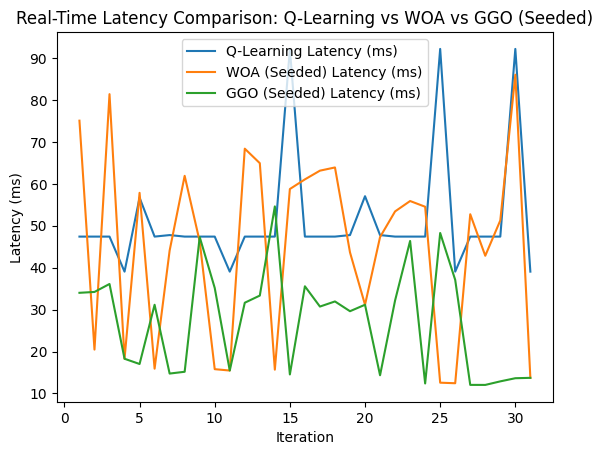

=== Running Q-Learning ===

[Q-Learning Results]
Q-Learning Path: [17, 6]
Total Latency = 47.418576625220986, Bottleneck BW = 846.0, Throughput = 660.0, Avg Jitter = 30.0, Avg Packet Loss = 0.14

=== Running WOA with RL-Path Seeding ===

[WOA (Seeded) Results]
WOA Best Path: [17, 4, 6]
Total Latency = 54.92132679822011, Bottleneck BW = 585.0, Throughput = 410.0, Avg Jitter = 9.0, Packet Loss = 2.835

[Q-Learning path was better or WOA path invalid.]
=== Running Q-Learning ===


KeyboardInterrupt: 

In [ ]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Lists to store iteration counts and latencies
iteration_list = []
latencies_q = []     # Q-Learning latency (baseline)
latencies_woa = []   # WOA (Seeded) latency
latencies_ggo = []   # GGO (Seeded) latency

iteration = 0

while True:
    # 1) Simulate real-time updates to the DataFrame (±10% on Latency)
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # 2) Run the merged WOA (Seeded) approach
    results_woa = merged_approach_with_woa_seed(
        df=df,
        env=env,  # Existing environment or builder function
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,   # Example parameter
        max_iter=50,   # Example parameter
        max_len=5,     # Example parameter
        b=1.0,
        a_decay=2.0
    )

    # 3) Run the merged GGO (Seeded) approach
    #    Assuming you have a similar function: merged_approach_with_ggo_seed(...)
    results_ggo = merged_approach_with_ggo_seed(
        df=df,
        env=env,
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,   # Example parameter
        max_iter=50,   # Example parameter
        max_len=3      # Example parameter
    )

    # 4) Extract Q-Learning metrics (baseline) from WOA run
    q_latency, q_bw, q_thr, q_jit, q_pl = results_woa["q_metrics"]

    # 5) Extract WOA (Seeded) metrics
    if results_woa["woa_metrics"] is not None:
        lat_woa, bw_woa, thr_woa, jit_woa, pl_woa = results_woa["woa_metrics"]
    else:
        lat_woa = None

    # 6) Extract GGO (Seeded) metrics
    if results_ggo["ggo_metrics"] is not None:
        lat_ggo, bw_ggo, thr_ggo, jit_ggo, pl_ggo = results_ggo["ggo_metrics"]
    else:
        lat_ggo = None

    # 7) Print the results for this iteration
    iteration += 1
    print(f"\n===== Iteration {iteration} =====\n")

    print("Q-Learning Path:")
    print("   ", results_woa["q_path"])
    print("Q-Learning Metrics:")
    print(f"   Total Latency = {q_latency}")
    print(f"   Bottleneck BW (Mbps) = {q_bw}")
    print(f"   Bottleneck Throughput (Mbps) = {q_thr}")
    print(f"   Avg Jitter (ms) = {q_jit}")
    print(f"   Avg Packet Loss (%) = {q_pl}")

    print("\nWOA (Seeded) Path:")
    print("   ", results_woa["woa_path"])
    if lat_woa is not None:
        print("WOA (Seeded) Metrics:")
        print(f"   Total Latency = {lat_woa}")
        print(f"   Bottleneck BW (Mbps) = {bw_woa}")
        print(f"   Bottleneck Throughput (Mbps) = {thr_woa}")
        print(f"   Avg Jitter (ms) = {jit_woa}")
        print(f"   Avg Packet Loss (%) = {pl_woa}")
    else:
        print("   No valid WOA path found or metrics could not be computed.")

    print("\nGGO (Seeded) Path:")
    print("   ", results_ggo["ggo_path"])
    if lat_ggo is not None:
        print("GGO (Seeded) Metrics:")
        print(f"   Total Latency = {lat_ggo}")
        print(f"   Bottleneck BW (Mbps) = {bw_ggo}")
        print(f"   Bottleneck Throughput (Mbps) = {thr_ggo}")
        print(f"   Avg Jitter (ms) = {jit_ggo}")
        print(f"   Avg Packet Loss (%) = {pl_ggo}")
    else:
        print("   No valid GGO path found or metrics could not be computed.")

    # 8) Store latencies for real-time plotting
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_woa.append(lat_woa if lat_woa else np.nan)
    latencies_ggo.append(lat_ggo if lat_ggo else np.nan)

    # 9) Update a real-time chart for latency comparison
    clear_output(wait=True)
    plt.figure()
    plt.plot(iteration_list, latencies_q, label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_woa, label='WOA (Seeded) Latency (ms)')
    plt.plot(iteration_list, latencies_ggo, label='GGO (Seeded) Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: Q-Learning vs WOA vs GGO (Seeded)")
    plt.legend()
    plt.show()

    # 10) Wait before the next iteration (optional)
    time.sleep(1)


# **7. Firefly Algorithm (FA) Implementation**

# FA (Seeded) Implementation
In a discrete path scenario, each firefly is a path. We adapt the FA main loop:
1. Evaluate each firefly's cost => light intensity
2. For each pair (i, j), if L_j < L_i (meaning cost_j < cost_i), move firefly i toward j
   using discrete logic (partial merging).
3. Keep track of the global best.

We define a simple distance between two paths, and a way to "move" i toward j by
replacing some nodes in i with corresponding nodes from j, plus random "tweaks".


In [ ]:
def run_fa_with_rl_seed(
    adjacency_matrix, node_to_index, nodes,
    fa_src, fa_dst, rl_path,
    pop_size=20, max_iter=50, max_len=5,
    alpha=0.3, beta0=1.0, gamma=1.0, verbose=True
):
    """
    Discrete Firefly Algorithm (FA) seeded by a Q-Learning path.

    Parameters:
    -----------
    - pop_size: number of fireflies
    - max_iter: number of iterations
    - max_len:  maximum path length
    - alpha:    randomization factor
    - beta0:    initial attractiveness
    - gamma:    absorption coefficient
    - adjacency_matrix, node_to_index, nodes: from build_adjacency_matrix
    - fa_src, fa_dst: source and destination
    - rl_path:  Q-Learning path used as one initial solution

    Returns: (best_path, best_cost, cost_history)
    """
    import random
    import numpy as np

    # 1) Initialize the firefly population
    population = [rl_path]  # seed with RL path
    for _ in range(pop_size - 1):
        population.append(generate_random_path(fa_src, fa_dst, adjacency_matrix, node_to_index, nodes, max_len))

    # 2) Compute initial costs
    costs = [compute_path_cost(p, adjacency_matrix, fa_dst, node_to_index) for p in population]
    best_idx = np.argmin(costs)
    best_path = population[best_idx]
    best_cost = costs[best_idx]

    cost_history = [best_cost]

    def path_distance(path1, path2):
        """
        A simple discrete 'distance' between two paths: e.g., the count of positions
        at which they differ. Alternatively, you could use path cost difference or
        another heuristic.
        """
        length = min(len(path1), len(path2))
        dist = 0
        for i in range(length):
            if path1[i] != path2[i]:
                dist += 1
        # plus difference in length
        dist += abs(len(path1) - len(path2))
        return dist

    def move_firefly(path_i, path_j, alpha, beta):
        """
        Move path_i "toward" path_j. We'll define a simple discrete operator:
        - For each position in path_i (excluding first & last if you want),
          with probability beta, copy from path_j.
        - Then apply random tweak with intensity alpha.
        """
        new_path = path_i[:]
        length = min(len(path_i), len(path_j))
        # Attract i to j
        for idx in range(1, length - 1):
            if random.random() < beta:
                new_path[idx] = path_j[idx]
        # Apply random tweak with probability alpha
        for idx in range(1, len(new_path) - 1):
            if random.random() < alpha:
                # pick a random neighbor from adjacency
                i_curr = node_to_index[new_path[idx]]
                possible_next = []
                for k in range(adjacency_matrix.shape[1]):
                    if adjacency_matrix[i_curr, k] != 0 and nodes[k] != new_path[idx]:
                        possible_next.append(nodes[k])
                if possible_next:
                    new_path[idx] = random.choice(possible_next)
        # Ensure last node is still the destination
        new_path[-1] = path_i[-1]
        return new_path

    # 3) Main FA loop
    for iteration in range(max_iter):
        # For each pair of fireflies (i, j)
        for i in range(pop_size):
            for j in range(pop_size):
                if i != j:
                    # If firefly_j is more attractive (lower cost) than firefly_i, move i towards j
                    if costs[j] < costs[i]:
                        rij = path_distance(population[i], population[j])
                        # compute attractiveness
                        beta = beta0 * np.exp(-gamma * (rij**2))
                        # move i towards j
                        new_path_i = move_firefly(population[i], population[j], alpha, beta)
                        new_cost_i = compute_path_cost(new_path_i, adjacency_matrix, fa_dst, node_to_index)
                        if new_cost_i < costs[i]:
                            population[i] = new_path_i
                            costs[i] = new_cost_i
                            # update global best if needed
                            if new_cost_i < best_cost:
                                best_cost = new_cost_i
                                best_path = new_path_i

        cost_history.append(best_cost)
        if verbose and (iteration + 1) % 10 == 0:
            print(f"FA Iter {iteration+1}/{max_iter}, Best Cost = {best_cost}")

    return best_path, best_cost, cost_history


 7.1 Merged Approach: Q-Learning + FA (Seeded)

 # Merged Approach with FA Seeding
We run Q-Learning to get an RL path, build the adjacency matrix, then run
the Firefly Algorithm seeded with that RL path. Finally, we compare results.


In [ ]:
def merged_approach_with_fa_seed(df, env, source, destination,
                                 pop_size=20, max_iter=50, max_len=5,
                                 alpha=0.3, beta0=1.0, gamma=1.0):
    """
    1) Run Q-Learning to get an RL path.
    2) Build adjacency matrix from df.
    3) Run FA *seeded* with that RL path.
    4) Compare results.
    """
    print("=== Running Q-Learning ===")
    q_table = run_Qlearning(env, alpha=0.05, gamma=0.99, eps_decay=0.85,
                            num_episodes=5000, min_epsilon=0.01, verbose=False)
    q_path, q_latency, q_bw, q_thr, q_jit, q_pl = evaluate_final_path(env, q_table)

    print("\n[Q-Learning Results]")
    print("Q-Learning Path:", q_path)
    print(f"Total Latency = {q_latency}, Bottleneck BW = {q_bw}, Throughput = {q_thr}, "
          f"Avg Jitter = {q_jit}, Avg Packet Loss = {q_pl}")

    # Build adjacency matrix
    A, node_to_index, nodes, edge_lookup = build_adjacency_matrix(df, metric='Latency_ms')

    # FA seeded with RL path
    print("\n=== Running Firefly Algorithm (FA) with RL-Path Seeding ===")
    fa_best_path, fa_best_cost, fa_cost_history = run_fa_with_rl_seed(
        adjacency_matrix=A,
        node_to_index=node_to_index,
        nodes=nodes,
        fa_src=source,
        fa_dst=destination,
        rl_path=q_path,
        pop_size=pop_size,
        max_iter=max_iter,
        max_len=max_len,
        alpha=alpha,
        beta0=beta0,
        gamma=gamma,
        verbose=False
    )

    # Evaluate the FA path
    fa_metrics = compute_path_metrics(fa_best_path, edge_lookup, destination)

    print("\n[FA (Seeded) Results]")
    print("FA Best Path:", fa_best_path)
    if fa_metrics:
        lat_fa, bw_fa, thr_fa, jit_fa, pl_fa = fa_metrics
        print(f"Total Latency = {lat_fa}, Bottleneck BW = {bw_fa}, "
              f"Throughput = {thr_fa}, Avg Jitter = {jit_fa}, Packet Loss = {pl_fa}")
    else:
        print("No valid path found by seeded FA or metrics invalid.")

    # Compare final latencies
    if fa_metrics and fa_metrics[0] < q_latency:
        print("\n[FA (seeded) found a better path than Q-Learning!]")
    else:
        print("\n[Q-Learning path was better or FA path invalid.]")

    return {
        "q_path": q_path,
        "q_metrics": (q_latency, q_bw, q_thr, q_jit, q_pl),
        "fa_path": fa_best_path,
        "fa_metrics": fa_metrics
    }


7.2 Real-Time Latency Comparison: Q-Learning vs FA vs GGO (Seeded)

# Real-Time Latency Comparison: Q-Learning vs FA vs GGO (Seeded)
This loop:
1. Randomly perturbs the DataFrame (e.g. ±10% on Latency).
2. Runs the merged FA (Seeded) approach and GGO approach (if available).
3. Extracts and prints Q-Learning, FA, and GGO results.
4. Plots latencies in real-time.

Adjust `time.sleep(1)` or remove for faster looping.
If you do NOT have GGO, remove that part of the code.


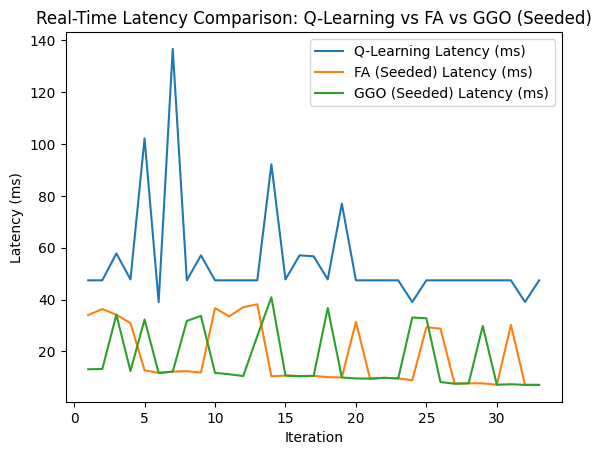

=== Running Q-Learning ===


KeyboardInterrupt: 

In [ ]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Lists to store iteration counts and latencies
iteration_list = []
latencies_q = []   # Q-Learning latency
latencies_fa = []  # FA (Seeded) latency
latencies_ggo = [] # GGO (Seeded) latency

iteration = 0

while True:
    # 1) Simulate real-time updates to the DataFrame (±10% on Latency)
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # 2) Run the merged FA (Seeded) approach
    results_fa = merged_approach_with_fa_seed(
        df=df,
        env=env,  # your environment
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,
        max_iter=50,
        max_len=5,
        alpha=0.3,   # example randomization factor
        beta0=1.0,   # example attractiveness factor
        gamma=1.0    # example absorption coefficient
    )

    # 3) Run the merged GGO (Seeded) approach (assuming you have it)
    results_ggo = merged_approach_with_ggo_seed(
        df=df,
        env=env,
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,
        max_iter=50,
        max_len=3
    )

    # 4) Extract Q-Learning metrics (baseline) from FA run
    q_latency, q_bw, q_thr, q_jit, q_pl = results_fa["q_metrics"]

    # 5) Extract FA (Seeded) metrics
    if results_fa["fa_metrics"] is not None:
        lat_fa, bw_fa, thr_fa, jit_fa, pl_fa = results_fa["fa_metrics"]
    else:
        lat_fa = None

    # 6) Extract GGO (Seeded) metrics
    if results_ggo["ggo_metrics"] is not None:
        lat_ggo, bw_ggo, thr_ggo, jit_ggo, pl_ggo = results_ggo["ggo_metrics"]
    else:
        lat_ggo = None

    # 7) Print results for this iteration
    iteration += 1
    print(f"\n===== Iteration {iteration} =====\n")

    print("Q-Learning Path:")
    print("   ", results_fa["q_path"])
    print("Q-Learning Metrics:")
    print(f"   Total Latency = {q_latency}")
    print(f"   Bottleneck BW (Mbps) = {q_bw}")
    print(f"   Bottleneck Throughput (Mbps) = {q_thr}")
    print(f"   Avg Jitter (ms) = {q_jit}")
    print(f"   Avg Packet Loss (%) = {q_pl}")

    print("\nFA (Seeded) Path:")
    print("   ", results_fa["fa_path"])
    if lat_fa is not None:
        print("FA (Seeded) Metrics:")
        print(f"   Total Latency = {lat_fa}")
        print(f"   Bottleneck BW (Mbps) = {bw_fa}")
        print(f"   Bottleneck Throughput (Mbps) = {thr_fa}")
        print(f"   Avg Jitter (ms) = {jit_fa}")
        print(f"   Avg Packet Loss (%) = {pl_fa}")
    else:
        print("   No valid FA path found or metrics could not be computed.")

    print("\nGGO (Seeded) Path:")
    print("   ", results_ggo["ggo_path"])
    if lat_ggo is not None:
        print("GGO (Seeded) Metrics:")
        print(f"   Total Latency = {lat_ggo}")
        print(f"   Bottleneck BW (Mbps) = {bw_ggo}")
        print(f"   Bottleneck Throughput (Mbps) = {thr_ggo}")
        print(f"   Avg Jitter (ms) = {jit_ggo}")
        print(f"   Avg Packet Loss (%) = {pl_ggo}")
    else:
        print("   No valid GGO path found or metrics could not be computed.")

    # 8) Store latencies for real-time plotting
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_fa.append(lat_fa if lat_fa else np.nan)
    latencies_ggo.append(lat_ggo if lat_ggo else np.nan)

    # 9) Real-time chart for latency comparison
    clear_output(wait=True)
    plt.figure()
    plt.plot(iteration_list, latencies_q, label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_fa, label='FA (Seeded) Latency (ms)')
    plt.plot(iteration_list, latencies_ggo, label='GGO (Seeded) Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: Q-Learning vs FA vs GGO (Seeded)")
    plt.legend()
    plt.show()

    # 10) Wait (optional)
    time.sleep(1)


# **8 Simulated Annealing (SA)**

8.1 Simulated Annealing Runner

# Simulated Annealing (SA) Implementation (Discrete / Path-Based)
We adapt SA for a discrete path problem:
1. Start with the Q-Learning path as the initial solution.
2. At each iteration, generate a "neighbor" path (e.g., partial random swap).
3. Compute the cost difference.
   - If the neighbor is better, accept.
   - If worse, accept with probability exp(-Δ / T).
4. Decrease the temperature T over time.


In [ ]:
import random
import numpy as np

def run_sa_with_rl_seed(
    adjacency_matrix, node_to_index, nodes,
    sa_src, sa_dst, rl_path,
    max_len=5,
    max_iter=50,
    initial_temp=100.0,
    alpha=0.95,
    verbose=True
):
    """
    Discrete Simulated Annealing (SA) approach seeded by a Q-Learning path.

    Parameters:
    -----------
    - adjacency_matrix, node_to_index, nodes: from build_adjacency_matrix(...)
    - sa_src, sa_dst: source, destination
    - rl_path: Q-Learning path to seed
    - max_len: maximum path length used for random path generation, etc.
    - max_iter: number of SA iterations
    - initial_temp: starting temperature
    - alpha: temperature decay factor, T <- alpha * T each iteration

    Returns: best_path, best_cost, cost_history
    """

    # Helper: function to mutate a path slightly (neighbor)
    def neighbor_path(path):
        """
        Generate a neighbor path by randomly modifying a node in the path (excluding src/dst).
        For instance, pick a random index j in [1..len-2] and replace it with a random feasible neighbor
        from adjacency. If path is too short, consider adding or removing a node, etc.
        This is a simple placeholder – adapt to your constraints.
        """
        if len(path) <= 2:
            return path[:]  # can't mutate much if there's only src/dst

        new_p = path[:]
        idx = random.randint(1, len(path) - 2)  # pick a random position in middle
        current_node = new_p[idx]
        i_curr = node_to_index[current_node]

        # gather possible neighbors (excluding itself)
        possible_next = []
        for k in range(adjacency_matrix.shape[1]):
            if adjacency_matrix[i_curr, k] != 0 and nodes[k] != current_node:
                possible_next.append(nodes[k])

        if possible_next:
            new_p[idx] = random.choice(possible_next)
        return new_p

    # 1) Initialize
    current_path = rl_path[:]
    current_cost = compute_path_cost(current_path, adjacency_matrix, sa_dst, node_to_index)
    best_path = current_path[:]
    best_cost = current_cost
    cost_history = [best_cost]

    temp = initial_temp

    # 2) Main SA loop
    for iteration in range(max_iter):
        # Generate a neighbor solution
        new_p = neighbor_path(current_path)
        new_cost = compute_path_cost(new_p, adjacency_matrix, sa_dst, node_to_index)
        delta = new_cost - current_cost

        # Acceptance criteria
        if delta < 0:
            # Better solution, accept
            current_path = new_p
            current_cost = new_cost
        else:
            # Accept with probability exp(-delta / T)
            if random.random() < np.exp(-delta / temp):
                current_path = new_p
                current_cost = new_cost

        # Update best
        if current_cost < best_cost:
            best_cost = current_cost
            best_path = current_path[:]

        # Decay temperature
        temp *= alpha

        cost_history.append(best_cost)
        if verbose and (iteration+1) % 10 == 0:
            print(f"SA Iter {iteration+1}/{max_iter}, Best Cost = {best_cost}, Temp={temp:.4f}")

    return best_path, best_cost, cost_history


*8.2 Merged Approach with SA Seeding

# Merged Approach with SA Seeding
1) Run Q-Learning
2) Build adjacency matrix
3) Run the discrete Simulated Annealing seeded with RL path
4) Compare final results*

In [ ]:
def merged_approach_with_sa_seed(df, env, source, destination,
                                 max_len=5, max_iter=50,
                                 initial_temp=100.0, alpha=0.95):
    print("=== Running Q-Learning ===")
    q_table = run_Qlearning(env, alpha=0.05, gamma=0.99, eps_decay=0.85,
                            num_episodes=5000, min_epsilon=0.01, verbose=False)
    q_path, q_latency, q_bw, q_thr, q_jit, q_pl = evaluate_final_path(env, q_table)

    print("\n[Q-Learning Results]")
    print("Q-Learning Path:", q_path)
    print(f"Total Latency = {q_latency}, Bottleneck BW = {q_bw}, "
          f"Throughput = {q_thr}, Avg Jitter = {q_jit}, Packet Loss = {q_pl}")

    # Build adjacency
    A, node_to_index, nodes, edge_lookup = build_adjacency_matrix(df, metric='Latency_ms')

    # SA
    print("\n=== Running SA with RL-Path Seeding ===")
    sa_best_path, sa_best_cost, sa_cost_history = run_sa_with_rl_seed(
        adjacency_matrix=A,
        node_to_index=node_to_index,
        nodes=nodes,
        sa_src=source,
        sa_dst=destination,
        rl_path=q_path,
        max_len=max_len,
        max_iter=max_iter,
        initial_temp=initial_temp,
        alpha=alpha,
        verbose=False
    )

    sa_metrics = compute_path_metrics(sa_best_path, edge_lookup, destination)

    print("\n[SA (Seeded) Results]")
    print("SA Best Path:", sa_best_path)
    if sa_metrics:
        lat_sa, bw_sa, thr_sa, jit_sa, pl_sa = sa_metrics
        print(f"Total Latency = {lat_sa}, Bottleneck BW = {bw_sa}, "
              f"Throughput = {thr_sa}, Avg Jitter = {jit_sa}, Packet Loss = {pl_sa}")
    else:
        print("No valid path found or invalid SA path metrics.")

    if sa_metrics and sa_metrics[0] < q_latency:
        print("\n[SA (seeded) found a better path than Q-Learning!]")
    else:
        print("\n[Q-Learning path was better or SA path invalid.]")

    return {
        "q_path": q_path,
        "q_metrics": (q_latency, q_bw, q_thr, q_jit, q_pl),
        "sa_path": sa_best_path,
        "sa_metrics": sa_metrics
    }


# Real-Time Latency Comparison: Q-Learning vs SA (Seeded)
This loop:
1) Randomly perturbs df['Latency_ms'] by ±10%
2) Calls `merged_approach_with_sa_seed` (which internally runs Q-Learning + SA seeded with Q-Path)
3) Compares latencies of Q-Learning path vs. SA path in real-time
4) Plots them


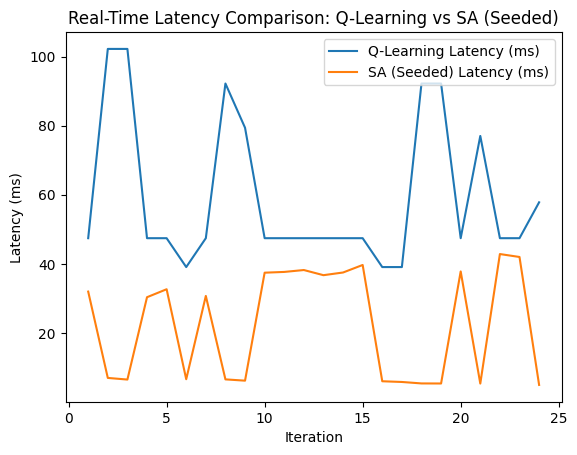

=== Running Q-Learning ===


KeyboardInterrupt: 

In [ ]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

iteration_list = []
latencies_q = []
latencies_sa = []

iteration = 0

while True:
    # 1) Simulate real-time updates to df's latency values (±10%)
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # 2) Run Q-Learning + SA approach
    results_sa = merged_approach_with_sa_seed(
        df=df,
        env=env,  # your environment
        source=test_source_node,
        destination=test_destination_node,
        max_len=5,
        max_iter=50,
        initial_temp=100.0,
        alpha=0.95
    )

    # 3) Extract Q-Learning metrics
    q_latency, q_bw, q_thr, q_jit, q_pl = results_sa["q_metrics"]

    # 4) Extract SA metrics
    sa_metrics = results_sa["sa_metrics"]
    if sa_metrics is not None:
        lat_sa, bw_sa, thr_sa, jit_sa, pl_sa = sa_metrics
    else:
        lat_sa = None

    # 5) Print results
    iteration += 1
    print(f"\n===== SA Iteration {iteration} =====\n")

    print("[Q-Learning Path]")
    print("   ", results_sa["q_path"])
    print("[Q-Learning Metrics]")
    print(f"   Latency = {q_latency}, BW = {q_bw}, Thr = {q_thr}, Jitter = {q_jit}, PL = {q_pl}")

    print("\n[SA (Seeded) Path]")
    print("   ", results_sa["sa_path"])
    if lat_sa is not None:
        print("[SA Metrics]")
        print(f"   Latency = {lat_sa}, BW = {bw_sa}, Thr = {thr_sa}, Jitter = {jit_sa}, PL = {pl_sa}")
    else:
        print("   No valid SA path found.")

    # 6) Collect data for plotting
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_sa.append(lat_sa if lat_sa else np.nan)

    # 7) Real-time plotting
    clear_output(wait=True)
    plt.figure()
    plt.plot(iteration_list, latencies_q, label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_sa, label='SA (Seeded) Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: Q-Learning vs SA (Seeded)")
    plt.legend()
    plt.show()

    # 8) Optional wait
    time.sleep(1)


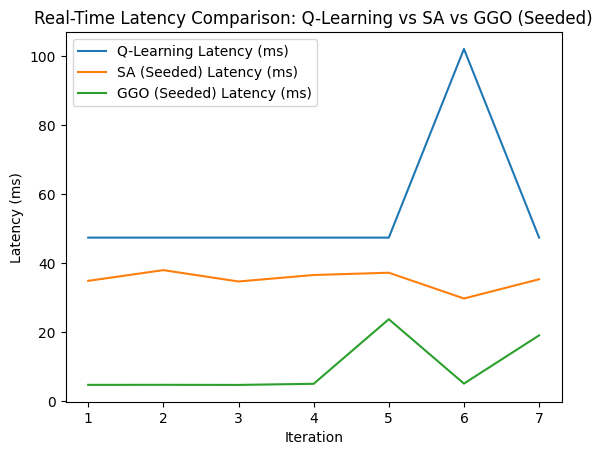

KeyboardInterrupt: 

In [ ]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

# Lists to keep track of iteration and latencies for each approach
iteration_list = []
latencies_q = []    # Q-Learning latency
latencies_sa = []   # SA (Seeded) latency
latencies_ggo = []  # GGO (Seeded) latency

iteration = 0

while True:
    # 1) Simulate real-time updates to df's latency values (±10%)
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # 2) Run Q-Learning + SA approach
    results_sa = merged_approach_with_sa_seed(
        df=df,
        env=env,  # your environment
        source=test_source_node,
        destination=test_destination_node,
        max_len=5,
        max_iter=50,
        initial_temp=100.0,
        alpha=0.95
    )

    # 3) Run Q-Learning + GGO approach
    #    This also runs Q-Learning internally; we typically use the same environment & df
    results_ggo = merged_approach_with_ggo_seed(
        df=df,
        env=env,
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,
        max_iter=50,
        max_len=3
    )

    # 4) Extract Q-Learning metrics (baseline) from the SA run (or GGO run)
    #    Both 'results_sa' and 'results_ggo' run Q-Learning internally, but we only need one set.
    q_latency, q_bw, q_thr, q_jit, q_pl = results_sa["q_metrics"]

    # 5) Extract SA metrics
    sa_metrics = results_sa["sa_metrics"]
    if sa_metrics is not None:
        lat_sa, bw_sa, thr_sa, jit_sa, pl_sa = sa_metrics
    else:
        lat_sa = None

    # 6) Extract GGO metrics
    ggo_metrics = results_ggo["ggo_metrics"]
    if ggo_metrics is not None:
        lat_ggo, bw_ggo, thr_ggo, jit_ggo, pl_ggo = ggo_metrics
    else:
        lat_ggo = None

    # 7) Print results
    iteration += 1
    print(f"\n===== Iteration {iteration} =====\n")

    # Q-Learning
    print("[Q-Learning Path]")
    print("   ", results_sa["q_path"])  # same as results_ggo["q_path"] typically
    print("[Q-Learning Metrics]")
    print(f"   Latency = {q_latency}, BW = {q_bw}, Thr = {q_thr}, Jitter = {q_jit}, PL = {q_pl}")

    # SA
    print("\n[SA (Seeded) Path]")
    print("   ", results_sa["sa_path"])
    if lat_sa is not None:
        print("[SA Metrics]")
        print(f"   Latency = {lat_sa}, BW = {bw_sa}, Thr = {thr_sa}, Jitter = {jit_sa}, PL = {pl_sa}")
    else:
        print("   No valid SA path found.")

    # GGO
    print("\n[GGO (Seeded) Path]")
    print("   ", results_ggo["ggo_path"])
    if lat_ggo is not None:
        print("[GGO Metrics]")
        print(f"   Latency = {lat_ggo}, BW = {bw_ggo}, Thr = {thr_ggo}, Jitter = {jit_ggo}, PL = {pl_ggo}")
    else:
        print("   No valid GGO path found.")

    # 8) Collect data for plotting
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_sa.append(lat_sa if lat_sa else np.nan)
    latencies_ggo.append(lat_ggo if lat_ggo else np.nan)

    # 9) Real-time plotting
    clear_output(wait=True)
    plt.figure()
    plt.plot(iteration_list, latencies_q,    label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_sa,   label='SA (Seeded) Latency (ms)')
    plt.plot(iteration_list, latencies_ggo,  label='GGO (Seeded) Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: Q-Learning vs SA vs GGO (Seeded)")
    plt.legend()
    plt.show()

    # 10) Optional wait
    time.sleep(1)


# **9 Bat Algorithm**

9.1 Bat Algorithm Runner

# Bat Algorithm (Discrete / Path-Based)
We adapt the continuous bat algorithm to a discrete path scenario:
- Each bat is a path.
- We'll store a "velocity"-like structure, but in discrete form we treat it as partial merges or random changes.
- Use loudness (A) and pulse rate (r) to manage random exploration vs exploitation.
- We'll keep a global best path for guidance.


In [ ]:
def run_bat_with_rl_seed(
    adjacency_matrix, node_to_index, nodes,
    bat_src, bat_dst, rl_path,
    pop_size=20, max_iter=50, max_len=5,
    loudness=0.5, pulse_rate=0.5, alpha=0.9, gamma=0.9,
    verbose=True
):
    """
    Discrete Bat Algorithm seeded by a Q-Learning path.
    pop_size: number of bats
    max_iter: number of iterations
    loudness (A), pulse_rate (r): initial values
    alpha, gamma: for updating A and r after each iteration (A <- alpha*A, r <- r*(1-exp(-gamma*t)) typically)

    In discrete form, we:
    1) Initialize population of paths + velocities (velocities are conceptual).
    2) Update each bat:
       - If random > pulse_rate, do local search near best path or random tweak.
       - Evaluate cost, if improvement or random < loudness, accept.
    3) Decrease loudness, increase pulse rate over time.

    Returns: (best_path, best_cost, cost_history)
    """
    import random
    import numpy as np

    # Initialize population
    population = [rl_path]
    for _ in range(pop_size - 1):
        population.append(generate_random_path(bat_src, bat_dst, adjacency_matrix, node_to_index, nodes, max_len))

    # Evaluate costs
    costs = [compute_path_cost(p, adjacency_matrix, bat_dst, node_to_index) for p in population]
    best_idx = np.argmin(costs)
    best_path = population[best_idx]
    best_cost = costs[best_idx]
    cost_history = [best_cost]

    # We'll store "velocity" as just references for each bat to a path or do random merges
    velocities = [None]*pop_size  # Not heavily used in discrete form

    current_loudness = loudness
    current_pulse_rate = pulse_rate

    def local_search(path, best_path):
        """
        Simple local search near best_path: partial merge or random tweak.
        """
        new_path = path[:]
        length = min(len(path), len(best_path))
        for idx in range(1, length-1):
            if random.random() < 0.5:
                new_path[idx] = best_path[idx]
        # random tweak
        if length > 2:
            i_rand = random.randint(1, length-2)
            new_path[i_rand] = random.choice(nodes)  # random replacement
        # keep final node
        new_path[-1] = path[-1]
        return new_path

    # Main loop
    for iteration in range(max_iter):
        for i in range(pop_size):
            current_path = population[i]
            current_cost = costs[i]

            # "Frequency" update (not used in discrete example, but we keep it for structure)
            freq = random.random()

            # If random > pulse_rate => local search around best
            if random.random() > current_pulse_rate:
                candidate_path = local_search(current_path, best_path)
            else:
                # Otherwise do a random tweak or partial merge
                candidate_path = local_search(current_path, current_path)

            candidate_cost = compute_path_cost(candidate_path, adjacency_matrix, bat_dst, node_to_index)

            # Check if we accept this candidate
            if (candidate_cost < current_cost) and (random.random() < current_loudness):
                population[i] = candidate_path
                costs[i] = candidate_cost

                # Update global best
                if candidate_cost < best_cost:
                    best_path = candidate_path
                    best_cost = candidate_cost

        # Update loudness & pulse rate
        current_loudness *= alpha
        # Example update for pulse rate: r = r0*(1-exp(-gamma*t)) - or a simpler linear approach
        current_pulse_rate = pulse_rate*(1 - np.exp(-gamma*(iteration+1)))

        cost_history.append(best_cost)
        if verbose and (iteration+1) % 10 == 0:
            print(f"Bat Iter {iteration+1}/{max_iter}, Best Cost={best_cost}, Loudness={current_loudness:.3f}, r={current_pulse_rate:.3f}")

    return best_path, best_cost, cost_history


9.2 Merged Approach with Bat Seeding
# Merged Approach with Bat Seeding
1) Run Q-Learning
2) Build adjacency matrix
3) Run the Bat Algorithm seeded with RL path
4) Compare results


In [ ]:
def merged_approach_with_bat_seed(df, env, source, destination,
                                  pop_size=20, max_iter=50, max_len=5,
                                  loudness=0.5, pulse_rate=0.5, alpha=0.9, gamma=0.9):
    print("=== Running Q-Learning ===")
    q_table = run_Qlearning(env, alpha=0.05, gamma=0.99, eps_decay=0.85,
                            num_episodes=5000, min_epsilon=0.01, verbose=False)
    q_path, q_latency, q_bw, q_thr, q_jit, q_pl = evaluate_final_path(env, q_table)

    print("\n[Q-Learning Results]")
    print("Q-Learning Path:", q_path)
    print(f"Total Latency = {q_latency}, Bottleneck BW = {q_bw}, Throughput = {q_thr}, "
          f"Avg Jitter = {q_jit}, Packet Loss = {q_pl}")

    # Build adjacency
    A, node_to_index, nodes, edge_lookup = build_adjacency_matrix(df, metric='Latency_ms')

    # Bat
    print("\n=== Running Bat Algorithm (Seeded) ===")
    bat_best_path, bat_best_cost, bat_cost_history = run_bat_with_rl_seed(
        adjacency_matrix=A,
        node_to_index=node_to_index,
        nodes=nodes,
        bat_src=source,
        bat_dst=destination,
        rl_path=q_path,
        pop_size=pop_size,
        max_iter=max_iter,
        max_len=max_len,
        loudness=loudness,
        pulse_rate=pulse_rate,
        alpha=alpha,
        gamma=gamma,
        verbose=False
    )

    bat_metrics = compute_path_metrics(bat_best_path, edge_lookup, destination)

    print("\n[Bat Algorithm (Seeded) Results]")
    print("Bat Best Path:", bat_best_path)
    if bat_metrics:
        lat_bat, bw_bat, thr_bat, jit_bat, pl_bat = bat_metrics
        print(f"Total Latency = {lat_bat}, Bottleneck BW = {bw_bat}, "
              f"Throughput = {thr_bat}, Avg Jitter = {jit_bat}, Packet Loss = {pl_bat}")
    else:
        print("No valid path found or invalid bat path metrics.")

    if bat_metrics and bat_metrics[0] < q_latency:
        print("\n[Bat (seeded) found a better path than Q-Learning!]")
    else:
        print("\n[Q-Learning path was better or Bat path invalid.]")

    return {
        "q_path": q_path,
        "q_metrics": (q_latency, q_bw, q_thr, q_jit, q_pl),
        "bat_path": bat_best_path,
        "bat_metrics": bat_metrics
    }


# Real-Time Latency Comparison: Q-Learning vs Bat (Seeded)
This loop:
1) Randomly perturbs df['Latency_ms'] by ±10%
2) Calls `merged_approach_with_bat_seed` (which internally runs Q-Learning + Bat seeded with Q-Path)
3) Compares latencies of Q-Learning path vs. Bat path in real-time
4) Plots them


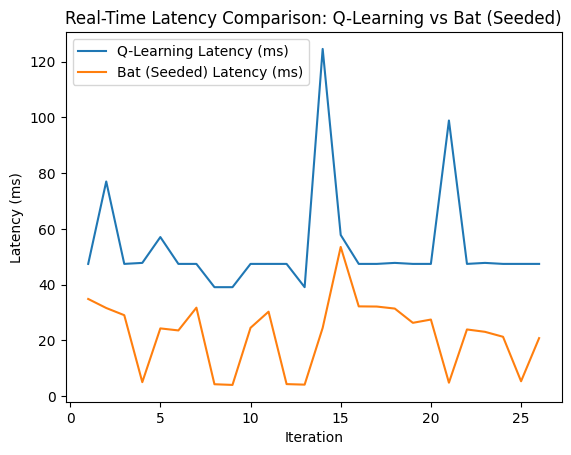

KeyboardInterrupt: 

In [ ]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

iteration_list = []
latencies_q = []
latencies_bat = []

iteration = 0

while True:
    # 1) Simulate real-time updates to df's latency values (±10%)
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # 2) Run Q-Learning + Bat approach
    results_bat = merged_approach_with_bat_seed(
        df=df,
        env=env,  # your environment
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,
        max_iter=50,
        max_len=5,
        loudness=0.5,
        pulse_rate=0.5,
        alpha=0.9,
        gamma=0.9
    )

    # 3) Extract Q-Learning metrics
    q_latency, q_bw, q_thr, q_jit, q_pl = results_bat["q_metrics"]

    # 4) Extract Bat metrics
    bat_metrics = results_bat["bat_metrics"]
    if bat_metrics is not None:
        lat_bat, bw_bat, thr_bat, jit_bat, pl_bat = bat_metrics
    else:
        lat_bat = None

    # 5) Print results
    iteration += 1
    print(f"\n===== Bat Iteration {iteration} =====\n")

    print("[Q-Learning Path]")
    print("   ", results_bat["q_path"])
    print("[Q-Learning Metrics]")
    print(f"   Latency = {q_latency}, BW = {q_bw}, Thr = {q_thr}, Jitter = {q_jit}, PL = {q_pl}")

    print("\n[Bat (Seeded) Path]")
    print("   ", results_bat["bat_path"])
    if lat_bat is not None:
        print("[Bat Metrics]")
        print(f"   Latency = {lat_bat}, BW = {bw_bat}, Thr = {thr_bat}, Jitter = {jit_bat}, PL = {pl_bat}")
    else:
        print("   No valid Bat path found.")

    # 6) Collect data for plotting
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_bat.append(lat_bat if lat_bat else np.nan)

    # 7) Real-time plotting
    clear_output(wait=True)
    plt.figure()
    plt.plot(iteration_list, latencies_q, label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_bat, label='Bat (Seeded) Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: Q-Learning vs Bat (Seeded)")
    plt.legend()
    plt.show()

    # 8) Optional wait
    time.sleep(1)


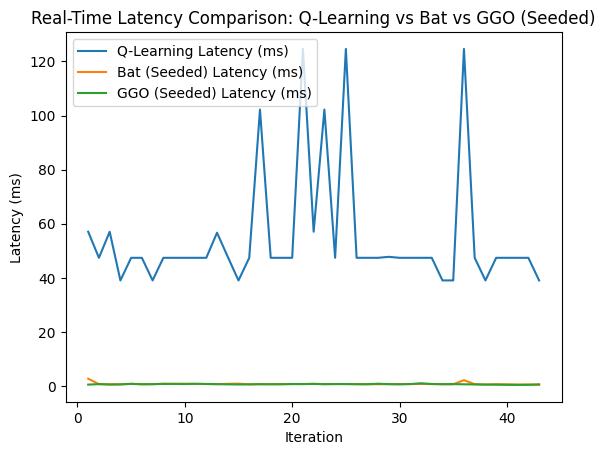

KeyboardInterrupt: 

In [ ]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

# Lists to keep track of iteration and latencies
iteration_list = []
latencies_q = []    # Q-Learning latency
latencies_bat = []  # Bat (Seeded) latency
latencies_ggo = []  # GGO (Seeded) latency

iteration = 0

while True:
    # 1) Simulate real-time updates to df's latency values (±10%)
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # 2) Run Q-Learning + Bat approach
    results_bat = merged_approach_with_bat_seed(
        df=df,
        env=env,  # your environment
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,
        max_iter=50,
        max_len=5,
        loudness=0.5,
        pulse_rate=0.5,
        alpha=0.9,
        gamma=0.9
    )

    # 3) Run Q-Learning + GGO approach
    #    This also runs Q-Learning internally. We'll just extract GGO metrics from it.
    results_ggo = merged_approach_with_ggo_seed(
        df=df,
        env=env,
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,
        max_iter=50,
        max_len=3
    )

    # 4) Extract Q-Learning metrics (baseline) from the Bat run
    q_latency, q_bw, q_thr, q_jit, q_pl = results_bat["q_metrics"]

    # 5) Extract Bat metrics
    bat_metrics = results_bat["bat_metrics"]
    if bat_metrics is not None:
        lat_bat, bw_bat, thr_bat, jit_bat, pl_bat = bat_metrics
    else:
        lat_bat = None

    # 6) Extract GGO metrics
    ggo_metrics = results_ggo["ggo_metrics"]
    if ggo_metrics is not None:
        lat_ggo, bw_ggo, thr_ggo, jit_ggo, pl_ggo = ggo_metrics
    else:
        lat_ggo = None

    # 7) Print results
    iteration += 1
    print(f"\n===== Iteration {iteration} =====\n")

    # Q-Learning
    print("[Q-Learning Path]")
    print("   ", results_bat["q_path"])  # same as results_ggo["q_path"], typically
    print("[Q-Learning Metrics]")
    print(f"   Latency = {q_latency}, BW = {q_bw}, Thr = {q_thr}, Jitter = {q_jit}, PL = {q_pl}")

    # Bat
    print("\n[Bat (Seeded) Path]")
    print("   ", results_bat["bat_path"])
    if lat_bat is not None:
        print("[Bat Metrics]")
        print(f"   Latency = {lat_bat}, BW = {bw_bat}, Thr = {thr_bat}, Jitter = {jit_bat}, PL = {pl_bat}")
    else:
        print("   No valid Bat path found.")

    # GGO
    print("\n[GGO (Seeded) Path]")
    print("   ", results_ggo["ggo_path"])
    if lat_ggo is not None:
        print("[GGO Metrics]")
        print(f"   Latency = {lat_ggo}, BW = {bw_ggo}, Thr = {thr_ggo}, Jitter = {jit_ggo}, PL = {pl_ggo}")
    else:
        print("   No valid GGO path found.")

    # 8) Collect data for plotting
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_bat.append(lat_bat if lat_bat else np.nan)
    latencies_ggo.append(lat_ggo if lat_ggo else np.nan)

    # 9) Real-time plotting
    clear_output(wait=True)
    plt.figure()
    plt.plot(iteration_list, latencies_q,   label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_bat, label='Bat (Seeded) Latency (ms)')
    plt.plot(iteration_list, latencies_ggo, label='GGO (Seeded) Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: Q-Learning vs Bat vs GGO (Seeded)")
    plt.legend()
    plt.show()

    # 10) Optional pause before next iteration
    time.sleep(1)


# **10 Cuckoo Search Algorithm**


10.1 Cuckoo Search Runner
# Cuckoo Search (Discrete / Path-Based)
Basic steps:
1. Each nest is a path.
2. Generate new cuckoos (paths) via "Levy flight" or random partial merges/tweaks from a random nest.
3. Evaluate cost; if better, replace a random nest.
4. A fraction 'pa' of the worst nests are abandoned and replaced with new random solutions.
We keep track of the best path overall.


In [ ]:
def run_cuckoo_with_rl_seed(
    adjacency_matrix, node_to_index, nodes,
    cuckoo_src, cuckoo_dst, rl_path,
    pop_size=20, max_iter=50, max_len=5,
    pa=0.25,  # fraction of nests to abandon
    verbose=True
):
    """
    Discrete Cuckoo Search seeded by Q-Learning path.
    pop_size: number of nests
    max_iter: number of iterations
    pa: fraction of worst nests abandoned each iteration

    In discrete approach, "Levy flight" can be approximated as random path changes or partial merges.
    """

    import random
    import numpy as np

    # Initialize population
    population = [rl_path]
    for _ in range(pop_size - 1):
        population.append(generate_random_path(cuckoo_src, cuckoo_dst, adjacency_matrix, node_to_index, nodes, max_len))

    # Evaluate
    costs = [compute_path_cost(p, adjacency_matrix, cuckoo_dst, node_to_index) for p in population]
    best_idx = np.argmin(costs)
    best_path = population[best_idx]
    best_cost = costs[best_idx]
    cost_history = [best_cost]

    def levy_flight(path):
        """
        Simplified random 'flight' for discrete path:
        e.g., do 1-2 random changes in the path.
        """
        new_path = path[:]
        num_changes = random.randint(1, 2)
        for _ in range(num_changes):
            if len(new_path) > 2:
                idx = random.randint(1, len(new_path)-2)
                # random feasible neighbor
                i_curr = node_to_index[new_path[idx]]
                possible_next = []
                for k in range(adjacency_matrix.shape[1]):
                    if adjacency_matrix[i_curr, k] != 0 and nodes[k] != new_path[idx]:
                        possible_next.append(nodes[k])
                if possible_next:
                    new_path[idx] = random.choice(possible_next)
        return new_path

    # Main loop
    for iteration in range(max_iter):
        # For each cuckoo
        for i in range(pop_size):
            # 1) Generate a new solution by levy flight from nest i
            new_path = levy_flight(population[i])
            new_cost = compute_path_cost(new_path, adjacency_matrix, cuckoo_dst, node_to_index)

            # 2) Pick a random nest j
            j = random.randint(0, pop_size-1)

            # 3) If better, replace nest j
            if new_cost < costs[j]:
                population[j] = new_path
                costs[j] = new_cost
                # Update best if needed
                if new_cost < best_cost:
                    best_cost = new_cost
                    best_path = new_path

        # Abandon a fraction 'pa' of the worst nests
        #  - find the indices of the worst
        sorted_indices = np.argsort(costs)  # ascending
        num_abandon = int(pa * pop_size)
        worst_indices = sorted_indices[-num_abandon:]
        for w in worst_indices:
            # replace with a new random path
            population[w] = generate_random_path(cuckoo_src, cuckoo_dst, adjacency_matrix, node_to_index, nodes, max_len)
            costs[w] = compute_path_cost(population[w], adjacency_matrix, cuckoo_dst, node_to_index)
            # check best
            if costs[w] < best_cost:
                best_cost = costs[w]
                best_path = population[w]

        cost_history.append(best_cost)
        if verbose and (iteration+1) % 10 == 0:
            print(f"Cuckoo Iter {iteration+1}/{max_iter}, Best Cost={best_cost}")

    return best_path, best_cost, cost_history


10.2 Merged Approach with Cuckoo Seeding

In [ ]:
def merged_approach_with_cuckoo_seed(df, env, source, destination,
                                     pop_size=20, max_iter=50, max_len=5,
                                     pa=0.25):
    print("=== Running Q-Learning ===")
    q_table = run_Qlearning(env, alpha=0.05, gamma=0.99, eps_decay=0.85,
                            num_episodes=5000, min_epsilon=0.01, verbose=False)
    q_path, q_latency, q_bw, q_thr, q_jit, q_pl = evaluate_final_path(env, q_table)

    print("\n[Q-Learning Results]")
    print("Q-Learning Path:", q_path)
    print(f"Total Latency = {q_latency}, Bottleneck BW = {q_bw}, Throughput = {q_thr}, "
          f"Avg Jitter = {q_jit}, Packet Loss = {q_pl}")

    # Build adjacency
    A, node_to_index, nodes, edge_lookup = build_adjacency_matrix(df, metric='Latency_ms')

    # Cuckoo
    print("\n=== Running Cuckoo Search (Seeded) ===")
    cuckoo_best_path, cuckoo_best_cost, cuckoo_cost_history = run_cuckoo_with_rl_seed(
        adjacency_matrix=A,
        node_to_index=node_to_index,
        nodes=nodes,
        cuckoo_src=source,
        cuckoo_dst=destination,
        rl_path=q_path,
        pop_size=pop_size,
        max_iter=max_iter,
        max_len=max_len,
        pa=pa,
        verbose=False
    )

    cuckoo_metrics = compute_path_metrics(cuckoo_best_path, edge_lookup, destination)

    print("\n[Cuckoo (Seeded) Results]")
    print("Cuckoo Best Path:", cuckoo_best_path)
    if cuckoo_metrics:
        lat_ck, bw_ck, thr_ck, jit_ck, pl_ck = cuckoo_metrics
        print(f"Total Latency = {lat_ck}, Bottleneck BW = {bw_ck}, "
              f"Throughput = {thr_ck}, Avg Jitter = {jit_ck}, Packet Loss = {pl_ck}")
    else:
        print("No valid path found or invalid cuckoo path metrics.")

    if cuckoo_metrics and cuckoo_metrics[0] < q_latency:
        print("\n[Cuckoo (seeded) found a better path than Q-Learning!]")
    else:
        print("\n[Q-Learning path was better or Cuckoo path invalid.]")

    return {
        "q_path": q_path,
        "q_metrics": (q_latency, q_bw, q_thr, q_jit, q_pl),
        "cuckoo_path": cuckoo_best_path,
        "cuckoo_metrics": cuckoo_metrics
    }


# Real-Time Latency Comparison: Q-Learning vs Cuckoo (Seeded)
This loop:
1) Randomly perturbs df['Latency_ms'] by ±10%
2) Calls `merged_approach_with_cuckoo_seed` (Q-Learning + Cuckoo seeded with Q-Path)
3) Compares latencies of Q-Learning path vs. Cuckoo path in real-time
4) Plots them


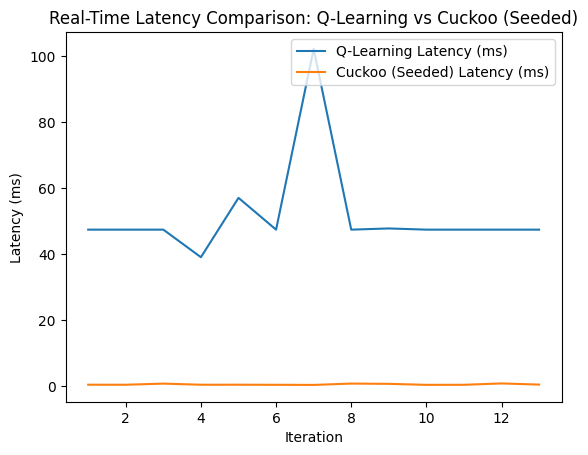

KeyboardInterrupt: 

In [ ]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

iteration_list = []
latencies_q = []
latencies_ck = []

iteration = 0

while True:
    # 1) Simulate real-time updates to df's latency values (±10%)
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # 2) Run Q-Learning + Cuckoo approach
    results_ck = merged_approach_with_cuckoo_seed(
        df=df,
        env=env,  # your environment
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,
        max_iter=50,
        max_len=5,
        pa=0.25
    )

    # 3) Extract Q-Learning metrics
    q_latency, q_bw, q_thr, q_jit, q_pl = results_ck["q_metrics"]

    # 4) Extract Cuckoo metrics
    ck_metrics = results_ck["cuckoo_metrics"]
    if ck_metrics is not None:
        lat_ck, bw_ck, thr_ck, jit_ck, pl_ck = ck_metrics
    else:
        lat_ck = None

    # 5) Print results
    iteration += 1
    print(f"\n===== Cuckoo Iteration {iteration} =====\n")

    print("[Q-Learning Path]")
    print("   ", results_ck["q_path"])
    print("[Q-Learning Metrics]")
    print(f"   Latency = {q_latency}, BW = {q_bw}, Thr = {q_thr}, Jitter = {q_jit}, PL = {q_pl}")

    print("\n[Cuckoo (Seeded) Path]")
    print("   ", results_ck["cuckoo_path"])
    if lat_ck is not None:
        print("[Cuckoo Metrics]")
        print(f"   Latency = {lat_ck}, BW = {bw_ck}, Thr = {thr_ck}, Jitter = {jit_ck}, PL = {pl_ck}")
    else:
        print("   No valid Cuckoo path found.")

    # 6) Collect data for plotting
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_ck.append(lat_ck if lat_ck else np.nan)

    # 7) Real-time plotting
    clear_output(wait=True)
    plt.figure()
    plt.plot(iteration_list, latencies_q, label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_ck, label='Cuckoo (Seeded) Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: Q-Learning vs Cuckoo (Seeded)")
    plt.legend()
    plt.show()

    # 8) Optional wait
    time.sleep(1)


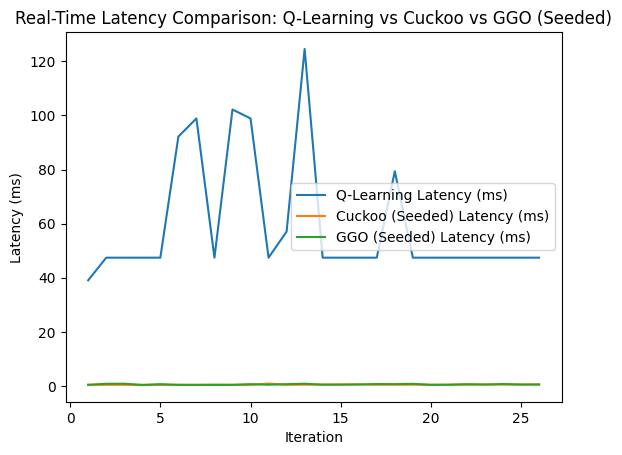

KeyboardInterrupt: 

In [ ]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

# Lists to keep track of iteration and latencies
iteration_list = []
latencies_q = []   # Q-Learning latency
latencies_ck = []  # Cuckoo (Seeded) latency
latencies_ggo = [] # GGO (Seeded) latency

iteration = 0

while True:
    # 1) Simulate real-time updates to df's latency values (±10%)
    df['Latency_ms'] = df['Latency_ms'] * np.random.uniform(0.9, 1.1, size=len(df))

    # 2) Run Q-Learning + Cuckoo approach
    results_ck = merged_approach_with_cuckoo_seed(
        df=df,
        env=env,  # your environment
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,
        max_iter=50,
        max_len=5,
        pa=0.25
    )

    # 3) Run Q-Learning + GGO approach
    results_ggo = merged_approach_with_ggo_seed(
        df=df,
        env=env,
        source=test_source_node,
        destination=test_destination_node,
        pop_size=20,
        max_iter=50,
        max_len=3
    )

    # 4) Extract Q-Learning metrics (baseline) from the Cuckoo run
    #    (both approaches run Q-Learning internally, so we only need one set).
    q_latency, q_bw, q_thr, q_jit, q_pl = results_ck["q_metrics"]

    # 5) Extract Cuckoo metrics
    ck_metrics = results_ck["cuckoo_metrics"]
    if ck_metrics is not None:
        lat_ck, bw_ck, thr_ck, jit_ck, pl_ck = ck_metrics
    else:
        lat_ck = None

    # 6) Extract GGO metrics
    ggo_metrics = results_ggo["ggo_metrics"]
    if ggo_metrics is not None:
        lat_ggo, bw_ggo, thr_ggo, jit_ggo, pl_ggo = ggo_metrics
    else:
        lat_ggo = None

    # 7) Print results
    iteration += 1
    print(f"\n===== Iteration {iteration} =====\n")

    # Q-Learning
    print("[Q-Learning Path]")
    print("   ", results_ck["q_path"])
    print("[Q-Learning Metrics]")
    print(f"   Latency = {q_latency}, BW = {q_bw}, Thr = {q_thr}, "
          f"Jitter = {q_jit}, PL = {q_pl}")

    # Cuckoo
    print("\n[Cuckoo (Seeded) Path]")
    print("   ", results_ck["cuckoo_path"])
    if lat_ck is not None:
        print("[Cuckoo Metrics]")
        print(f"   Latency = {lat_ck}, BW = {bw_ck}, Thr = {thr_ck}, "
              f"Jitter = {jit_ck}, PL = {pl_ck}")
    else:
        print("   No valid Cuckoo path found.")

    # GGO
    print("\n[GGO (Seeded) Path]")
    print("   ", results_ggo["ggo_path"])
    if lat_ggo is not None:
        print("[GGO Metrics]")
        print(f"   Latency = {lat_ggo}, BW = {bw_ggo}, Thr = {thr_ggo}, "
              f"Jitter = {jit_ggo}, PL = {pl_ggo}")
    else:
        print("   No valid GGO path found.")

    # 8) Collect data for plotting
    iteration_list.append(iteration)
    latencies_q.append(q_latency if q_latency else np.nan)
    latencies_ck.append(lat_ck if lat_ck else np.nan)
    latencies_ggo.append(lat_ggo if lat_ggo else np.nan)

    # 9) Real-time plotting
    clear_output(wait=True)
    plt.figure()
    plt.plot(iteration_list, latencies_q,  label='Q-Learning Latency (ms)')
    plt.plot(iteration_list, latencies_ck, label='Cuckoo (Seeded) Latency (ms)')
    plt.plot(iteration_list, latencies_ggo,label='GGO (Seeded) Latency (ms)')
    plt.xlabel("Iteration")
    plt.ylabel("Latency (ms)")
    plt.title("Real-Time Latency Comparison: Q-Learning vs Cuckoo vs GGO (Seeded)")
    plt.legend()
    plt.show()

    # 10) Optional wait
    time.sleep(1)
